# Design CTP-10 Aire DNA-MERFISH library for Aire-inducible gene introns

by Pu Zheng

2021.4.15



# Table of contents


> 0. [Minimum required packages and settings](#0)
>>
>> 0.1: [import required packages](#0.1)
>
> 1. [Extract region sequences](#1)

<a id='0.1'></a>
## 0.1 load required packages

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

31684


<a id='1'></a>
# 1 Extract region sequences

In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire'

In [3]:
resolution = 0
flanking = 0
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'Genes_intronic_RNA')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\reports


## 1.1 load gene list

In [174]:
gene_list_folder = os.path.join(pool_folder, 'Gene_list')
gene_list_filename = os.path.join(gene_list_folder, 'uniqued_clustered_genes_for_yuan_2021-04-22.txt')

import pandas as pd
gene_df = pd.read_csv(gene_list_filename, delimiter = "\t", header=None)
gene_df.columns = ['Cluster', 'Gene']

In [176]:
gene_df

Cluster    Gene
0    Immature MEC  Ccl21a
1    Immature MEC   Krt14
2    Immature MEC    Krt5
3    Immature MEC  Col6a1
4    Immature MEC    Lifr
..            ...     ...
204    Aire-stage     Ltf
205    Aire-stage    Clps
206    Aire-stage  Col1a1
207    Aire-stage    Gpx6
208    Aire-stage   Plvap

[209 rows x 2 columns]

In [178]:
# load gene reference
reload(library_tools.references)
reload(library_tools.sequences)
ref_filename = os.path.join(reference_folder, 'Transcriptome', 'Mus_musculus.GRCm38.102.chr.gff3')
with library_tools.references.gff3_reader(ref_filename, auto_read=False, load_savefile=True) as ref_rd:
    ## example commands
    #infos = _handle.load_all()
    #ref_rd._load_headers()
    #gene_infos = ref_rd.load_gene_by_id('ENSMUSG00000064842')
    #gene_dict = ref_rd.parse_gene_info(gene_infos)
    #gene_info_dict = ref_rd._batch_parse_gene_info()
    ref_save_dict = ref_rd._save_to_file(overwrite=False)
# searching example
matched_gene = ref_rd._search_gene_by_id('gene:ENSMUSG00000089613')
print(matched_gene[0]['infos']['Name'])
matched_gene = ref_rd._search_gene_by_name('Ccl21a')
print(matched_gene[0]['infos']['ID'])

- loading from save_file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Transcriptome\Mus_musculus.GRCm38.102.chr.pkl
opening ref_file: \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Transcriptome\Mus_musculus.GRCm38.102.chr.gff3
- save_filename:\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\Transcriptome\Mus_musculus.GRCm38.102.chr.pkl, skip saving.
Gm23504
gene:ENSMUSG00000094686


In [179]:
from tqdm.notebook import tqdm
gene_dicts = []
for _gene in tqdm(gene_df['Gene']):
    if _gene == 'Lect1': # there is one gene that actually has different name
        _gene = "Cnmd" 
    _gds = ref_rd._search_gene_by_name(_gene)
    if len(_gds) == 1:
        gene_dicts.append(_gds[0])
    else:
        print(_gene)

  0%|          | 0/209 [00:00<?, ?it/s]

In [198]:
# calculate num of regions in each chromosome
chr_2_region_num = {}
for _gene_info in gene_dicts:
    _chr_name = _gene_info['seqid']
    if 'chr' in _chr_name:
        _chr = _chr_name.split('chr')[1]
    else:
        _chr = _chr_name
    if _chr not in chr_2_region_num:
        chr_2_region_num[_chr] = 0
    chr_2_region_num[_chr] += 1
# save
pickle.dump(chr_2_region_num, open(os.path.join(library_folder,'chr_2_region_num.pkl'), 'wb'))

In [215]:
gene_dicts[0]

{'seqid': '4',
 'source': 'ensembl_havana',
 'type': 'gene',
 'start': '42772860',
 'end': '42773993',
 'score': '.',
 'strand': '-',
 'phase': '.',
 'attributes': 'ID=gene:ENSMUSG00000094686;Name=Ccl21a;biotype=protein_coding;description=chemokine (C-C motif) ligand 21A (serine) [Source:MGI Symbol%3BAcc:MGI:1349183];gene_id=ENSMUSG00000094686;havana_gene=OTTMUSG00000006590;havana_version=1;logic_name=ensembl_havana_gene_mus_musculus;version=1',
 'infos': {'ID': 'gene:ENSMUSG00000094686',
  'Name': 'Ccl21a',
  'biotype': 'protein_coding',
  'description': 'chemokine (C-C motif) ligand 21A (serine) [Source:MGI Symbol%3BAcc:MGI:1349183]',
  'gene_id': 'ENSMUSG00000094686',
  'havana_gene': 'OTTMUSG00000006590',
  'havana_version': '1',
  'logic_name': 'ensembl_havana_gene_mus_musculus',
  'version': '1'},
 'Children': [{'seqid': '4',
   'source': 'ensembl_havana',
   'type': 'mRNA',
   'start': '42772860',
   'end': '42773993',
   'score': '.',
   'strand': '-',
   'phase': '.',
   'attr

In [216]:
# summarize chromosome to gene name with genomic order
chr_2_genes = {}
chr_2_gene_starts = {}
for _gene_info in gene_dicts:
    _chr_name = _gene_info['seqid']
    if 'chr' in _chr_name:
        _chr = _chr_name.split('chr')[1]
    else:
        _chr = _chr_name
    if _chr not in chr_2_genes:
        chr_2_genes[_chr] = []
        chr_2_gene_starts[_chr] = []
    chr_2_genes[_chr].append(_gene_info['infos']['Name'])
    chr_2_gene_starts[_chr].append( min(int(_gene_info['start']), int(_gene_info['end'])) )

In [218]:
sorted_chr_2_genes = {}
for _chr in chr_2_genes:
    _gene_names = chr_2_genes[_chr]
    _starts = chr_2_gene_starts[_chr]
    # sort
    _sorted_names = np.array(_gene_names)[np.argsort(_starts)]
    # append
    sorted_chr_2_genes[_chr] = _sorted_names.tolist()

In [223]:
# save
pickle.dump(sorted_chr_2_genes, open(os.path.join(library_folder,'chr_2_gene_names.pkl'), 'wb'))

## Load sequences

In [184]:
# prepare sequence reader
reload(library_tools.references)
reload(library_tools.sequences)

seq_rd = library_tools.sequences.RNA_sequence_reader(genome_folder)
seq_rd.load_sequences() # load genomic sequences

-- load sequence: 1, size=195471971
-- load sequence: 10, size=130694993
-- load sequence: 11, size=122082543
-- load sequence: 12, size=120129022
-- load sequence: 13, size=120421639
-- load sequence: 14, size=124902244
-- load sequence: 15, size=104043685
-- load sequence: 16, size=98207768
-- load sequence: 17, size=94987271
-- load sequence: 18, size=90702639
-- load sequence: 19, size=61431566
-- load sequence: 2, size=182113224
-- load sequence: 3, size=160039680
-- load sequence: 4, size=156508116
-- load sequence: 5, size=151834684
-- load sequence: 6, size=149736546
-- load sequence: 7, size=145441459
-- load sequence: 8, size=129401213
-- load sequence: 9, size=124595110
-- load sequence: MT, size=16299
-- load sequence: X, size=171031299
-- load sequence: Y, size=91744698
-- load sequence: JH584299.1, size=953012
-- load sequence: GL456233.1, size=336933
-- load sequence: JH584301.1, size=259875
-- load sequence: GL456211.1, size=241735
-- load sequence: GL456350.1, size=227

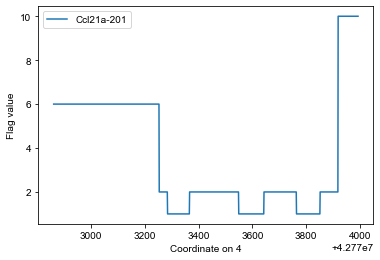

-- searching among 1 references
-- a match found in record: 4.


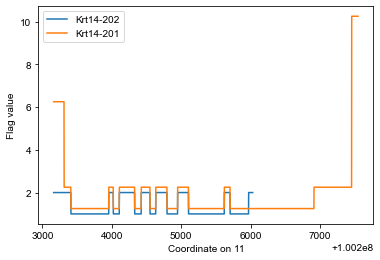

-- searching among 1 references
-- a match found in record: 11.


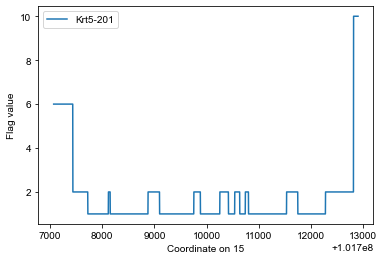

-- searching among 1 references
-- a match found in record: 15.


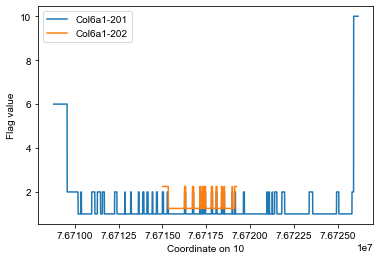

-- searching among 1 references
-- a match found in record: 10.


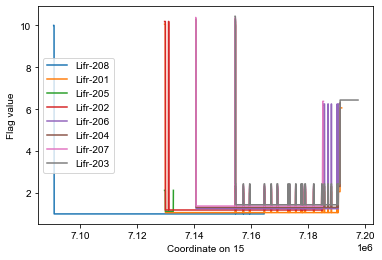

-- searching among 1 references
-- a match found in record: 15.


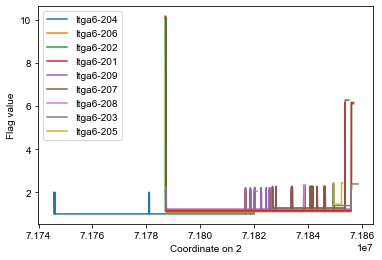

-- searching among 1 references
-- a match found in record: 2.


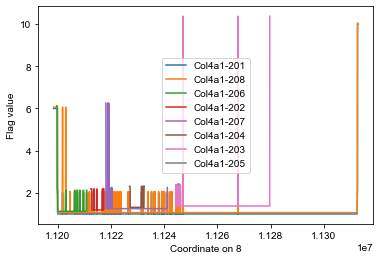

-- searching among 1 references
-- a match found in record: 8.


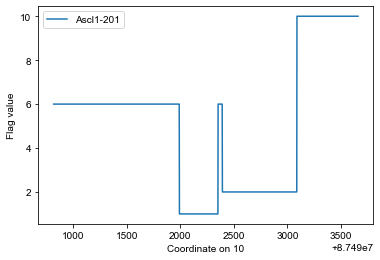

-- searching among 1 references
-- a match found in record: 10.


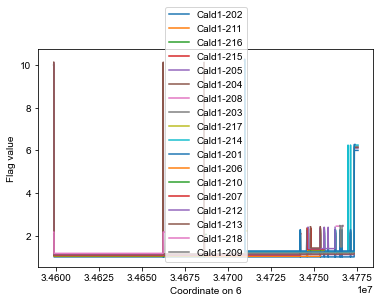

-- searching among 1 references
-- a match found in record: 6.


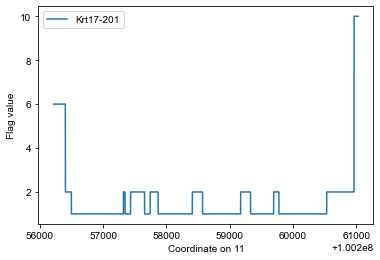

-- searching among 1 references
-- a match found in record: 11.


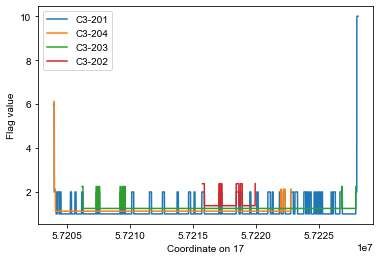

-- searching among 1 references
-- a match found in record: 17.


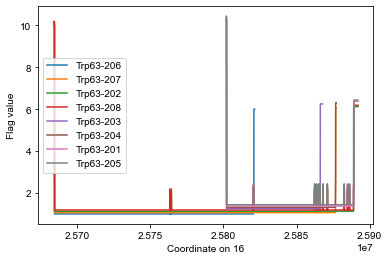

-- searching among 1 references
-- a match found in record: 16.


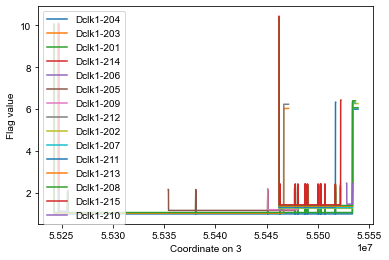

-- searching among 1 references
-- a match found in record: 3.


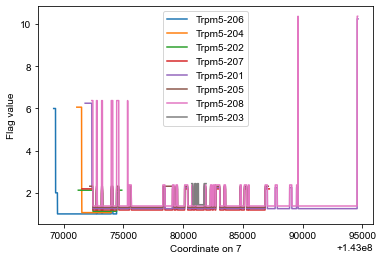

-- searching among 1 references
-- a match found in record: 7.


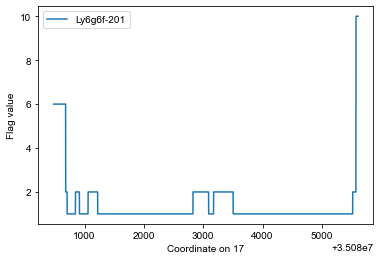

-- searching among 1 references
-- a match found in record: 17.


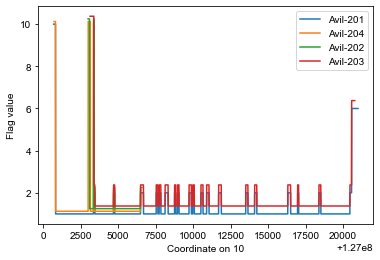

-- searching among 1 references
-- a match found in record: 10.


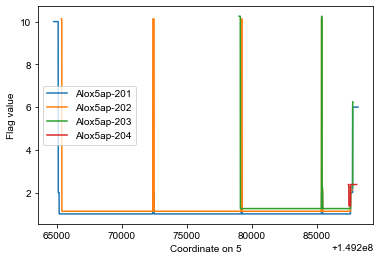

-- searching among 1 references
-- a match found in record: 5.


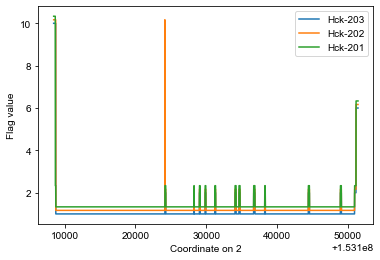

-- searching among 1 references
-- a match found in record: 2.


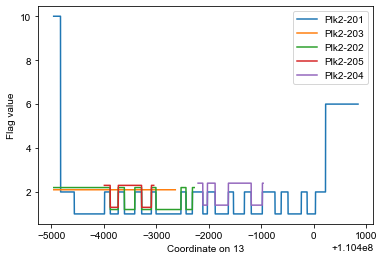

-- searching among 1 references
-- a match found in record: 13.


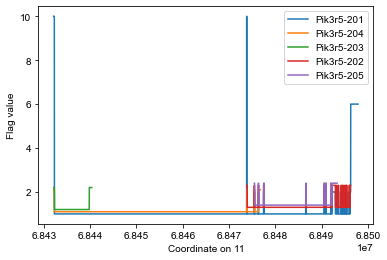

-- searching among 1 references
-- a match found in record: 11.


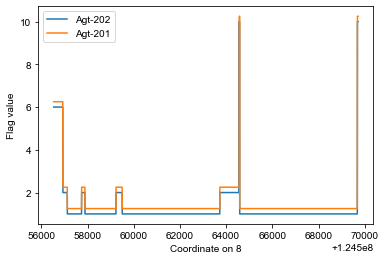

-- searching among 1 references
-- a match found in record: 8.


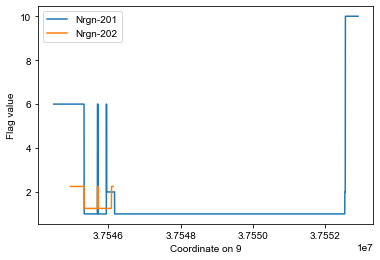

-- searching among 1 references
-- a match found in record: 9.


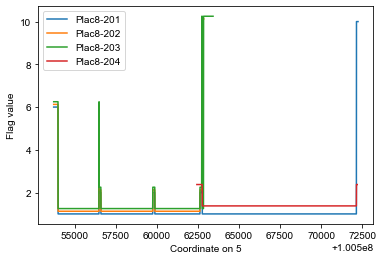

-- searching among 1 references
-- a match found in record: 5.


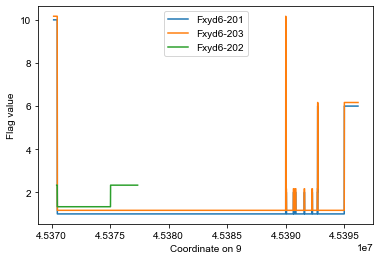

-- searching among 1 references
-- a match found in record: 9.


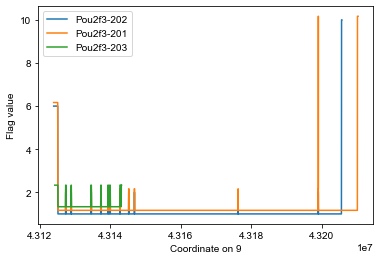

-- searching among 1 references
-- a match found in record: 9.


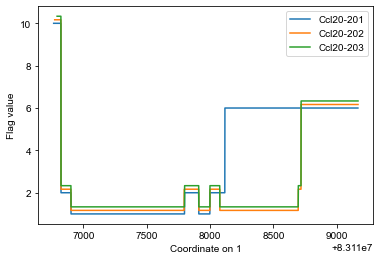

-- searching among 1 references
-- a match found in record: 1.


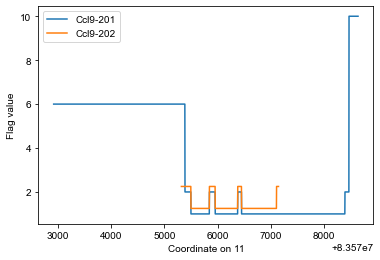

-- searching among 1 references
-- a match found in record: 11.


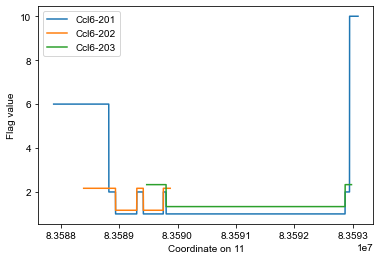

-- searching among 1 references
-- a match found in record: 11.


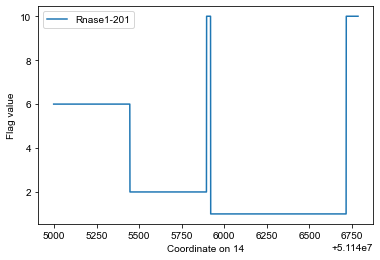

-- searching among 1 references
-- a match found in record: 14.


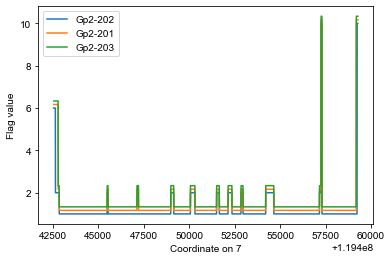

-- searching among 1 references
-- a match found in record: 7.


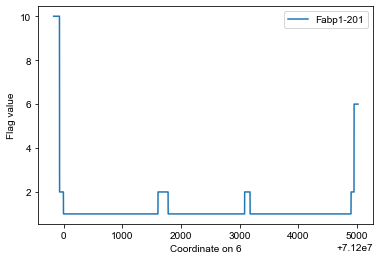

-- searching among 1 references
-- a match found in record: 6.


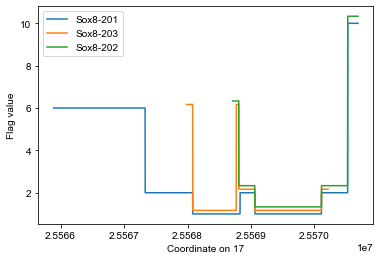

-- searching among 1 references
-- a match found in record: 17.


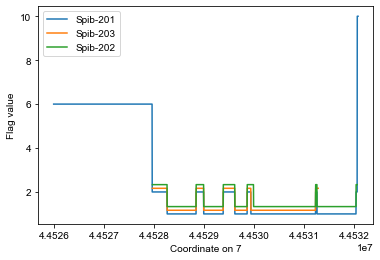

-- searching among 1 references
-- a match found in record: 7.


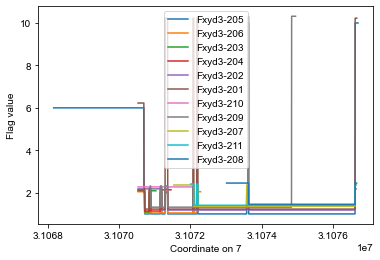

-- searching among 1 references
-- a match found in record: 7.


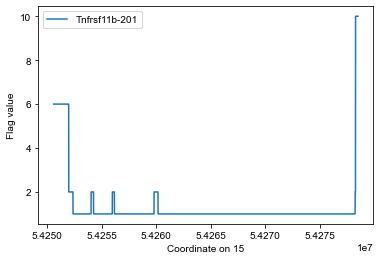

-- searching among 1 references
-- a match found in record: 15.


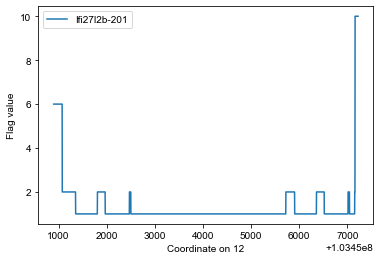

-- searching among 1 references
-- a match found in record: 12.


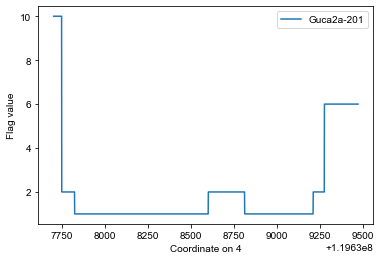

-- searching among 1 references
-- a match found in record: 4.


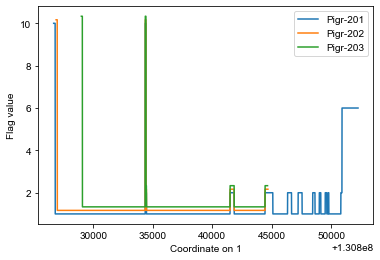

-- searching among 1 references
-- a match found in record: 1.


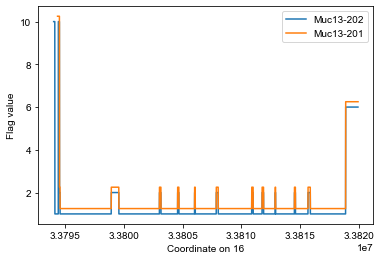

-- searching among 1 references
-- a match found in record: 16.


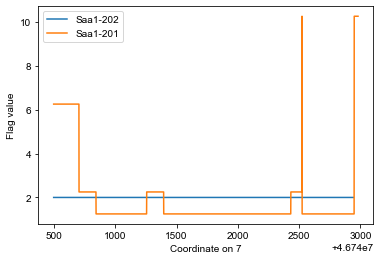

-- searching among 1 references
-- a match found in record: 7.


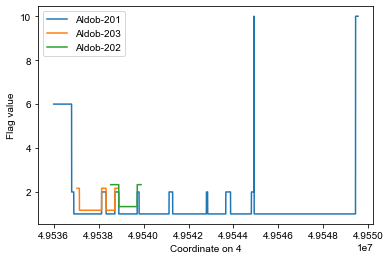

-- searching among 1 references
-- a match found in record: 4.


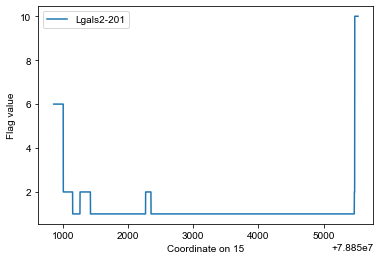

-- searching among 1 references
-- a match found in record: 15.


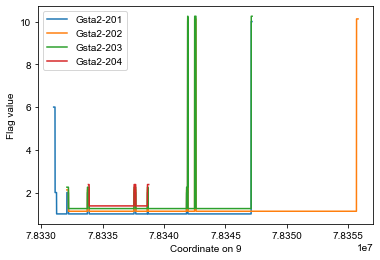

-- searching among 1 references
-- a match found in record: 9.


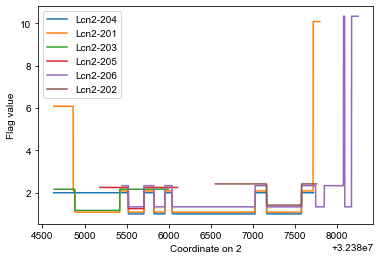

-- searching among 1 references
-- a match found in record: 2.


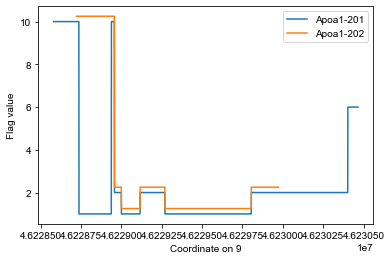

-- searching among 1 references
-- a match found in record: 9.


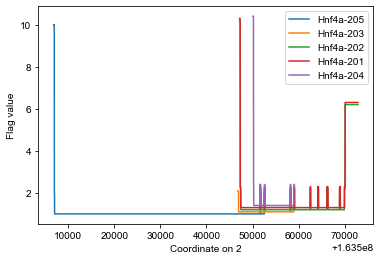

-- searching among 1 references
-- a match found in record: 2.


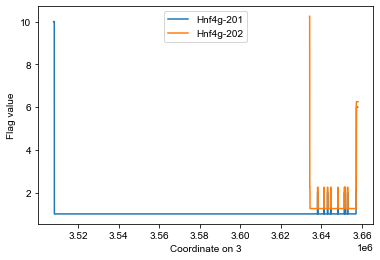

-- searching among 1 references
-- a match found in record: 3.


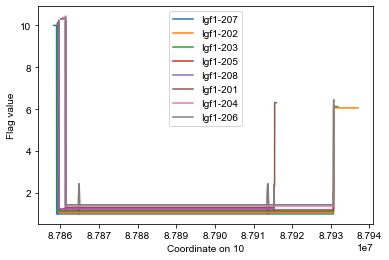

-- searching among 1 references
-- a match found in record: 10.


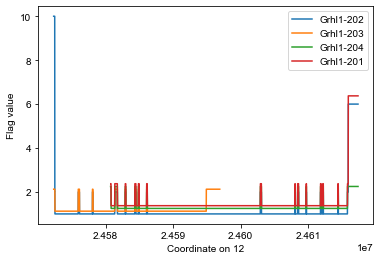

-- searching among 1 references
-- a match found in record: 12.


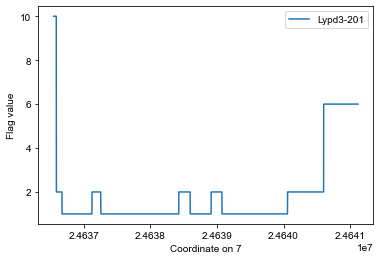

-- searching among 1 references
-- a match found in record: 7.


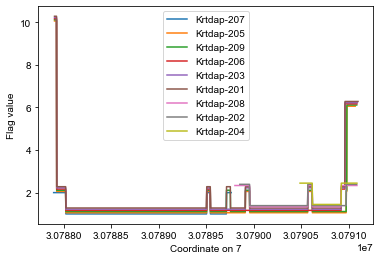

-- searching among 1 references
-- a match found in record: 7.


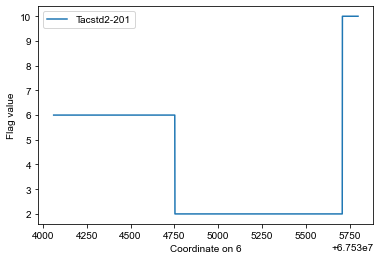

-- searching among 1 references
-- a match found in record: 6.


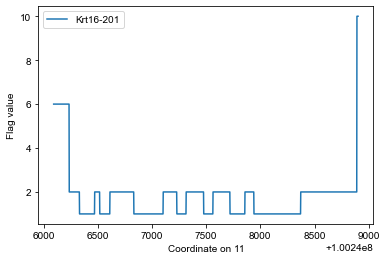

-- searching among 1 references
-- a match found in record: 11.


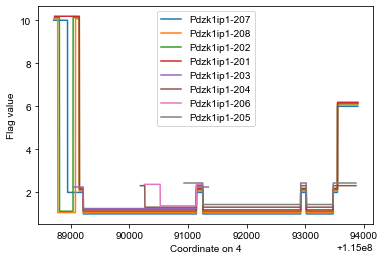

-- searching among 1 references
-- a match found in record: 4.


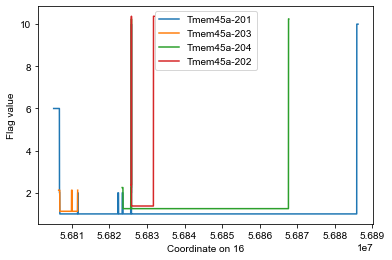

-- searching among 1 references
-- a match found in record: 16.


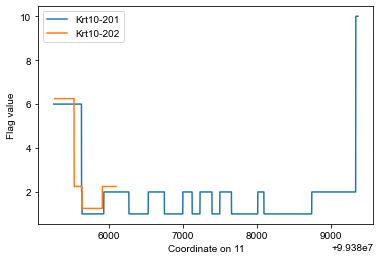

-- searching among 1 references
-- a match found in record: 11.


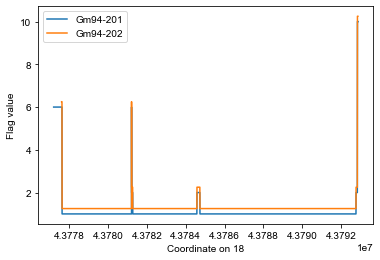

-- searching among 1 references
-- a match found in record: 18.


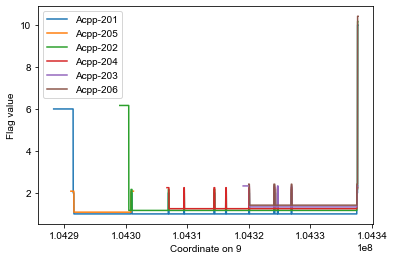

-- searching among 1 references
-- a match found in record: 9.


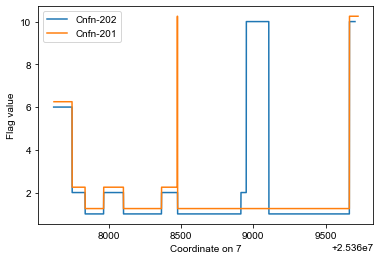

-- searching among 1 references
-- a match found in record: 7.


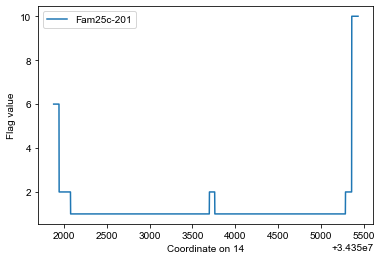

-- searching among 1 references
-- a match found in record: 14.


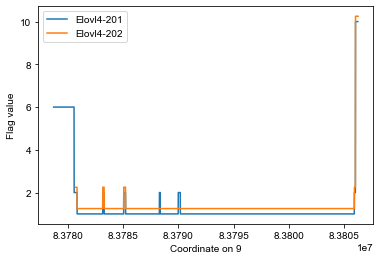

-- searching among 1 references
-- a match found in record: 9.


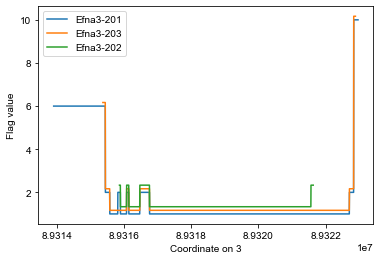

-- searching among 1 references
-- a match found in record: 3.


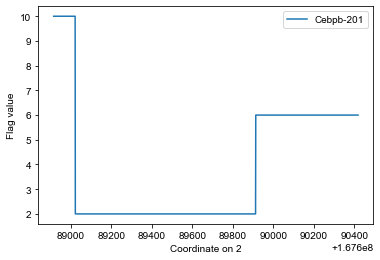

-- searching among 1 references
-- a match found in record: 2.


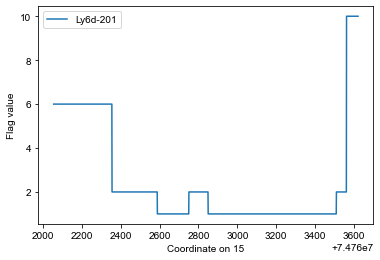

-- searching among 1 references
-- a match found in record: 15.


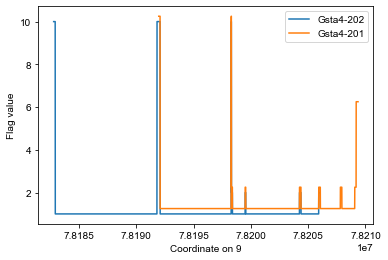

-- searching among 1 references
-- a match found in record: 9.


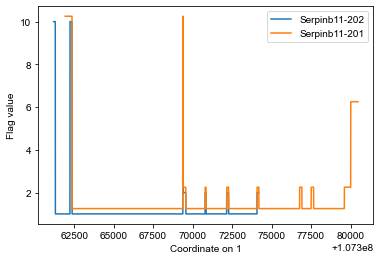

-- searching among 1 references
-- a match found in record: 1.


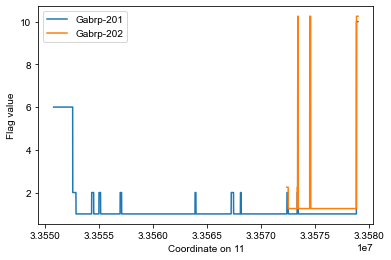

-- searching among 1 references
-- a match found in record: 11.


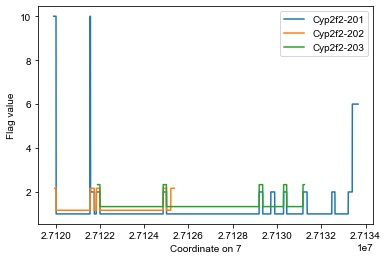

-- searching among 1 references
-- a match found in record: 7.


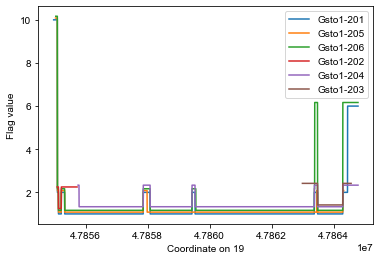

-- searching among 1 references
-- a match found in record: 19.


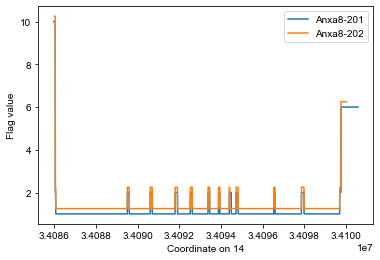

-- searching among 1 references
-- a match found in record: 14.


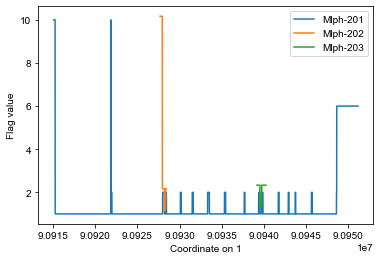

-- searching among 1 references
-- a match found in record: 1.


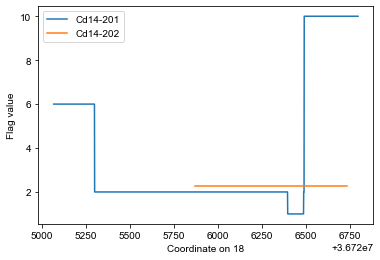

-- searching among 1 references
-- a match found in record: 18.


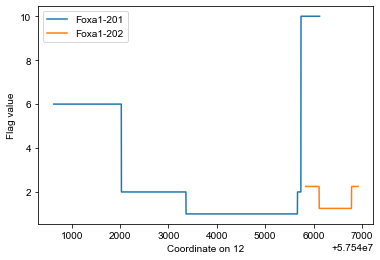

-- searching among 1 references
-- a match found in record: 12.


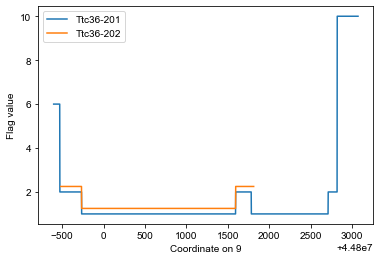

-- searching among 1 references
-- a match found in record: 9.


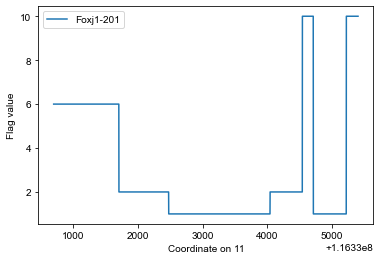

-- searching among 1 references
-- a match found in record: 11.


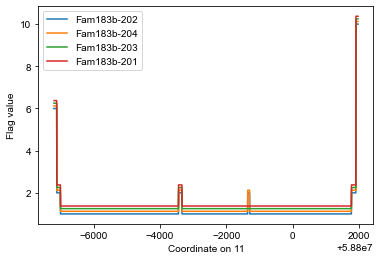

-- searching among 1 references
-- a match found in record: 11.


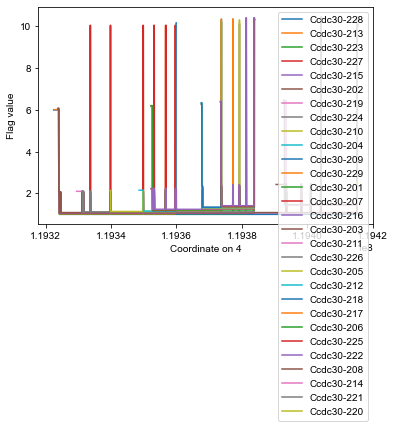

-- searching among 1 references
-- a match found in record: 4.


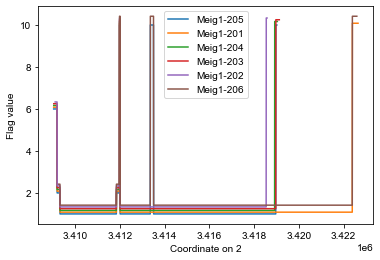

-- searching among 1 references
-- a match found in record: 2.


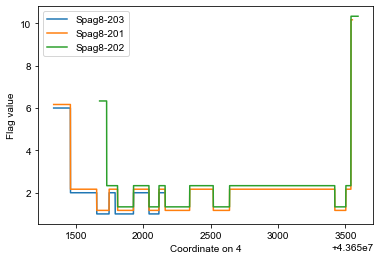

-- searching among 1 references
-- a match found in record: 4.


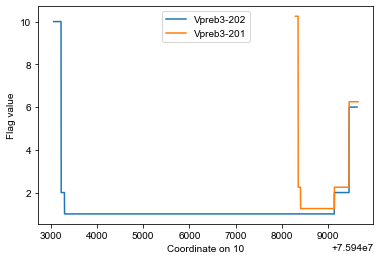

-- searching among 1 references
-- a match found in record: 10.


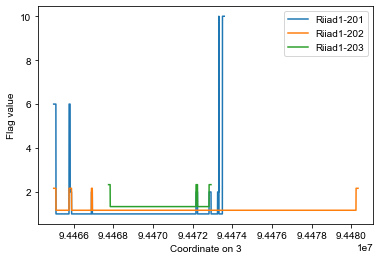

-- searching among 1 references
-- a match found in record: 3.


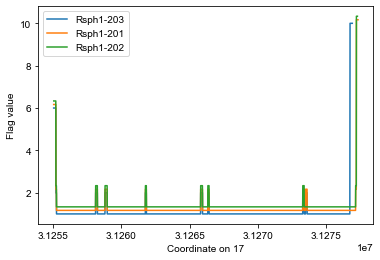

-- searching among 1 references
-- a match found in record: 17.


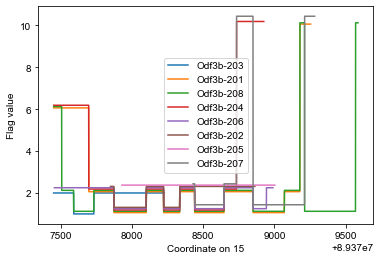

-- searching among 1 references
-- a match found in record: 15.


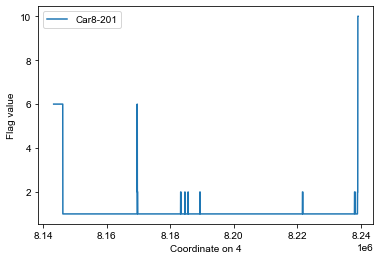

-- searching among 1 references
-- a match found in record: 4.


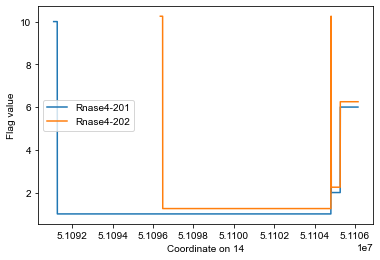

-- searching among 1 references
-- a match found in record: 14.


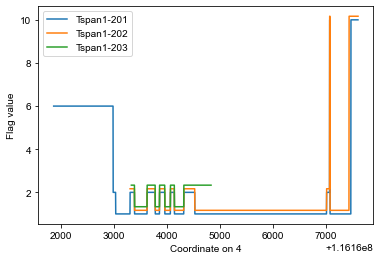

-- searching among 1 references
-- a match found in record: 4.


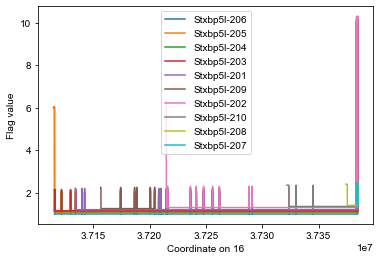

-- searching among 1 references
-- a match found in record: 16.


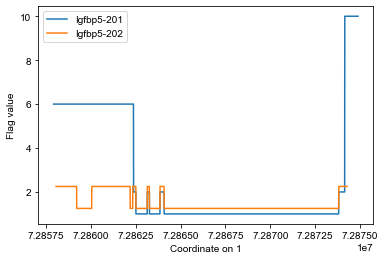

-- searching among 1 references
-- a match found in record: 1.


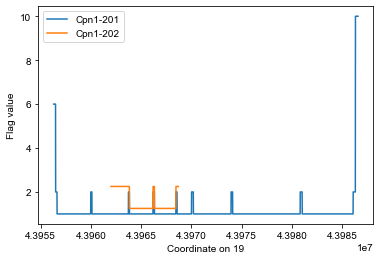

-- searching among 1 references
-- a match found in record: 19.


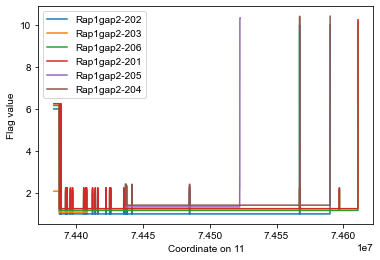

-- searching among 1 references
-- a match found in record: 11.


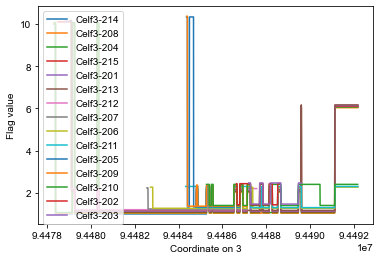

-- searching among 1 references
-- a match found in record: 3.


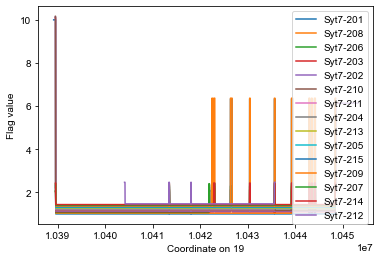

-- searching among 1 references
-- a match found in record: 19.


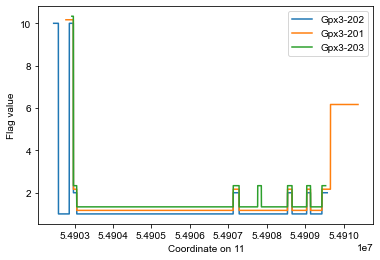

-- searching among 1 references
-- a match found in record: 11.


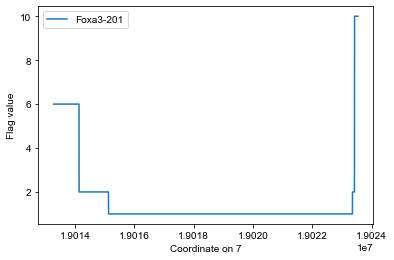

-- searching among 1 references
-- a match found in record: 7.


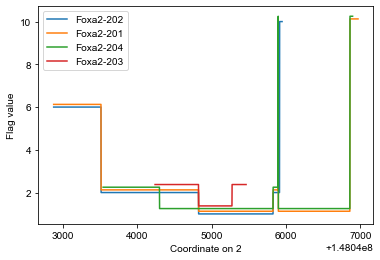

-- searching among 1 references
-- a match found in record: 2.


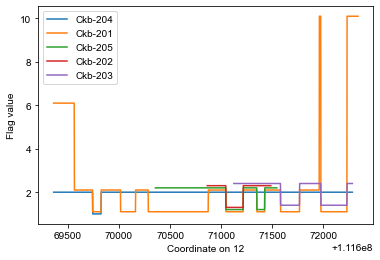

-- searching among 1 references
-- a match found in record: 12.


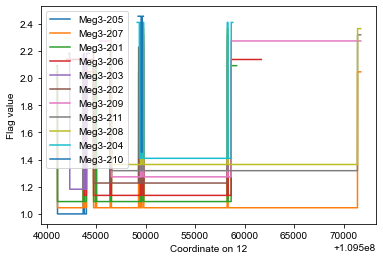

-- searching among 1 references
-- a match found in record: 12.


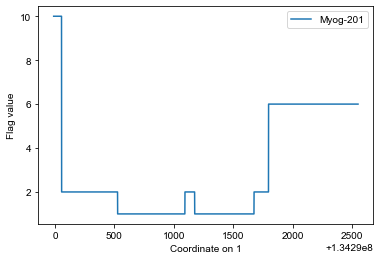

-- searching among 1 references
-- a match found in record: 1.


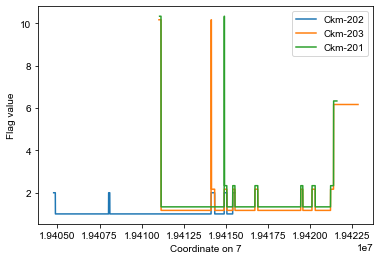

-- searching among 1 references
-- a match found in record: 7.


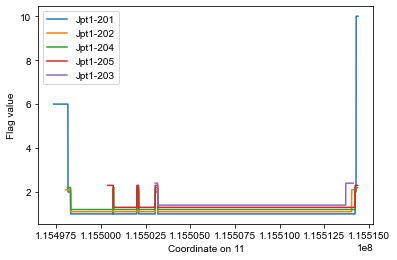

-- searching among 1 references
-- a match found in record: 11.


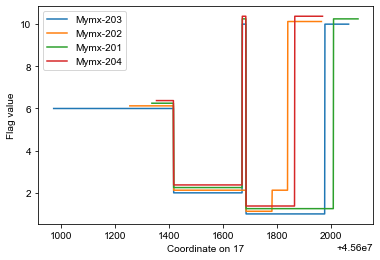

-- searching among 1 references
-- a match found in record: 17.


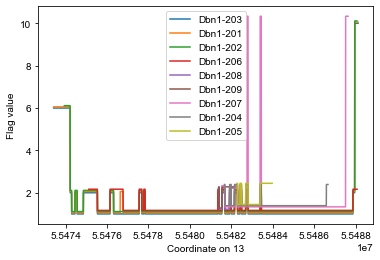

-- searching among 1 references
-- a match found in record: 13.


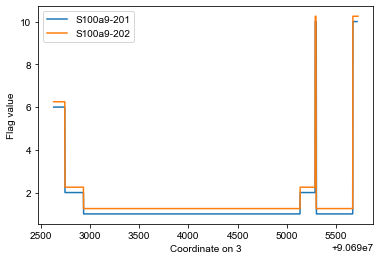

-- searching among 1 references
-- a match found in record: 3.


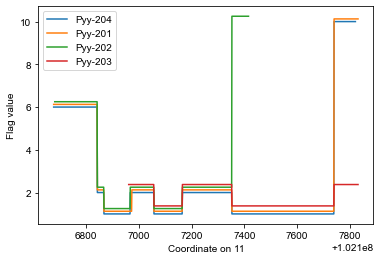

-- searching among 1 references
-- a match found in record: 11.


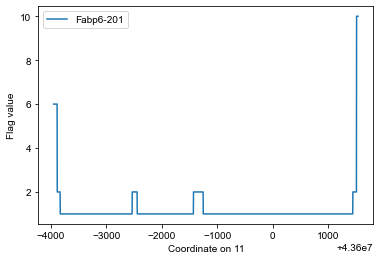

-- searching among 1 references
-- a match found in record: 11.


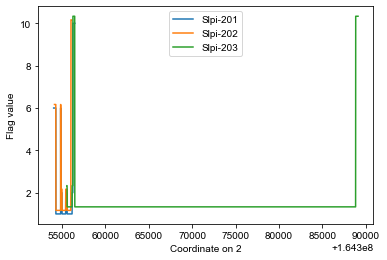

-- searching among 1 references
-- a match found in record: 2.


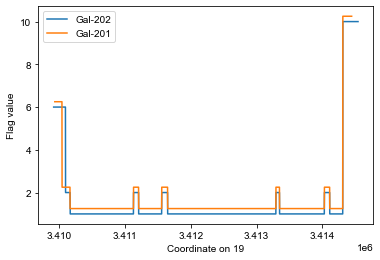

-- searching among 1 references
-- a match found in record: 19.


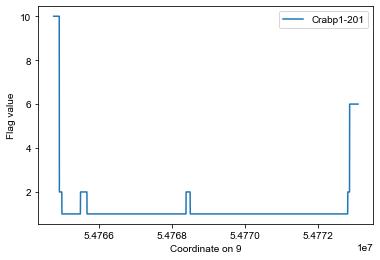

-- searching among 1 references
-- a match found in record: 9.


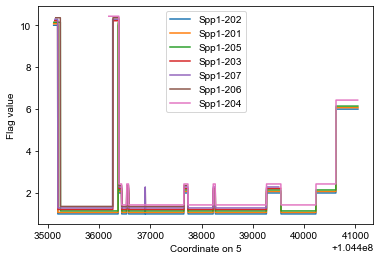

-- searching among 1 references
-- a match found in record: 5.


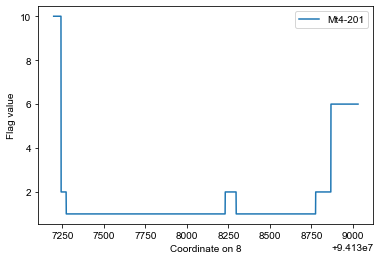

-- searching among 1 references
-- a match found in record: 8.


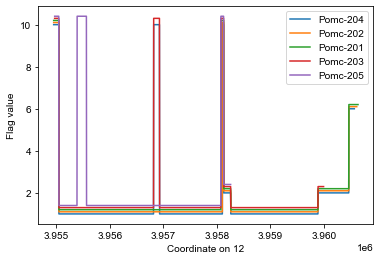

-- searching among 1 references
-- a match found in record: 12.


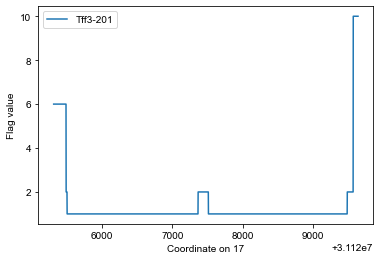

-- searching among 1 references
-- a match found in record: 17.


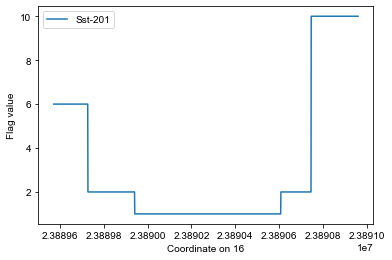

-- searching among 1 references
-- a match found in record: 16.


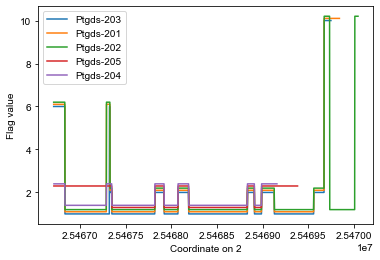

-- searching among 1 references
-- a match found in record: 2.


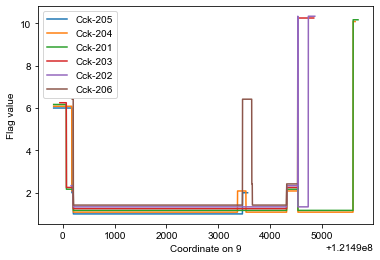

-- searching among 1 references
-- a match found in record: 9.


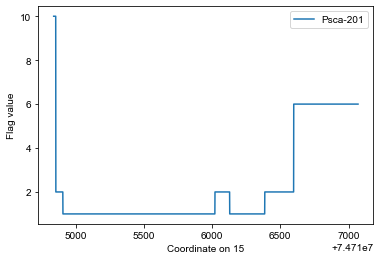

-- searching among 1 references
-- a match found in record: 15.


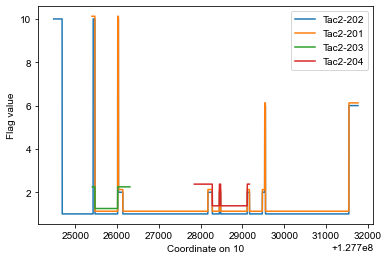

-- searching among 1 references
-- a match found in record: 10.


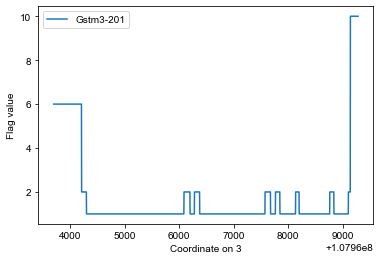

-- searching among 1 references
-- a match found in record: 3.


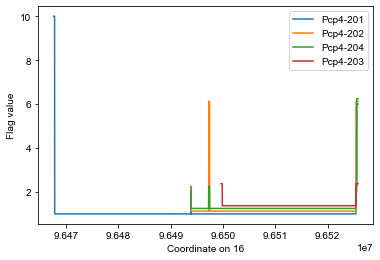

-- searching among 1 references
-- a match found in record: 16.


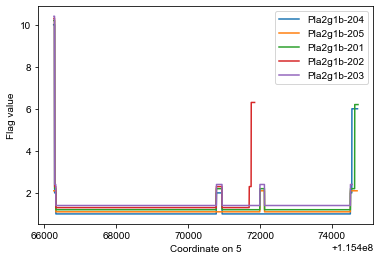

-- searching among 1 references
-- a match found in record: 5.


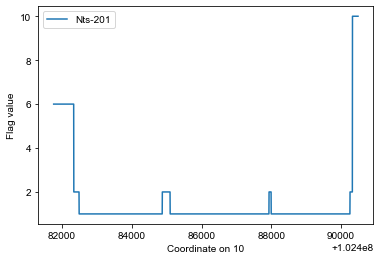

-- searching among 1 references
-- a match found in record: 10.


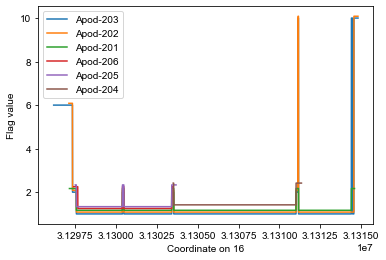

-- searching among 1 references
-- a match found in record: 16.


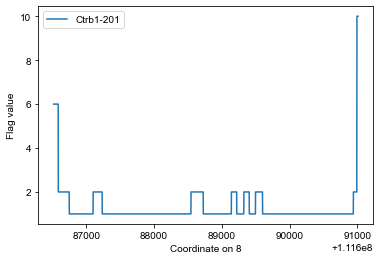

-- searching among 1 references
-- a match found in record: 8.


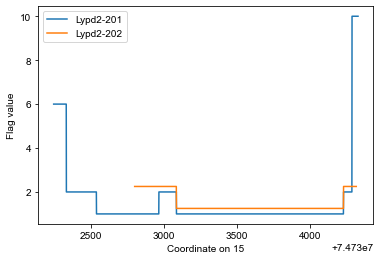

-- searching among 1 references
-- a match found in record: 15.


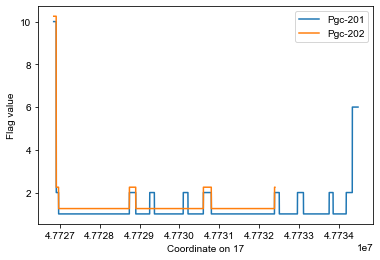

-- searching among 1 references
-- a match found in record: 17.


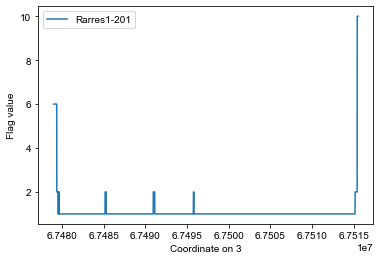

-- searching among 1 references
-- a match found in record: 3.


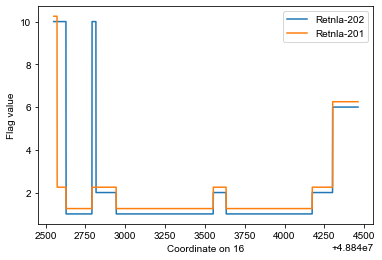

-- searching among 1 references
-- a match found in record: 16.


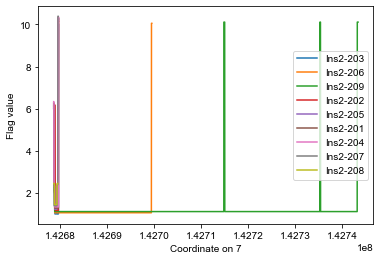

-- searching among 1 references
-- a match found in record: 7.


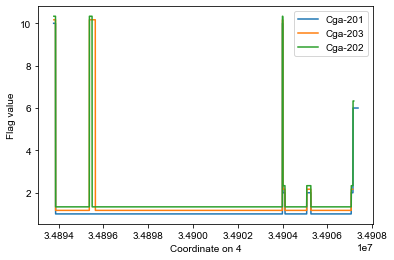

-- searching among 1 references
-- a match found in record: 4.


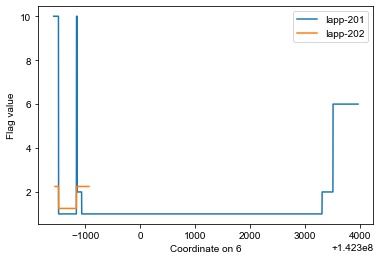

-- searching among 1 references
-- a match found in record: 6.


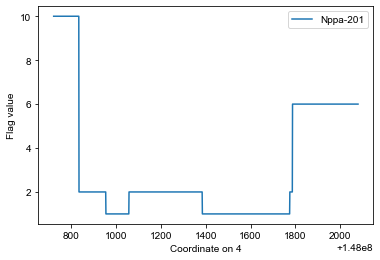

-- searching among 1 references
-- a match found in record: 4.


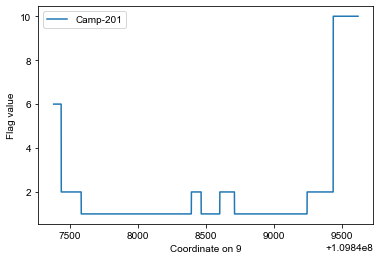

-- searching among 1 references
-- a match found in record: 9.


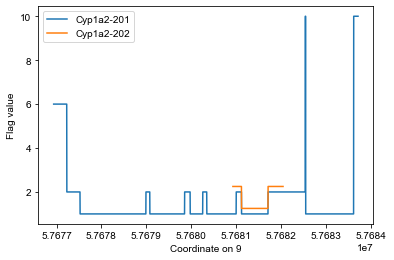

-- searching among 1 references
-- a match found in record: 9.


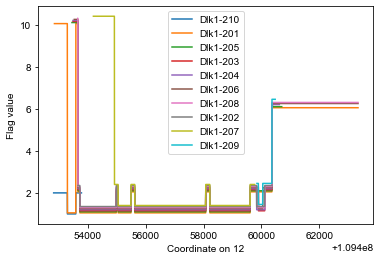

-- searching among 1 references
-- a match found in record: 12.


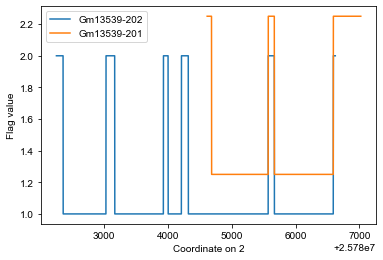

-- searching among 1 references
-- a match found in record: 2.


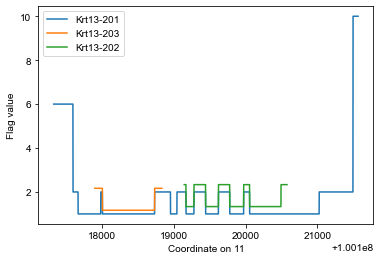

-- searching among 1 references
-- a match found in record: 11.


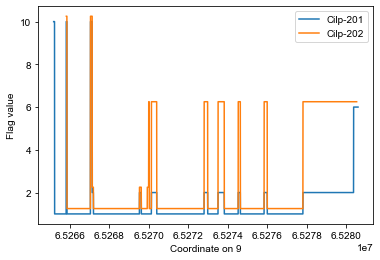

-- searching among 1 references
-- a match found in record: 9.


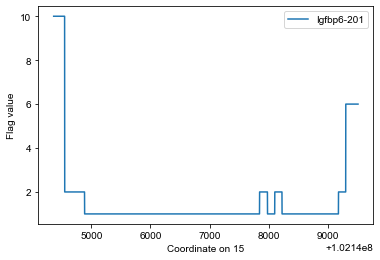

-- searching among 1 references
-- a match found in record: 15.


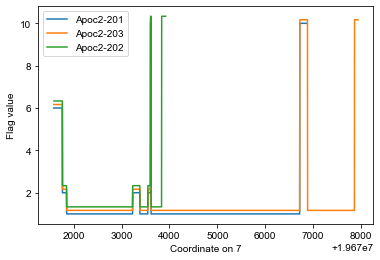

-- searching among 1 references
-- a match found in record: 7.


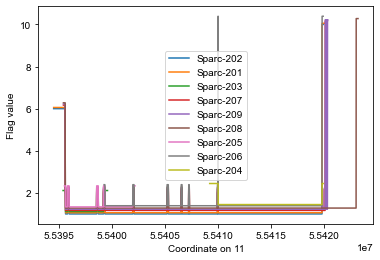

-- searching among 1 references
-- a match found in record: 11.


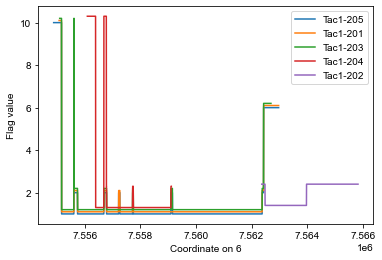

-- searching among 1 references
-- a match found in record: 6.


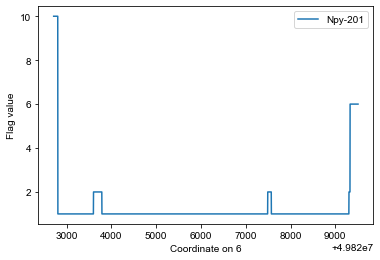

-- searching among 1 references
-- a match found in record: 6.


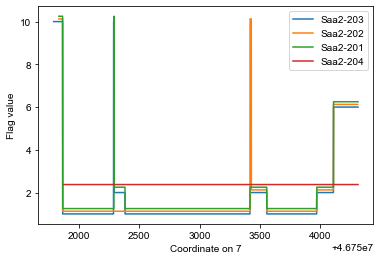

-- searching among 1 references
-- a match found in record: 7.


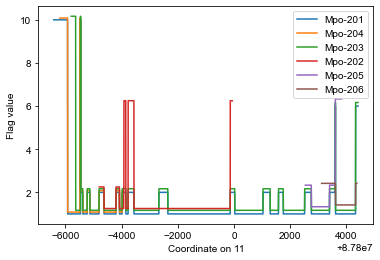

-- searching among 1 references
-- a match found in record: 11.


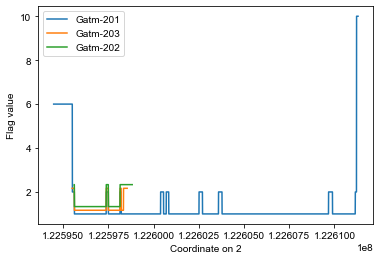

-- searching among 1 references
-- a match found in record: 2.


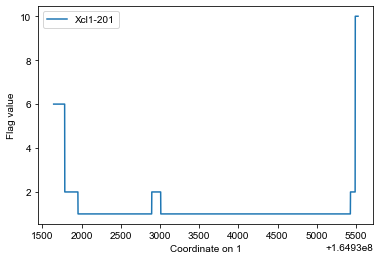

-- searching among 1 references
-- a match found in record: 1.


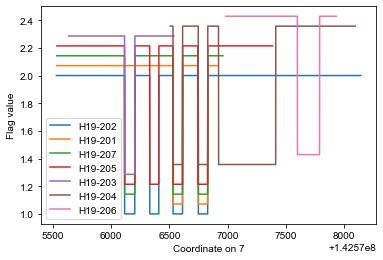

-- searching among 1 references
-- a match found in record: 7.


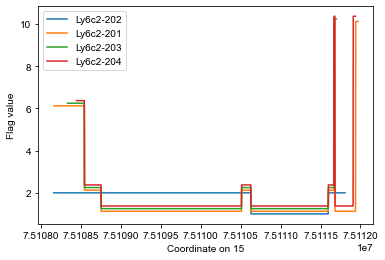

-- searching among 1 references
-- a match found in record: 15.


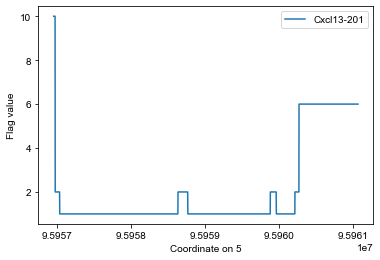

-- searching among 1 references
-- a match found in record: 5.


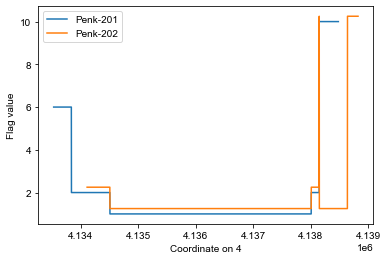

-- searching among 1 references
-- a match found in record: 4.


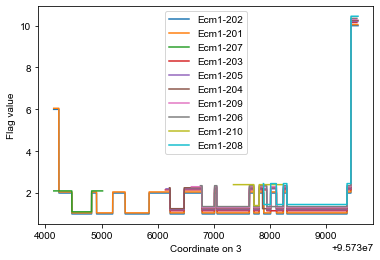

-- searching among 1 references
-- a match found in record: 3.


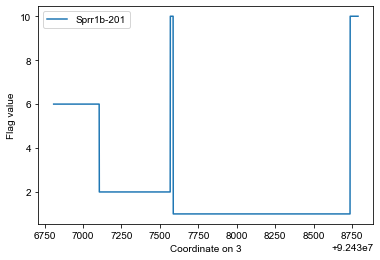

-- searching among 1 references
-- a match found in record: 3.


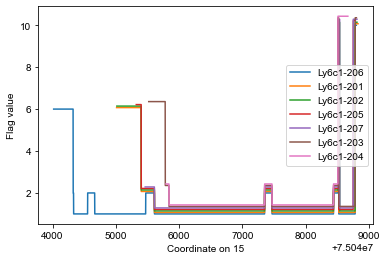

-- searching among 1 references
-- a match found in record: 15.


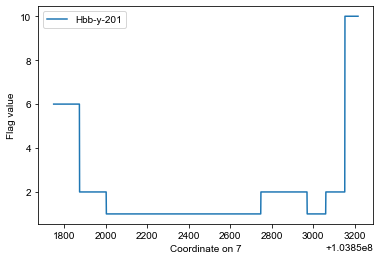

-- searching among 1 references
-- a match found in record: 7.


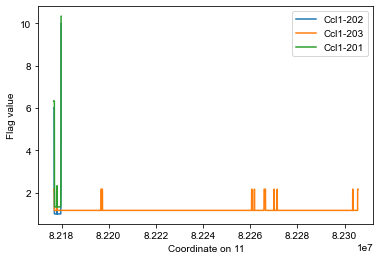

-- searching among 1 references
-- a match found in record: 11.


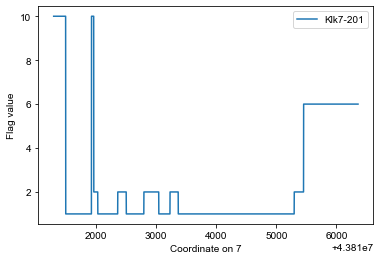

-- searching among 1 references
-- a match found in record: 7.


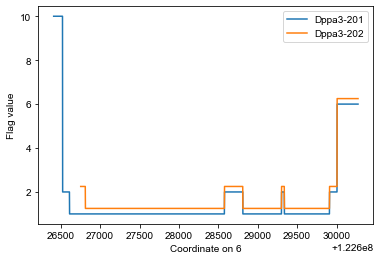

-- searching among 1 references
-- a match found in record: 6.


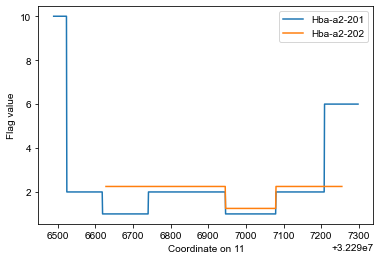

-- searching among 1 references
-- a match found in record: 11.


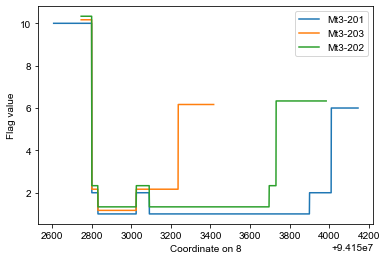

-- searching among 1 references
-- a match found in record: 8.


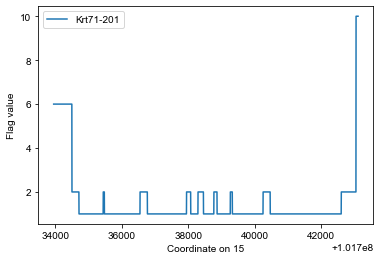

-- searching among 1 references
-- a match found in record: 15.


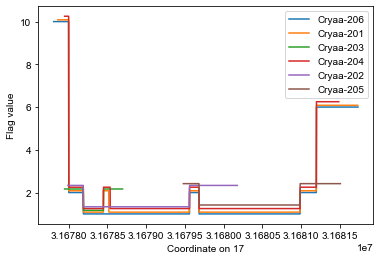

-- searching among 1 references
-- a match found in record: 17.


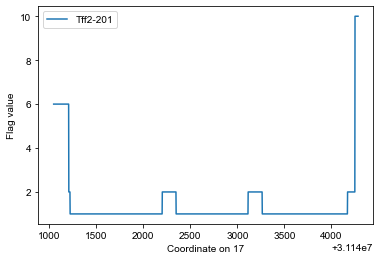

-- searching among 1 references
-- a match found in record: 17.


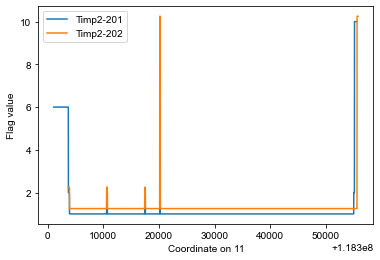

-- searching among 1 references
-- a match found in record: 11.


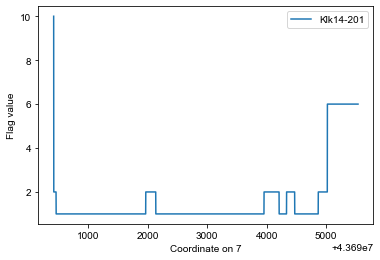

-- searching among 1 references
-- a match found in record: 7.


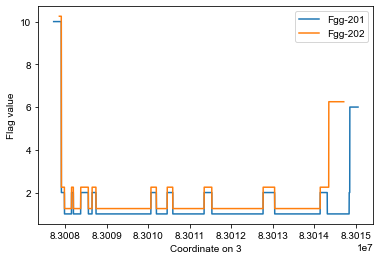

-- searching among 1 references
-- a match found in record: 3.


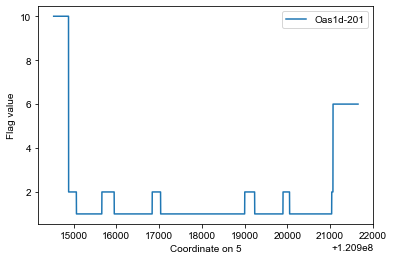

-- searching among 1 references
-- a match found in record: 5.


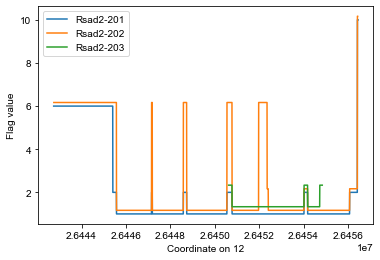

-- searching among 1 references
-- a match found in record: 12.


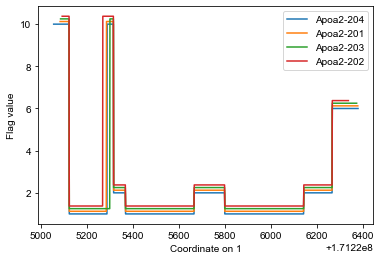

-- searching among 1 references
-- a match found in record: 1.


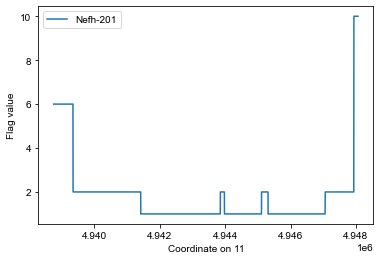

-- searching among 1 references
-- a match found in record: 11.


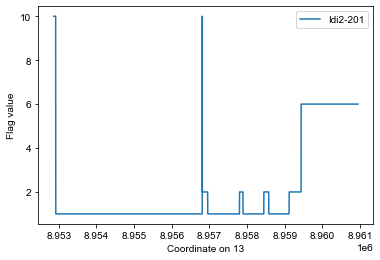

-- searching among 1 references
-- a match found in record: 13.


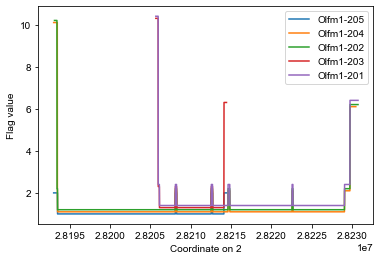

-- searching among 1 references
-- a match found in record: 2.


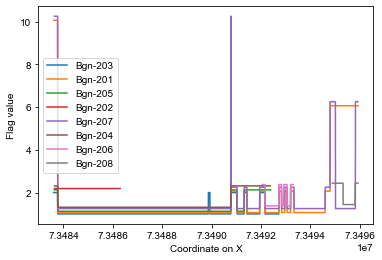

-- searching among 1 references
-- a match found in record: X.


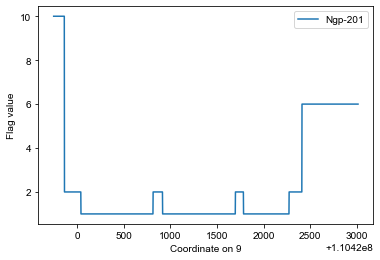

-- searching among 1 references
-- a match found in record: 9.


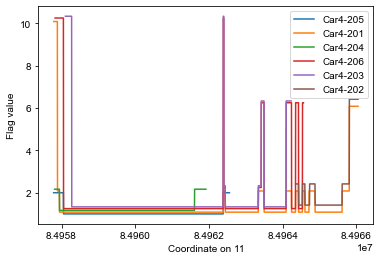

-- searching among 1 references
-- a match found in record: 11.


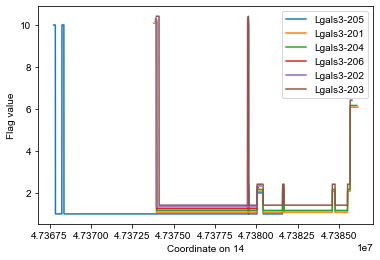

-- searching among 1 references
-- a match found in record: 14.


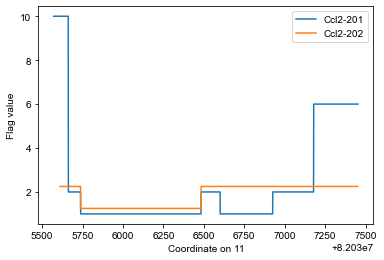

-- searching among 1 references
-- a match found in record: 11.


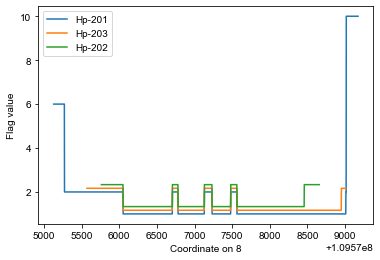

-- searching among 1 references
-- a match found in record: 8.


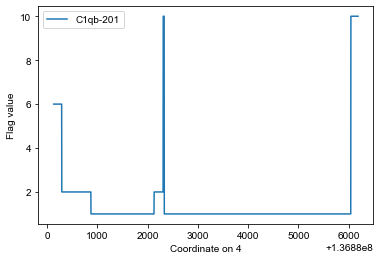

-- searching among 1 references
-- a match found in record: 4.


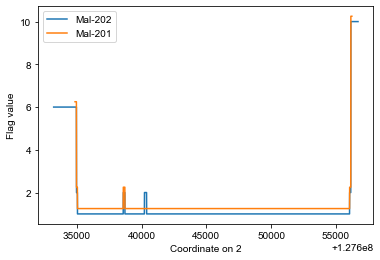

-- searching among 1 references
-- a match found in record: 2.


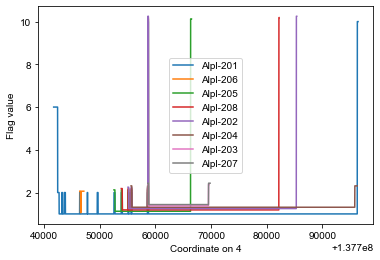

-- searching among 1 references
-- a match found in record: 4.


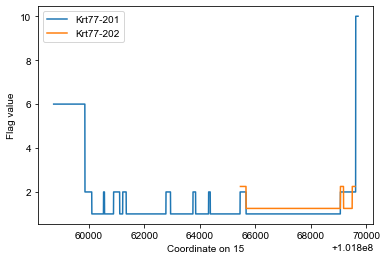

-- searching among 1 references
-- a match found in record: 15.


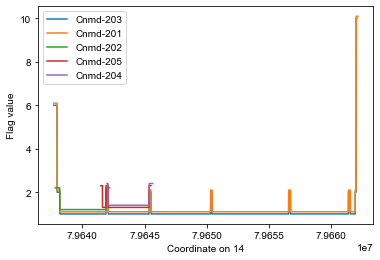

-- searching among 1 references
-- a match found in record: 14.


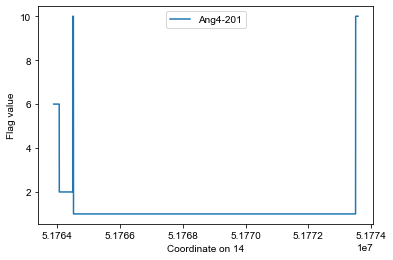

-- searching among 1 references
-- a match found in record: 14.


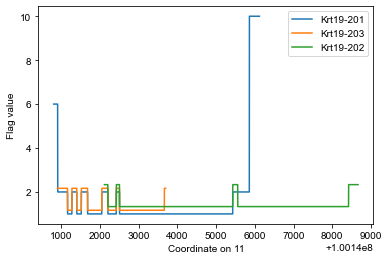

-- searching among 1 references
-- a match found in record: 11.


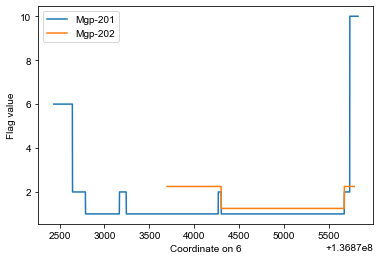

-- searching among 1 references
-- a match found in record: 6.


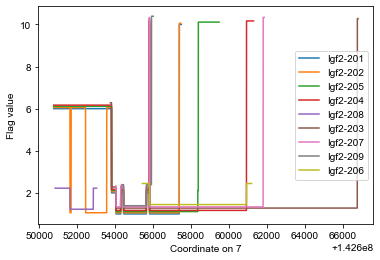

-- searching among 1 references
-- a match found in record: 7.


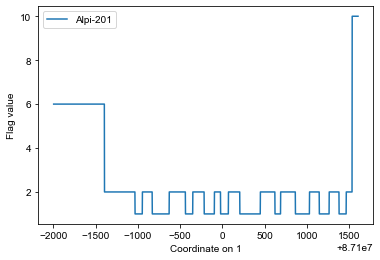

-- searching among 1 references
-- a match found in record: 1.


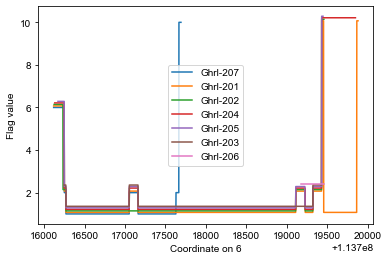

-- searching among 1 references
-- a match found in record: 6.


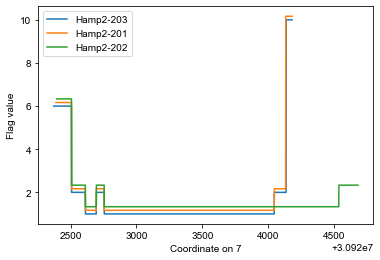

-- searching among 1 references
-- a match found in record: 7.


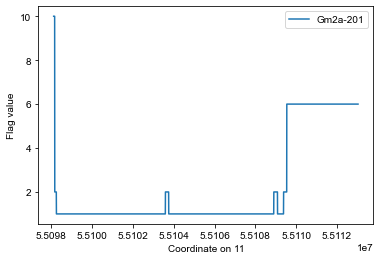

-- searching among 1 references
-- a match found in record: 11.


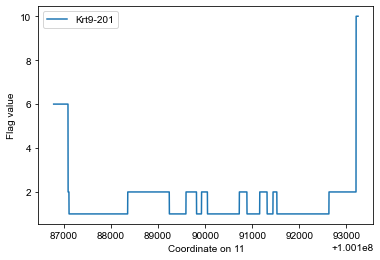

-- searching among 1 references
-- a match found in record: 11.


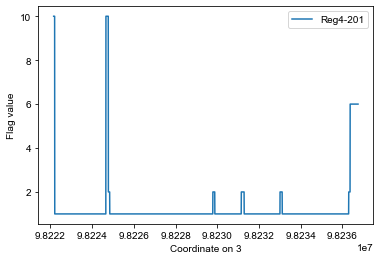

-- searching among 1 references
-- a match found in record: 3.


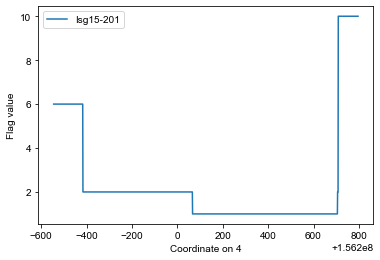

-- searching among 1 references
-- a match found in record: 4.


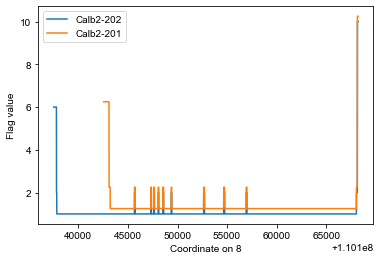

-- searching among 1 references
-- a match found in record: 8.


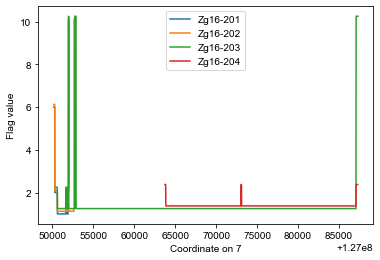

-- searching among 1 references
-- a match found in record: 7.


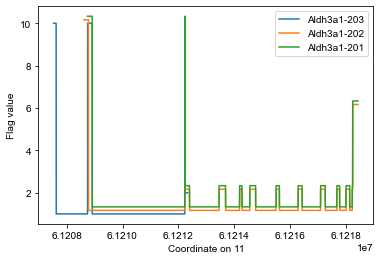

-- searching among 1 references
-- a match found in record: 11.


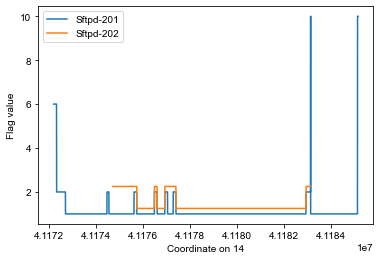

-- searching among 1 references
-- a match found in record: 14.


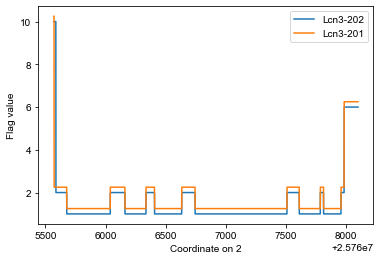

-- searching among 1 references
-- a match found in record: 2.


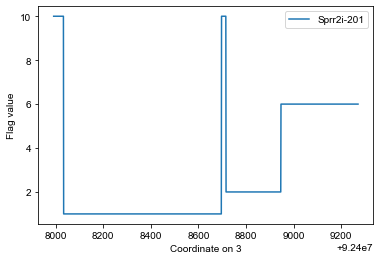

-- searching among 1 references
-- a match found in record: 3.


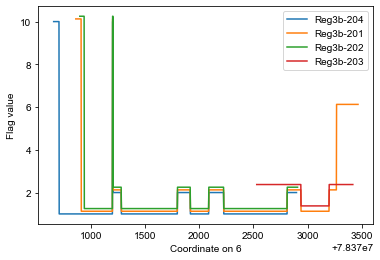

-- searching among 1 references
-- a match found in record: 6.


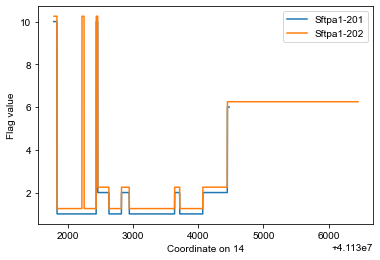

-- searching among 1 references
-- a match found in record: 14.


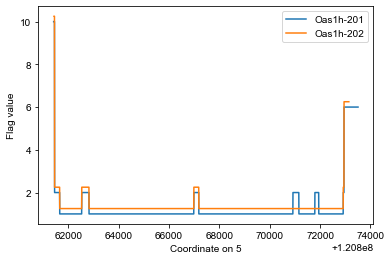

-- searching among 1 references
-- a match found in record: 5.


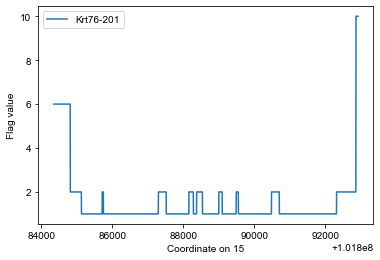

-- searching among 1 references
-- a match found in record: 15.


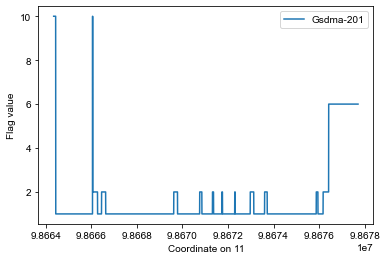

-- searching among 1 references
-- a match found in record: 11.


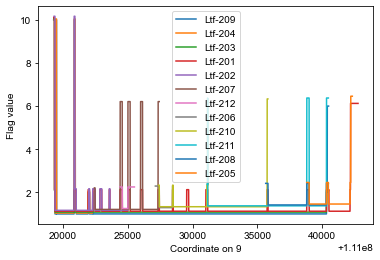

-- searching among 1 references
-- a match found in record: 9.


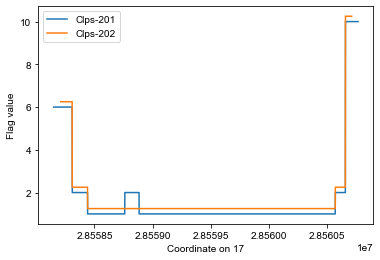

-- searching among 1 references
-- a match found in record: 17.


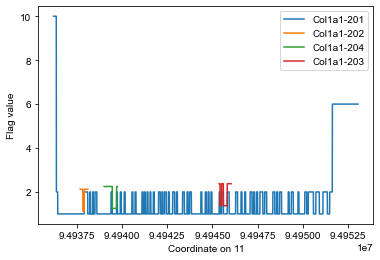

-- searching among 1 references
-- a match found in record: 11.


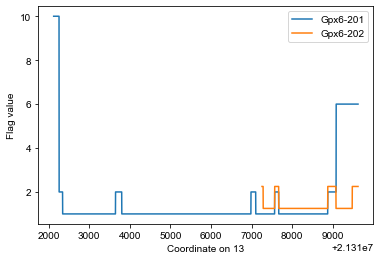

-- searching among 1 references
-- a match found in record: 13.


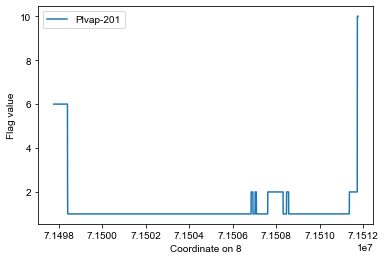

-- searching among 1 references
-- a match found in record: 8.


In [185]:
# load smallest exons for given genes by sequence reader
%matplotlib inline
sm_intron_record_dict = seq_rd.find_smallest_introns(gene_dicts, save=True)

In [186]:
len(sm_intron_record_dict)

209

In [187]:
sm_intron_files = seq_rd._save_sequences_from_dict('small_intron_dict', sequence_folder, merge=False)

-- saving small_intron_dict sequences into folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ccl21a_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ccl21a_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ccl21a_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt14_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt14_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt14_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\K

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_8.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_9.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_10.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_11.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_12.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_13.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_14.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trp63_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trp63_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trp63_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trp63_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trp63_small_intron_5.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trp63_small_intron_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trp63_small_intron_7.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trp63_small

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Hck_small_intron_11.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Hck_small_intron_12.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Plk2_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Plk2_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Plk2_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Plk2_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Plk2_small_intron_5.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Plk2_small_intron_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_7.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_8.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_9.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_10.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_11.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_12.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Muc13_small_int

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Tmem45a_small_intron_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Tmem45a_small_intron_7.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Tmem45a_small_intron_8.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt10_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt10_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt10_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt10_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt10

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Foxa1_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ttc36_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ttc36_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Foxj1_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Foxj1_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Fam183b_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Fam183b_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Fam183b

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_19.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_20.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_21.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_22.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_23.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_24.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_25.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ckb_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Meg3_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Meg3_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Meg3_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Meg3_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Meg3_small_intron_5.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Meg3_small_intron_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Meg3_small_intron_7

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pcp4_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pcp4_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pcp4_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pcp4_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pla2g1b_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pla2g1b_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pla2g1b_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pla2g1b_s

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mpo_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mpo_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mpo_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mpo_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mpo_small_intron_5.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mpo_small_intron_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mpo_small_intron_7.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mpo_small_intron_8.fasta


-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Nefh_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Nefh_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Idi2_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Idi2_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Idi2_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Idi2_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Olfm1_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Olfm1_small_intro

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igf2_small_intron_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igf2_small_intron_7.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Alpi_small_intron_1.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Alpi_small_intron_2.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Alpi_small_intron_3.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Alpi_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Alpi_small_intron_5.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Alpi_small_intron_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_4.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_5.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_6.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_7.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_8.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_9.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_10.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_smal

## load isoforms for data processsing

- find mRNA for gene: Ccl21a


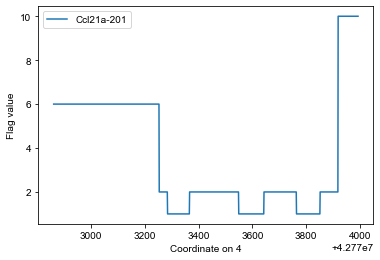

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Ccl21a_id_transcript:ENSMUST00000095114_name_Ccl21a-201_type_mRNA_strand_-_loc_4:42772860-42773993, size=870
- find mRNA for gene: Krt14


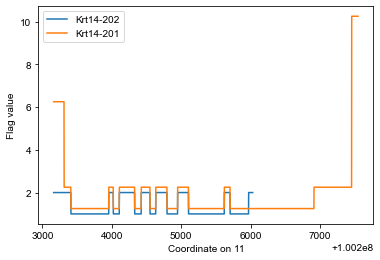

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt14_id_transcript:ENSMUST00000137265_name_Krt14-202_type_lnc_RNA_strand_-_loc_11:100203162-100206030, size=1122
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt14_id_transcript:ENSMUST00000007272_name_Krt14-201_type_mRNA_strand_-_loc_11:100203162-100207548, size=1698
- find mRNA for gene: Krt5


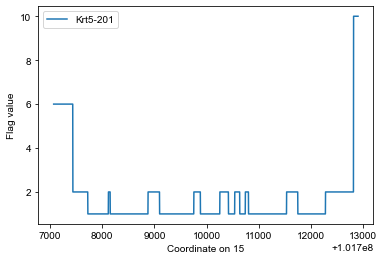

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Krt5_id_transcript:ENSMUST00000023709_name_Krt5-201_type_mRNA_strand_-_loc_15:101707070-101712898, size=2197
- find mRNA for gene: Col6a1


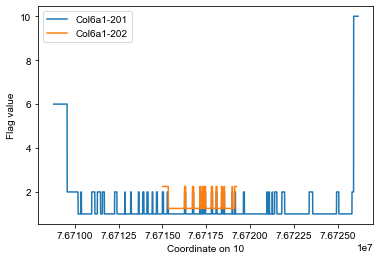

-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Col6a1_id_transcript:ENSMUST00000001147_name_Col6a1-201_type_mRNA_strand_-_loc_10:76708792-76726168, size=4100
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Col6a1_id_transcript:ENSMUST00000137599_name_Col6a1-202_type_lnc_RNA_strand_-_loc_10:76715016-76719236, size=925
- find mRNA for gene: Lifr


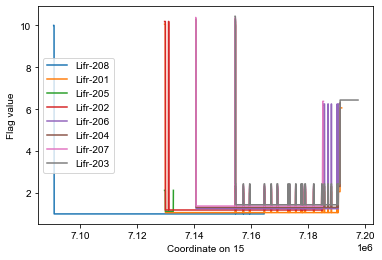

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Lifr_id_transcript:ENSMUST00000228723_name_Lifr-208_type_mRNA_strand_+_loc_15:7090614-7164566, size=577
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Lifr_id_transcript:ENSMUST00000067190_name_Lifr-201_type_mRNA_strand_+_loc_15:7129559-7191743, size=4143
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Lifr_id_transcript:ENSMUST00000226826_name_Lifr-205_type_lnc_RNA_strand_+_loc_15:7129567-7132653, size=299
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Lifr_id_transcript:ENSMUST00000164529_name_Lifr-202_type_mRNA_strand_+_loc_15:7129572-7185343, size=2844
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Lifr_id_transcript:ENSMUST00000226934_name_Lifr-206_type_mRNA_strand_+_loc_15:7140542-719

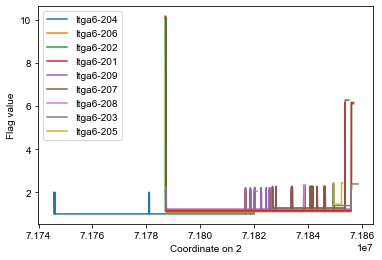

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Itga6_id_transcript:ENSMUST00000133124_name_Itga6-204_type_lnc_RNA_strand_+_loc_2:71745616-71820254, size=707
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Itga6_id_transcript:ENSMUST00000152009_name_Itga6-206_type_lnc_RNA_strand_+_loc_2:71786929-71820943, size=1542
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Itga6_id_transcript:ENSMUST00000112101_name_Itga6-202_type_mRNA_strand_+_loc_2:71786940-71856771, size=4156
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Itga6_id_transcript:ENSMUST00000028522_name_Itga6-201_type_mRNA_strand_+_loc_2:71786978-71856758, size=4310
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Itga6_id_transcript:ENSMUST00000238991_name_Itga6-209_type_mRNA_strand_+_loc_2

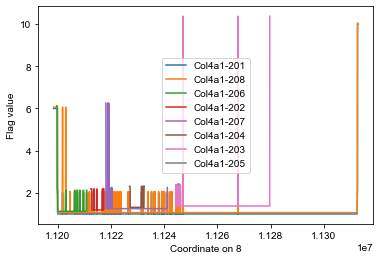

-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Col4a1_id_transcript:ENSMUST00000033898_name_Col4a1-201_type_mRNA_strand_-_loc_8:11198423-11312826, size=6615
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Col4a1_id_transcript:ENSMUST00000209735_name_Col4a1-208_type_mRNA_strand_-_loc_8:11198431-11312689, size=6487
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Col4a1_id_transcript:ENSMUST00000209598_name_Col4a1-206_type_mRNA_strand_-_loc_8:11199519-11210831, size=1170
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Col4a1_id_transcript:ENSMUST00000130488_name_Col4a1-202_type_lnc_RNA_strand_-_loc_8:11212401-11217269, size=676
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Col4a1_id_transcript:ENSMUST00000209661_name_Col4a1-207_type_mRNA_strand_

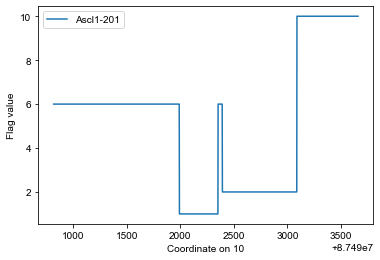

-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Ascl1_id_transcript:ENSMUST00000020243_name_Ascl1-201_type_mRNA_strand_-_loc_10:87490819-87493660, size=2481
- find mRNA for gene: Cald1


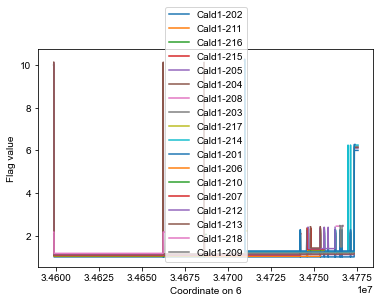

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Cald1_id_transcript:ENSMUST00000079391_name_Cald1-202_type_mRNA_strand_+_loc_6:34598500-34775454, size=4127
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Cald1_id_transcript:ENSMUST00000142512_name_Cald1-211_type_mRNA_strand_+_loc_6:34598512-34753588, size=956
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Cald1_id_transcript:ENSMUST00000155714_name_Cald1-216_type_lnc_RNA_strand_+_loc_6:34598544-34687173, size=1422
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Cald1_id_transcript:ENSMUST00000154182_name_Cald1-215_type_lnc_RNA_strand_+_loc_6:34598544-34742208, size=743
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Cald1_id_transcript:ENSMUST00000115027_name_Cald1-205_type_mRNA_strand_+_loc_6:

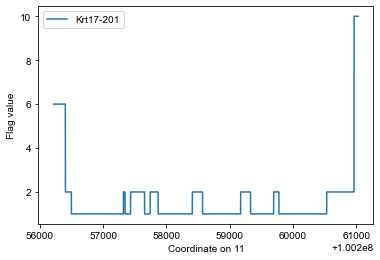

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt17_id_transcript:ENSMUST00000080893_name_Krt17-201_type_mRNA_strand_-_loc_11:100256217-100261029, size=1551
- find mRNA for gene: C3


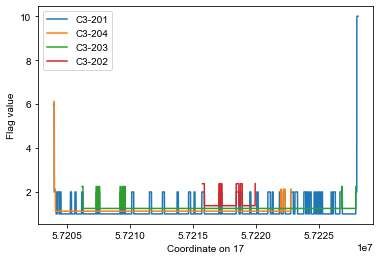

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_C3_id_transcript:ENSMUST00000024988_name_C3-201_type_mRNA_strand_-_loc_17:57203970-57228136, size=5136
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_C3_id_transcript:ENSMUST00000177425_name_C3-204_type_mRNA_strand_-_loc_17:57204007-57222827, size=315
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_C3_id_transcript:ENSMUST00000177046_name_C3-203_type_mRNA_strand_-_loc_17:57206217-57228003, size=554
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_C3_id_transcript:ENSMUST00000176457_name_C3-202_type_lnc_RNA_strand_-_loc_17:57215788-57219972, size=662
- find mRNA for gene: Trp63


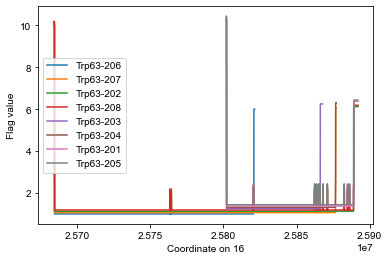

-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Trp63_id_transcript:ENSMUST00000115307_name_Trp63-206_type_mRNA_strand_+_loc_16:25683763-25821318, size=1782
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Trp63_id_transcript:ENSMUST00000115308_name_Trp63-207_type_mRNA_strand_+_loc_16:25683765-25877144, size=2380
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Trp63_id_transcript:ENSMUST00000065523_name_Trp63-202_type_mRNA_strand_+_loc_16:25683765-25892087, size=5257
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Trp63_id_transcript:ENSMUST00000115310_name_Trp63-208_type_mRNA_strand_+_loc_16:25683765-25892102, size=5366
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Trp63_id_transcript:ENSMUST00000115304_name_Trp63-203_type_mRNA_strand_+_l

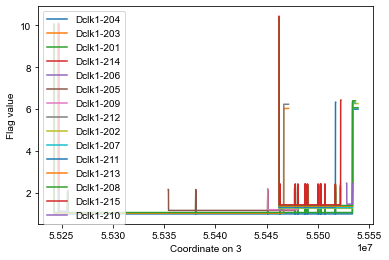

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Dclk1_id_transcript:ENSMUST00000196745_name_Dclk1-204_type_mRNA_strand_+_loc_3:55242364-55539068, size=7962
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Dclk1_id_transcript:ENSMUST00000167204_name_Dclk1-203_type_mRNA_strand_+_loc_3:55242526-55471316, size=6025
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Dclk1_id_transcript:ENSMUST00000054237_name_Dclk1-201_type_mRNA_strand_+_loc_3:55242526-55539064, size=7847
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Dclk1_id_transcript:ENSMUST00000200348_name_Dclk1-214_type_mRNA_strand_+_loc_3:55247071-55247483, size=413
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Dclk1_id_transcript:ENSMUST00000198154_name_Dclk1-206_type_lnc_RNA_strand_+_loc_3:55

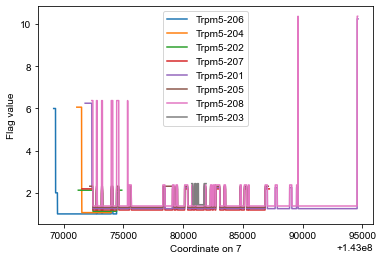

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Trpm5_id_transcript:ENSMUST00000148715_name_Trpm5-206_type_mRNA_strand_-_loc_7:143069153-143074561, size=726
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Trpm5_id_transcript:ENSMUST00000136602_name_Trpm5-204_type_mRNA_strand_-_loc_7:143071091-143074037, size=622
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Trpm5_id_transcript:ENSMUST00000126776_name_Trpm5-202_type_lnc_RNA_strand_-_loc_7:143071217-143074853, size=1925
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Trpm5_id_transcript:ENSMUST00000150589_name_Trpm5-207_type_lnc_RNA_strand_-_loc_7:143071529-143087214, size=3997
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Trpm5_id_transcript:ENSMUST00000009390_name_Trpm5-201_type_mRNA_strand_

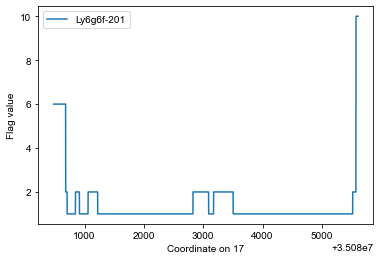

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Ly6g6f_id_transcript:ENSMUST00000038507_name_Ly6g6f-201_type_mRNA_strand_-_loc_17:35080480-35085610, size=1141
- find mRNA for gene: Avil


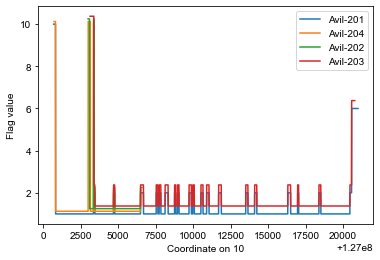

-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Avil_id_transcript:ENSMUST00000026500_name_Avil-201_type_mRNA_strand_+_loc_10:127000709-127020994, size=3033
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Avil_id_transcript:ENSMUST00000142698_name_Avil-204_type_mRNA_strand_+_loc_10:127000739-127006516, size=419
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Avil_id_transcript:ENSMUST00000126816_name_Avil-202_type_mRNA_strand_+_loc_10:127003001-127006588, size=350
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Avil_id_transcript:ENSMUST00000129173_name_Avil-203_type_mRNA_strand_+_loc_10:127003135-127020778, size=2925
- find mRNA for gene: Alox5ap


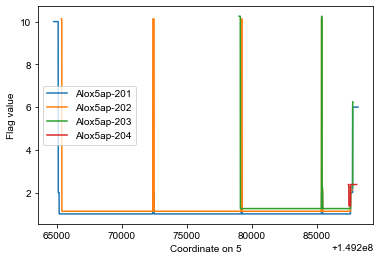

-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Alox5ap_id_transcript:ENSMUST00000071130_name_Alox5ap-201_type_mRNA_strand_+_loc_5:149264767-149288153, size=1251
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Alox5ap_id_transcript:ENSMUST00000200806_name_Alox5ap-202_type_mRNA_strand_+_loc_5:149265347-149287727, size=452
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Alox5ap_id_transcript:ENSMUST00000200928_name_Alox5ap-203_type_mRNA_strand_+_loc_5:149279011-149287750, size=356
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Alox5ap_id_transcript:ENSMUST00000202629_name_Alox5ap-204_type_lnc_RNA_strand_+_loc_5:149287415-149288044, size=504
- find mRNA for gene: Hck


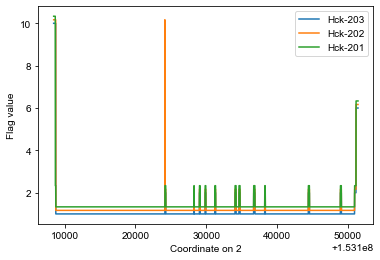

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Hck_id_transcript:ENSMUST00000189688_name_Hck-203_type_mRNA_strand_+_loc_2:153108468-153151439, size=2090
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Hck_id_transcript:ENSMUST00000109799_name_Hck-202_type_mRNA_strand_+_loc_2:153108468-153151441, size=2092
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Hck_id_transcript:ENSMUST00000003370_name_Hck-201_type_mRNA_strand_+_loc_2:153108468-153151441, size=2092
- find mRNA for gene: Plk2


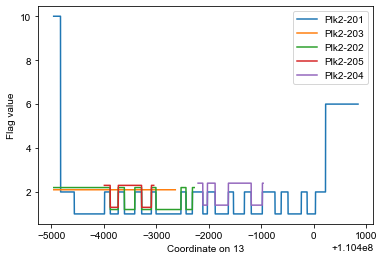

-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Plk2_id_transcript:ENSMUST00000022212_name_Plk2-201_type_mRNA_strand_+_loc_13:110395046-110400844, size=2800
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Plk2_id_transcript:ENSMUST00000224489_name_Plk2-203_type_lnc_RNA_strand_+_loc_13:110395048-110397363, size=2316
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Plk2_id_transcript:ENSMUST00000223756_name_Plk2-202_type_lnc_RNA_strand_+_loc_13:110395048-110397724, size=1543
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Plk2_id_transcript:ENSMUST00000225340_name_Plk2-205_type_lnc_RNA_strand_+_loc_13:110396012-110396952, size=602
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Plk2_id_transcript:ENSMUST00000225156_name_Plk2-204_type_lnc_RNA_s

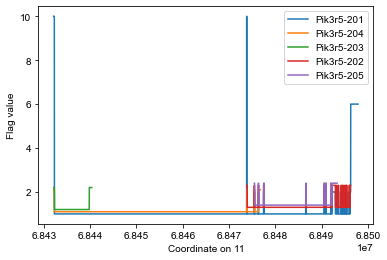

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pik3r5_id_transcript:ENSMUST00000021283_name_Pik3r5-201_type_mRNA_strand_+_loc_11:68432121-68497849, size=4370
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pik3r5_id_transcript:ENSMUST00000154220_name_Pik3r5-204_type_lnc_RNA_strand_+_loc_11:68432125-68476764, size=815
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pik3r5_id_transcript:ENSMUST00000141716_name_Pik3r5-203_type_lnc_RNA_strand_+_loc_11:68432160-68440372, size=676
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pik3r5_id_transcript:ENSMUST00000126876_name_Pik3r5-202_type_lnc_RNA_strand_+_loc_11:68473795-68496249, size=2625
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pik3r5_id_transcript:ENSMUST00000155887_name_Pik3r5-205_typ

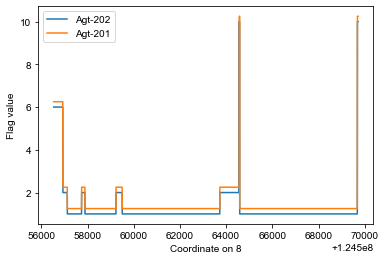

-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Agt_id_transcript:ENSMUST00000238882_name_Agt-202_type_mRNA_strand_-_loc_8:124556534-124569706, size=1891
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Agt_id_transcript:ENSMUST00000063278_name_Agt-201_type_mRNA_strand_-_loc_8:124556534-124569706, size=1891
- find mRNA for gene: Nrgn


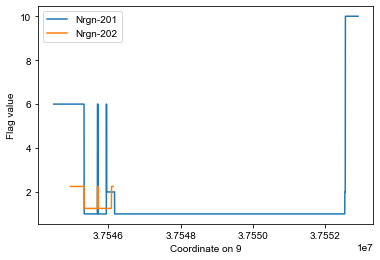

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Nrgn_id_transcript:ENSMUST00000065668_name_Nrgn-201_type_mRNA_strand_-_loc_9:37544492-37552904, size=1453
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Nrgn_id_transcript:ENSMUST00000182070_name_Nrgn-202_type_lnc_RNA_strand_-_loc_9:37544954-37546138, size=447
- find mRNA for gene: Plac8


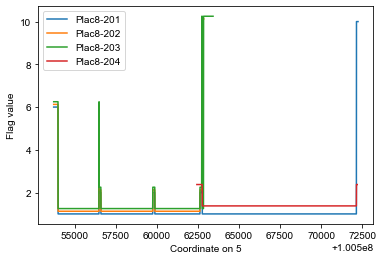

-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Plac8_id_transcript:ENSMUST00000031264_name_Plac8-201_type_mRNA_strand_-_loc_5:100553725-100572245, size=744
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Plac8_id_transcript:ENSMUST00000097437_name_Plac8-202_type_mRNA_strand_-_loc_5:100553726-100562858, size=738
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Plac8_id_transcript:ENSMUST00000112910_name_Plac8-203_type_mRNA_strand_-_loc_5:100553727-100563423, size=1224
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Plac8_id_transcript:ENSMUST00000144595_name_Plac8-204_type_lnc_RNA_strand_-_loc_5:100562438-100572192, size=373
- find mRNA for gene: Fxyd6


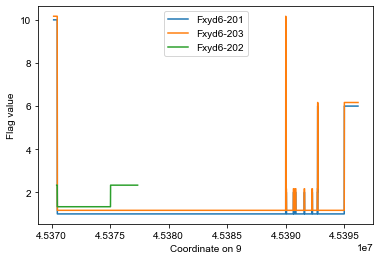

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Fxyd6_id_transcript:ENSMUST00000085939_name_Fxyd6-201_type_mRNA_strand_+_loc_9:45370185-45396155, size=1788
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Fxyd6_id_transcript:ENSMUST00000217381_name_Fxyd6-203_type_mRNA_strand_+_loc_9:45370185-45396159, size=1789
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Fxyd6_id_transcript:ENSMUST00000215281_name_Fxyd6-202_type_lnc_RNA_strand_+_loc_9:45370442-45377348, size=2362
- find mRNA for gene: Pou2f3


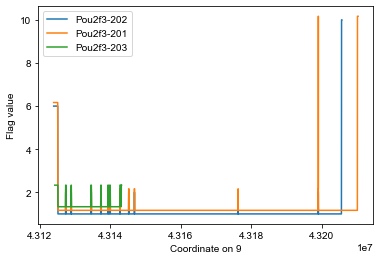

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Pou2f3_id_transcript:ENSMUST00000176636_name_Pou2f3-202_type_mRNA_strand_-_loc_9:43123939-43205755, size=2522
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Pou2f3_id_transcript:ENSMUST00000034513_name_Pou2f3-201_type_mRNA_strand_-_loc_9:43123939-43210369, size=2610
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Pou2f3_id_transcript:ENSMUST00000213862_name_Pou2f3-203_type_lnc_RNA_strand_-_loc_9:43124242-43143204, size=2181
- find mRNA for gene: Ccl20


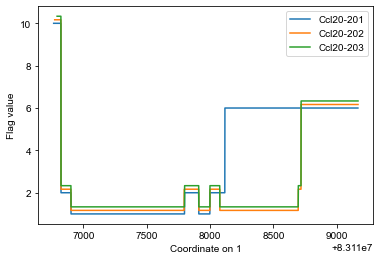

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Ccl20_id_transcript:ENSMUST00000027351_name_Ccl20-201_type_mRNA_strand_+_loc_1:83116766-83119166, size=1417
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Ccl20_id_transcript:ENSMUST00000113437_name_Ccl20-202_type_mRNA_strand_+_loc_1:83116774-83119167, size=794
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Ccl20_id_transcript:ENSMUST00000186832_name_Ccl20-203_type_mRNA_strand_+_loc_1:83116793-83119167, size=772
- find mRNA for gene: Ccl9


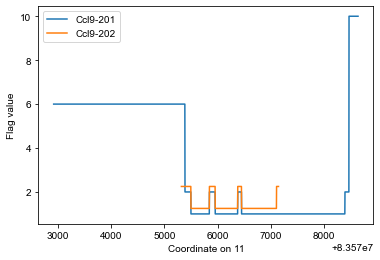

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl9_id_transcript:ENSMUST00000019266_name_Ccl9-201_type_mRNA_strand_-_loc_11:83572919-83578636, size=3006
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl9_id_transcript:ENSMUST00000136131_name_Ccl9-202_type_lnc_RNA_strand_-_loc_11:83575318-83577142, size=398
- find mRNA for gene: Ccl6


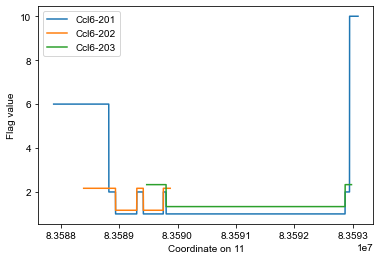

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl6_id_transcript:ENSMUST00000019071_name_Ccl6-201_type_mRNA_strand_-_loc_11:83587882-83593087, size=1440
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl6_id_transcript:ENSMUST00000138145_name_Ccl6-202_type_lnc_RNA_strand_-_loc_11:83588395-83589875, size=776
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl6_id_transcript:ENSMUST00000150243_name_Ccl6-203_type_lnc_RNA_strand_-_loc_11:83589473-83592975, size=442
- find mRNA for gene: Rnase1


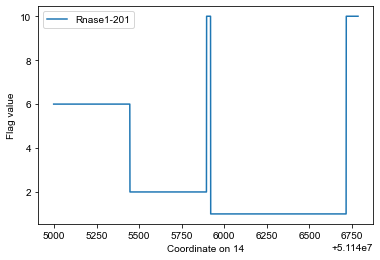

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Rnase1_id_transcript:ENSMUST00000080126_name_Rnase1-201_type_mRNA_strand_-_loc_14:51144998-51146785, size=992
- find mRNA for gene: Gp2


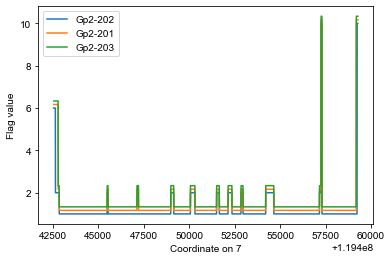

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Gp2_id_transcript:ENSMUST00000207887_name_Gp2-202_type_mRNA_strand_-_loc_7:119442537-119459270, size=1853
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Gp2_id_transcript:ENSMUST00000033255_name_Gp2-201_type_mRNA_strand_-_loc_7:119442542-119459285, size=1993
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Gp2_id_transcript:ENSMUST00000239424_name_Gp2-203_type_mRNA_strand_-_loc_7:119442544-119459272, size=1978
- find mRNA for gene: Fabp1


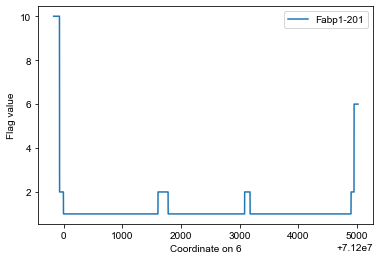

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Fabp1_id_transcript:ENSMUST00000067492_name_Fabp1-201_type_mRNA_strand_+_loc_6:71199827-71205023, size=553
- find mRNA for gene: Sox8


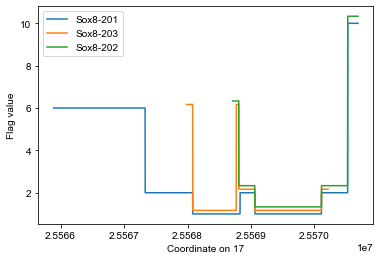

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Sox8_id_transcript:ENSMUST00000025003_name_Sox8-201_type_mRNA_strand_-_loc_17:25565892-25570686, size=3000
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Sox8_id_transcript:ENSMUST00000174560_name_Sox8-203_type_mRNA_strand_-_loc_17:25567988-25570214, size=492
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Sox8_id_transcript:ENSMUST00000173447_name_Sox8-202_type_mRNA_strand_-_loc_17:25568710-25570686, size=928
- find mRNA for gene: Spib


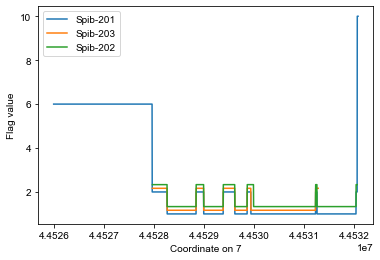

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Spib_id_transcript:ENSMUST00000035323_name_Spib-201_type_mRNA_strand_-_loc_7:44525993-44532071, size=2788
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Spib_id_transcript:ENSMUST00000205506_name_Spib-203_type_mRNA_strand_-_loc_7:44527964-44531276, size=802
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Spib_id_transcript:ENSMUST00000098483_name_Spib-202_type_mRNA_strand_-_loc_7:44527964-44532053, size=853
- find mRNA for gene: Fxyd3


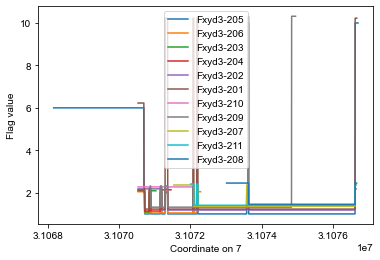

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Fxyd3_id_transcript:ENSMUST00000167369_name_Fxyd3-205_type_mRNA_strand_-_loc_7:31068172-31076704, size=2894
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Fxyd3_id_transcript:ENSMUST00000169313_name_Fxyd3-206_type_lnc_RNA_strand_-_loc_7:31070535-31072289, size=469
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Fxyd3_id_transcript:ENSMUST00000165465_name_Fxyd3-203_type_lnc_RNA_strand_-_loc_7:31070537-31071037, size=370
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Fxyd3_id_transcript:ENSMUST00000165862_name_Fxyd3-204_type_lnc_RNA_strand_-_loc_7:31070537-31071459, size=520
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Fxyd3_id_transcript:ENSMUST00000165265_name_Fxyd3-202_type_lnc_RNA_strand_-_l

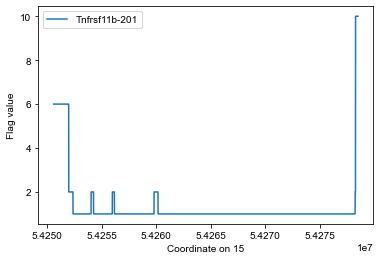

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Tnfrsf11b_id_transcript:ENSMUST00000079772_name_Tnfrsf11b-201_type_mRNA_strand_-_loc_15:54250619-54278484, size=2818
- find mRNA for gene: Ifi27l2b


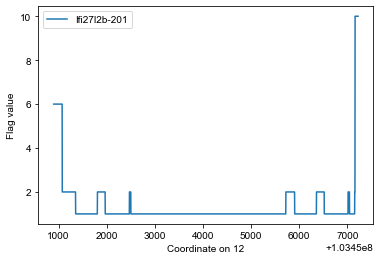

-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Ifi27l2b_id_transcript:ENSMUST00000044687_name_Ifi27l2b-201_type_mRNA_strand_-_loc_12:103450898-103457223, size=1093
- find mRNA for gene: Guca2a


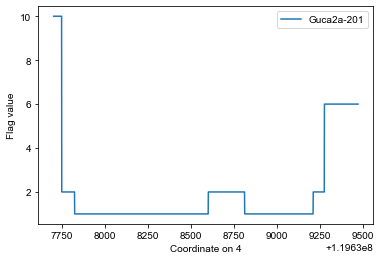

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Guca2a_id_transcript:ENSMUST00000024015_name_Guca2a-201_type_mRNA_strand_+_loc_4:119637704-119639471, size=594
- find mRNA for gene: Pigr


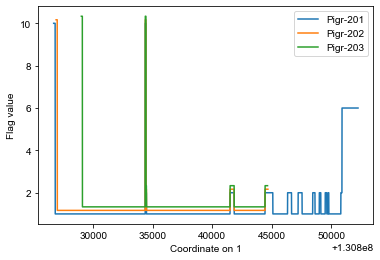

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Pigr_id_transcript:ENSMUST00000027675_name_Pigr-201_type_mRNA_strand_+_loc_1:130826684-130852249, size=3849
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Pigr_id_transcript:ENSMUST00000133792_name_Pigr-202_type_mRNA_strand_+_loc_1:130826888-130844680, size=784
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Pigr_id_transcript:ENSMUST00000137782_name_Pigr-203_type_mRNA_strand_+_loc_1:130829010-130844648, size=740
- find mRNA for gene: Muc13


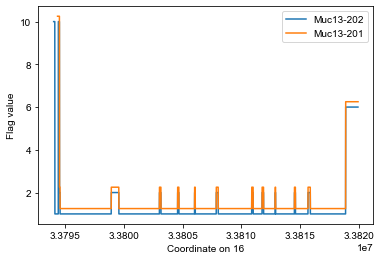

-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Muc13_id_transcript:ENSMUST00000115044_name_Muc13-202_type_mRNA_strand_+_loc_16:33794037-33819927, size=2969
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Muc13_id_transcript:ENSMUST00000023520_name_Muc13-201_type_mRNA_strand_+_loc_16:33794367-33819934, size=2942
- find mRNA for gene: Saa1


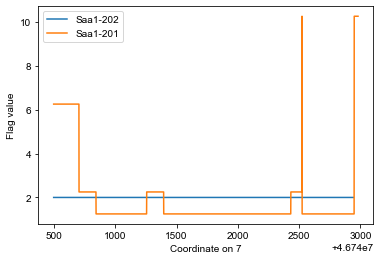

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Saa1_id_transcript:ENSMUST00000210547_name_Saa1-202_type_lnc_RNA_strand_-_loc_7:46740497-46742942, size=2446
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Saa1_id_transcript:ENSMUST00000128088_name_Saa1-201_type_mRNA_strand_-_loc_7:46740497-46742980, size=609
- find mRNA for gene: Aldob


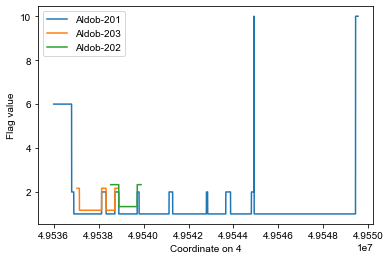

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Aldob_id_transcript:ENSMUST00000029987_name_Aldob-201_type_mRNA_strand_-_loc_4:49535995-49549546, size=2016
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Aldob_id_transcript:ENSMUST00000148415_name_Aldob-203_type_lnc_RNA_strand_-_loc_4:49537034-49538866, size=454
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Aldob_id_transcript:ENSMUST00000144372_name_Aldob-202_type_lnc_RNA_strand_-_loc_4:49538537-49539886, size=530
- find mRNA for gene: Lgals2


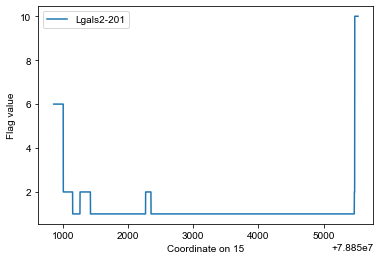

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Lgals2_id_transcript:ENSMUST00000044584_name_Lgals2-201_type_mRNA_strand_-_loc_15:78850860-78855529, size=592
- find mRNA for gene: Gsta2


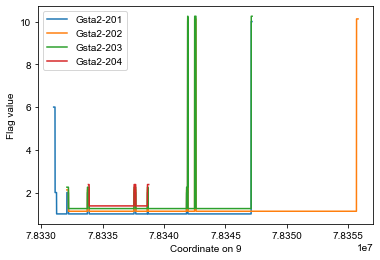

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Gsta2_id_transcript:ENSMUST00000034902_name_Gsta2-201_type_mRNA_strand_-_loc_9:78331018-78347158, size=870
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Gsta2_id_transcript:ENSMUST00000125479_name_Gsta2-202_type_mRNA_strand_-_loc_9:78332087-78355788, size=809
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Gsta2_id_transcript:ENSMUST00000129247_name_Gsta2-203_type_mRNA_strand_-_loc_9:78332095-78347168, size=751
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Gsta2_id_transcript:ENSMUST00000140498_name_Gsta2-204_type_lnc_RNA_strand_-_loc_9:78333847-78338752, size=297
- find mRNA for gene: Lcn2


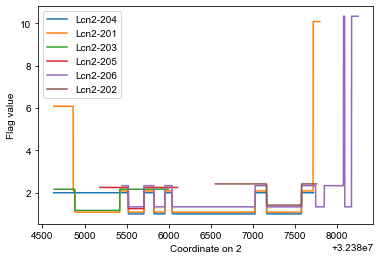

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Lcn2_id_transcript:ENSMUST00000147219_name_Lcn2-204_type_lnc_RNA_strand_-_loc_2:32384633-32387722, size=1374
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Lcn2_id_transcript:ENSMUST00000050785_name_Lcn2-201_type_mRNA_strand_-_loc_2:32384633-32387797, size=915
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Lcn2_id_transcript:ENSMUST00000144569_name_Lcn2-203_type_lnc_RNA_strand_-_loc_2:32384639-32385999, size=827
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Lcn2_id_transcript:ENSMUST00000155830_name_Lcn2-205_type_lnc_RNA_strand_-_loc_2:32385183-32386107, size=740
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Lcn2_id_transcript:ENSMUST00000192241_name_Lcn2-206_type_mRNA_strand_-_loc_2:32385445

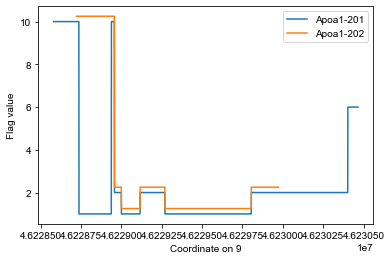

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Apoa1_id_transcript:ENSMUST00000034588_name_Apoa1-201_type_mRNA_strand_+_loc_9:46228580-46230466, size=1035
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Apoa1_id_transcript:ENSMUST00000132155_name_Apoa1-202_type_mRNA_strand_+_loc_9:46228721-46229973, size=602
- find mRNA for gene: Hnf4a


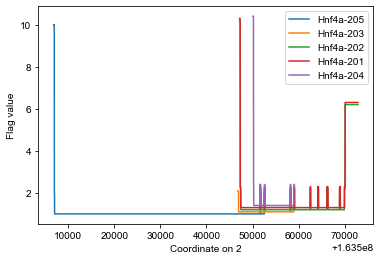

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Hnf4a_id_transcript:ENSMUST00000143911_name_Hnf4a-205_type_mRNA_strand_+_loc_2:163506808-163552635, size=431
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Hnf4a_id_transcript:ENSMUST00000131658_name_Hnf4a-203_type_lnc_RNA_strand_+_loc_2:163546817-163559110, size=659
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Hnf4a_id_transcript:ENSMUST00000109411_name_Hnf4a-202_type_mRNA_strand_+_loc_2:163547187-163572910, size=4362
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Hnf4a_id_transcript:ENSMUST00000018094_name_Hnf4a-201_type_mRNA_strand_+_loc_2:163547188-163572905, size=4356
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Hnf4a_id_transcript:ENSMUST00000137449_name_Hnf4a-204_type_mRNA_strand_+_l

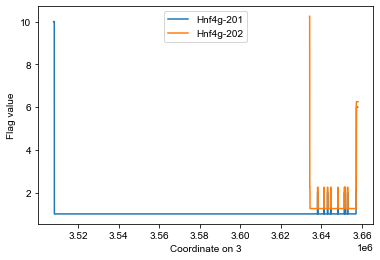

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Hnf4g_id_transcript:ENSMUST00000108393_name_Hnf4g-201_type_mRNA_strand_+_loc_3:3508030-3657844, size=2224
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Hnf4g_id_transcript:ENSMUST00000108394_name_Hnf4g-202_type_mRNA_strand_+_loc_3:3634150-3658052, size=2327
- find mRNA for gene: Igf1


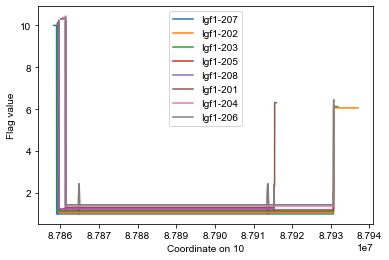

-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Igf1_id_transcript:ENSMUST00000122386_name_Igf1-207_type_mRNA_strand_+_loc_10:87858265-87930895, size=1391
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Igf1_id_transcript:ENSMUST00000095360_name_Igf1-202_type_mRNA_strand_+_loc_10:87859068-87937042, size=7052
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Igf1_id_transcript:ENSMUST00000105300_name_Igf1-203_type_mRNA_strand_+_loc_10:87859258-87931801, size=1673
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Igf1_id_transcript:ENSMUST00000121952_name_Igf1-205_type_mRNA_strand_+_loc_10:87859490-87930893, size=798
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Igf1_id_transcript:ENSMUST00000126490_name_Igf1-208_type_mRNA_strand_+_loc_10:87859

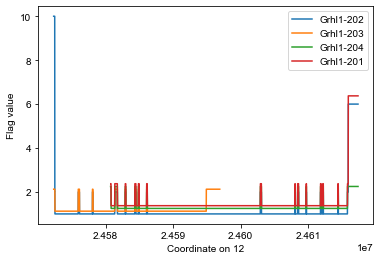

-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Grhl1_id_transcript:ENSMUST00000085553_name_Grhl1-202_type_mRNA_strand_+_loc_12:24572283-24617388, size=3469
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Grhl1_id_transcript:ENSMUST00000221426_name_Grhl1-203_type_lnc_RNA_strand_+_loc_12:24572287-24596897, size=3267
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Grhl1_id_transcript:ENSMUST00000223442_name_Grhl1-204_type_lnc_RNA_strand_+_loc_12:24580719-24617391, size=3100
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Grhl1_id_transcript:ENSMUST00000020985_name_Grhl1-201_type_mRNA_strand_+_loc_12:24580749-24617391, size=3070
- find mRNA for gene: Lypd3


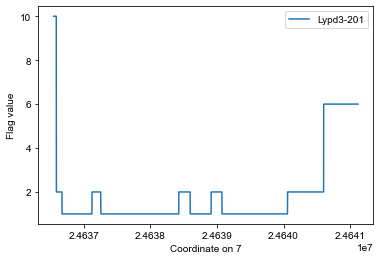

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Lypd3_id_transcript:ENSMUST00000080718_name_Lypd3-201_type_mRNA_strand_+_loc_7:24636550-24641118, size=1649
- find mRNA for gene: Krtdap


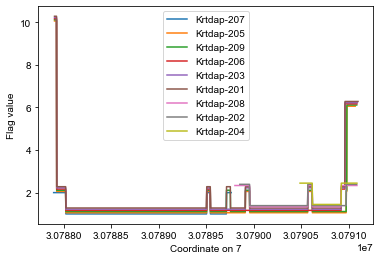

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Krtdap_id_transcript:ENSMUST00000190480_name_Krtdap-207_type_lnc_RNA_strand_+_loc_7:30787896-30789763, size=217
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Krtdap_id_transcript:ENSMUST00000189673_name_Krtdap-205_type_mRNA_strand_+_loc_7:30787905-30791067, size=345
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Krtdap_id_transcript:ENSMUST00000190990_name_Krtdap-209_type_mRNA_strand_+_loc_7:30787905-30791083, size=403
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Krtdap_id_transcript:ENSMUST00000189962_name_Krtdap-206_type_mRNA_strand_+_loc_7:30787905-30791085, size=323
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Krtdap_id_transcript:ENSMUST00000187493_name_Krtdap-203_type_mRNA_strand_+_l

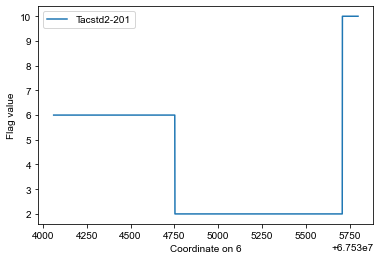

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Tacstd2_id_transcript:ENSMUST00000058178_name_Tacstd2-201_type_mRNA_strand_-_loc_6:67534062-67535796, size=1735
- find mRNA for gene: Krt16


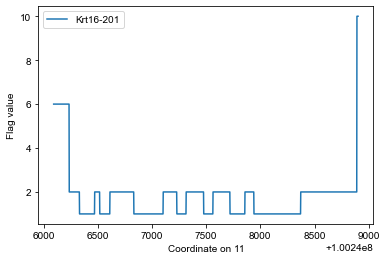

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt16_id_transcript:ENSMUST00000007280_name_Krt16-201_type_mRNA_strand_-_loc_11:100246091-100248902, size=1565
- find mRNA for gene: Pdzk1ip1


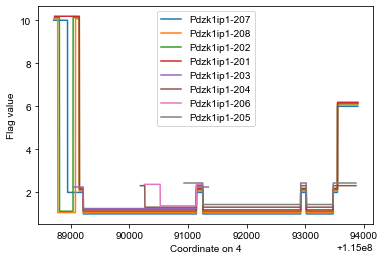

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Pdzk1ip1_id_transcript:ENSMUST00000171877_name_Pdzk1ip1-207_type_mRNA_strand_+_loc_4:115088708-115093894, size=1129
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Pdzk1ip1_id_transcript:ENSMUST00000177647_name_Pdzk1ip1-208_type_mRNA_strand_+_loc_4:115088708-115093894, size=826
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Pdzk1ip1_id_transcript:ENSMUST00000106548_name_Pdzk1ip1-202_type_mRNA_strand_+_loc_4:115088723-115093899, size=887
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Pdzk1ip1_id_transcript:ENSMUST00000030488_name_Pdzk1ip1-201_type_mRNA_strand_+_loc_4:115088723-115093899, size=1119
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Pdzk1ip1_id_transcript:ENSMUST00000124491_name_Pdzk1i

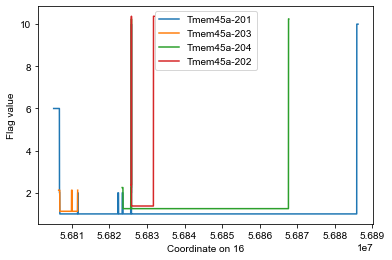

-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Tmem45a_id_transcript:ENSMUST00000023435_name_Tmem45a-201_type_mRNA_strand_-_loc_16:56805161-56886166, size=2701
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Tmem45a_id_transcript:ENSMUST00000148452_name_Tmem45a-203_type_lnc_RNA_strand_-_loc_16:56806490-56811549, size=484
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Tmem45a_id_transcript:ENSMUST00000232373_name_Tmem45a-204_type_mRNA_strand_-_loc_16:56823390-56867715, size=471
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Tmem45a_id_transcript:ENSMUST00000135672_name_Tmem45a-202_type_mRNA_strand_-_loc_16:56825714-56831885, size=327
- find mRNA for gene: Krt10


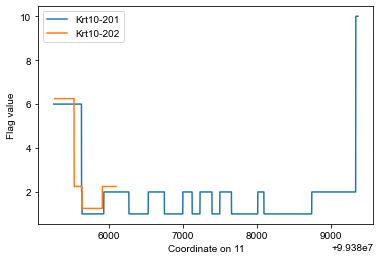

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt10_id_transcript:ENSMUST00000103131_name_Krt10-201_type_mRNA_strand_-_loc_11:99385254-99389364, size=2094
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt10_id_transcript:ENSMUST00000211768_name_Krt10-202_type_mRNA_strand_-_loc_11:99385267-99386097, size=557
- find mRNA for gene: Gm94


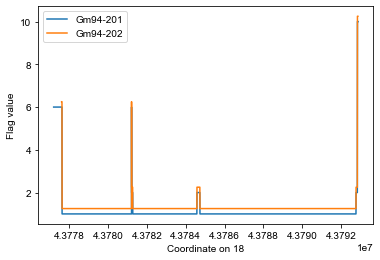

-- searching among 1 references
-- a match found in record: 18.
-- extracting transcript for gene_Gm94_id_transcript:ENSMUST00000096570_name_Gm94-201_type_mRNA_strand_-_loc_18:43777196-43792878, size=748
-- searching among 1 references
-- a match found in record: 18.
-- extracting transcript for gene_Gm94_id_transcript:ENSMUST00000237926_name_Gm94-202_type_mRNA_strand_-_loc_18:43777604-43792867, size=326
- find mRNA for gene: Acpp


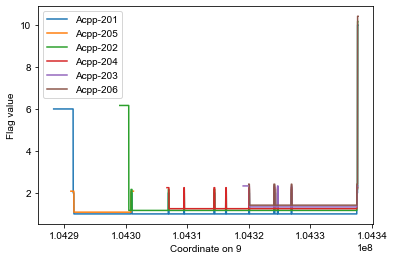

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Acpp_id_transcript:ENSMUST00000062723_name_Acpp-201_type_mRNA_strand_-_loc_9:104288251-104337728, size=4483
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Acpp_id_transcript:ENSMUST00000131084_name_Acpp-205_type_lnc_RNA_strand_-_loc_9:104291049-104301225, size=891
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Acpp_id_transcript:ENSMUST00000112590_name_Acpp-202_type_mRNA_strand_-_loc_9:104299000-104337707, size=2652
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Acpp_id_transcript:ENSMUST00000128635_name_Acpp-204_type_lnc_RNA_strand_-_loc_9:104306674-104337682, size=1199
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Acpp_id_transcript:ENSMUST00000125800_name_Acpp-203_type_lnc_RNA_strand_-_loc_

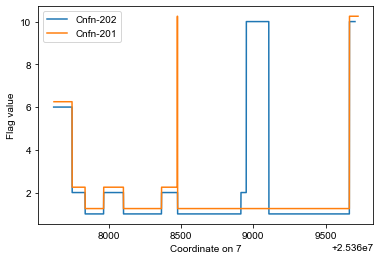

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Cnfn_id_transcript:ENSMUST00000167591_name_Cnfn-202_type_mRNA_strand_-_loc_7:25367620-25369703, size=698
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Cnfn_id_transcript:ENSMUST00000076276_name_Cnfn-201_type_mRNA_strand_-_loc_7:25367622-25369724, size=524
- find mRNA for gene: Fam25c


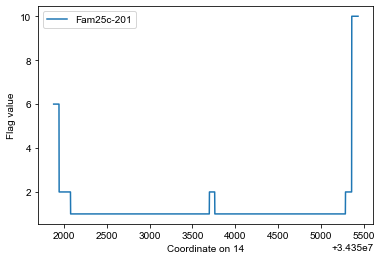

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Fam25c_id_transcript:ENSMUST00000052126_name_Fam25c-201_type_mRNA_strand_-_loc_14:34351881-34355433, size=408
- find mRNA for gene: Elovl4


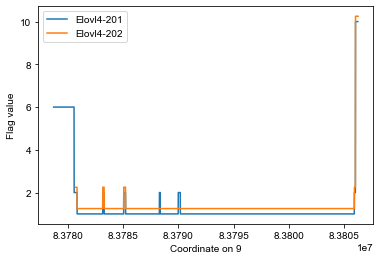

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Elovl4_id_transcript:ENSMUST00000034796_name_Elovl4-201_type_mRNA_strand_-_loc_9:83778692-83806252, size=3001
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Elovl4_id_transcript:ENSMUST00000183614_name_Elovl4-202_type_mRNA_strand_-_loc_9:83780663-83806277, size=782
- find mRNA for gene: Efna3


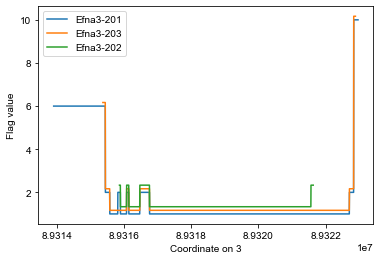

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Efna3_id_transcript:ENSMUST00000029673_name_Efna3-201_type_mRNA_strand_-_loc_3:89313899-89322965, size=2363
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Efna3_id_transcript:ENSMUST00000200436_name_Efna3-203_type_mRNA_strand_-_loc_3:89315364-89322887, size=742
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Efna3_id_transcript:ENSMUST00000139439_name_Efna3-202_type_lnc_RNA_strand_-_loc_3:89315859-89321631, size=454
- find mRNA for gene: Cebpb


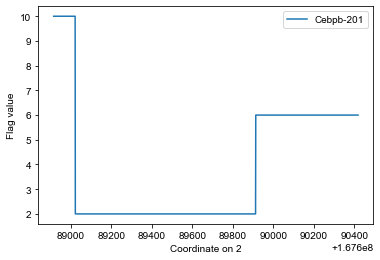

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Cebpb_id_transcript:ENSMUST00000070642_name_Cebpb-201_type_mRNA_strand_+_loc_2:167688915-167690418, size=1504
- find mRNA for gene: Ly6d


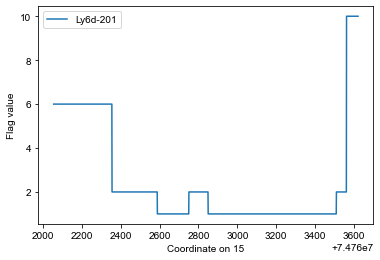

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6d_id_transcript:ENSMUST00000040404_name_Ly6d-201_type_mRNA_strand_-_loc_15:74762056-74763620, size=744
- find mRNA for gene: Gsta4


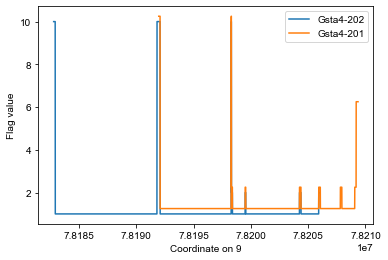

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Gsta4_id_transcript:ENSMUST00000213215_name_Gsta4-202_type_mRNA_strand_+_loc_9:78182774-78205955, size=743
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Gsta4_id_transcript:ENSMUST00000034903_name_Gsta4-201_type_mRNA_strand_+_loc_9:78191947-78209349, size=977
- find mRNA for gene: Serpinb11


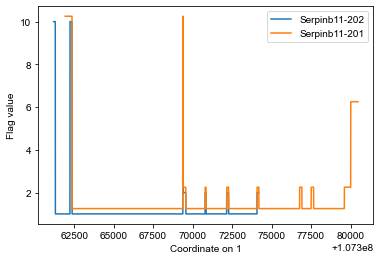

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Serpinb11_id_transcript:ENSMUST00000191425_name_Serpinb11-202_type_mRNA_strand_+_loc_1:107361198-107374182, size=707
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Serpinb11_id_transcript:ENSMUST00000027566_name_Serpinb11-201_type_mRNA_strand_+_loc_1:107361929-107380475, size=2084
- find mRNA for gene: Gabrp


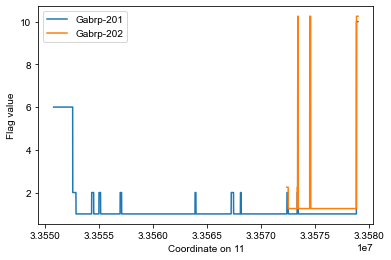

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Gabrp_id_transcript:ENSMUST00000020366_name_Gabrp-201_type_mRNA_strand_-_loc_11:33550781-33578957, size=3280
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Gabrp_id_transcript:ENSMUST00000135350_name_Gabrp-202_type_mRNA_strand_-_loc_11:33572371-33578959, size=467
- find mRNA for gene: Cyp2f2


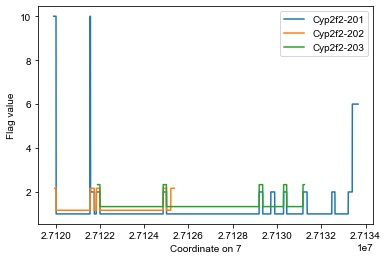

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Cyp2f2_id_transcript:ENSMUST00000003100_name_Cyp2f2-201_type_mRNA_strand_+_loc_7:27119909-27133660, size=1866
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Cyp2f2_id_transcript:ENSMUST00000133841_name_Cyp2f2-202_type_lnc_RNA_strand_+_loc_7:27119961-27125357, size=718
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Cyp2f2_id_transcript:ENSMUST00000206552_name_Cyp2f2-203_type_mRNA_strand_+_loc_7:27121892-27131236, size=626
- find mRNA for gene: Gsto1


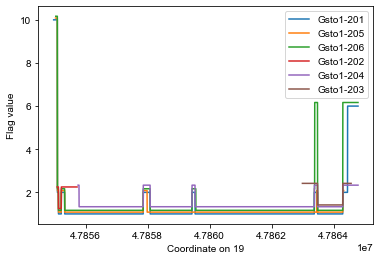

-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Gsto1_id_transcript:ENSMUST00000026050_name_Gsto1-201_type_mRNA_strand_+_loc_19:47854970-47864790, size=1182
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Gsto1_id_transcript:ENSMUST00000237121_name_Gsto1-205_type_mRNA_strand_+_loc_19:47855030-47864327, size=384
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Gsto1_id_transcript:ENSMUST00000237472_name_Gsto1-206_type_mRNA_strand_+_loc_19:47855038-47864789, size=1138
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Gsto1_id_transcript:ENSMUST00000130157_name_Gsto1-202_type_lnc_RNA_strand_+_loc_19:47855083-47855725, size=551
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Gsto1_id_transcript:ENSMUST00000236902_name_Gsto1-204_type_lnc_RNA_strand

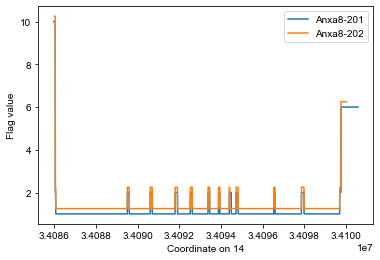

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Anxa8_id_transcript:ENSMUST00000022519_name_Anxa8-201_type_mRNA_strand_+_loc_14:34085981-34100571, size=1880
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Anxa8_id_transcript:ENSMUST00000120077_name_Anxa8-202_type_mRNA_strand_+_loc_14:34086025-34100021, size=1208
- find mRNA for gene: Mlph


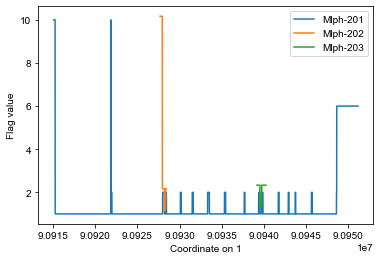

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Mlph_id_transcript:ENSMUST00000027528_name_Mlph-201_type_mRNA_strand_+_loc_1:90915085-90951142, size=4499
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Mlph_id_transcript:ENSMUST00000125149_name_Mlph-202_type_mRNA_strand_+_loc_1:90927679-90928432, size=636
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Mlph_id_transcript:ENSMUST00000136220_name_Mlph-203_type_lnc_RNA_strand_+_loc_1:90939169-90940239, size=863
- find mRNA for gene: Cd14


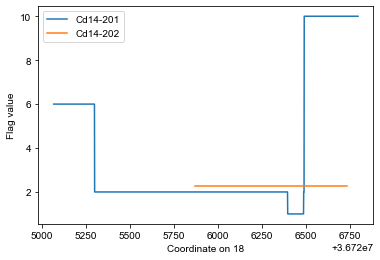

-- searching among 1 references
-- a match found in record: 18.
-- extracting transcript for gene_Cd14_id_transcript:ENSMUST00000061829_name_Cd14-201_type_mRNA_strand_-_loc_18:36725067-36726798, size=1641
-- searching among 1 references
-- a match found in record: 18.
-- extracting transcript for gene_Cd14_id_transcript:ENSMUST00000237042_name_Cd14-202_type_lnc_RNA_strand_-_loc_18:36725871-36726738, size=868
- find mRNA for gene: Foxa1


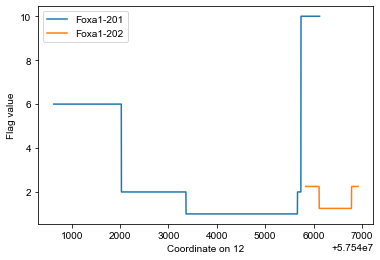

-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Foxa1_id_transcript:ENSMUST00000044380_name_Foxa1-201_type_mRNA_strand_-_loc_12:57540628-57546121, size=3191
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Foxa1_id_transcript:ENSMUST00000218398_name_Foxa1-202_type_lnc_RNA_strand_-_loc_12:57545834-57546916, size=414
- find mRNA for gene: Ttc36


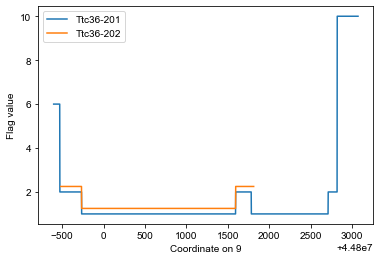

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Ttc36_id_transcript:ENSMUST00000044694_name_Ttc36-201_type_mRNA_strand_-_loc_9:44799397-44803072, size=888
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Ttc36_id_transcript:ENSMUST00000216449_name_Ttc36-202_type_lnc_RNA_strand_-_loc_9:44799483-44801812, size=470
- find mRNA for gene: Foxj1


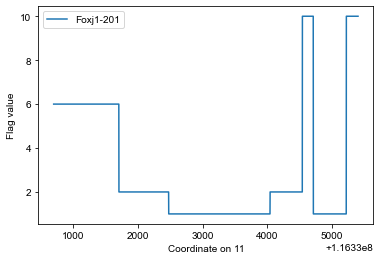

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Foxj1_id_transcript:ENSMUST00000036215_name_Foxj1-201_type_mRNA_strand_-_loc_11:116330704-116335399, size=2623
- find mRNA for gene: Fam183b


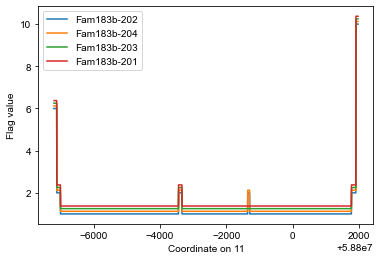

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Fam183b_id_transcript:ENSMUST00000094156_name_Fam183b-202_type_mRNA_strand_-_loc_11:58792797-58801960, size=567
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Fam183b_id_transcript:ENSMUST00000239007_name_Fam183b-204_type_mRNA_strand_-_loc_11:58792803-58801960, size=561
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Fam183b_id_transcript:ENSMUST00000238886_name_Fam183b-203_type_mRNA_strand_-_loc_11:58792803-58801960, size=501
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Fam183b_id_transcript:ENSMUST00000060581_name_Fam183b-201_type_mRNA_strand_-_loc_11:58792811-58801960, size=493
- find mRNA for gene: Ccdc30


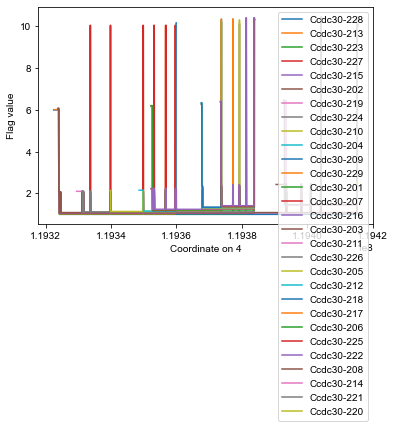

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Ccdc30_id_transcript:ENSMUST00000238759_name_Ccdc30-228_type_mRNA_strand_-_loc_4:119322466-119415521, size=3909
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Ccdc30_id_transcript:ENSMUST00000154606_name_Ccdc30-213_type_mRNA_strand_-_loc_4:119322893-119359895, size=2724
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Ccdc30_id_transcript:ENSMUST00000238697_name_Ccdc30-223_type_mRNA_strand_-_loc_4:119323839-119381298, size=2317
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Ccdc30_id_transcript:ENSMUST00000238723_name_Ccdc30-227_type_mRNA_strand_-_loc_4:119323842-119383760, size=1707
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Ccdc30_id_transcript:ENSMUST00000238293_name_Ccdc30-215_type_mRNA_s

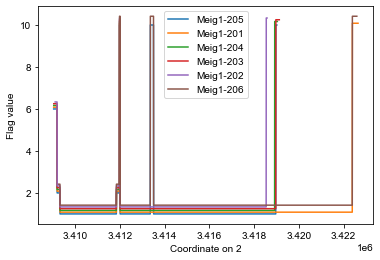

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Meig1_id_transcript:ENSMUST00000115084_name_Meig1-205_type_mRNA_strand_-_loc_2:3409043-3419019, size=643
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Meig1_id_transcript:ENSMUST00000064685_name_Meig1-201_type_mRNA_strand_-_loc_2:3409043-3422648, size=706
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Meig1_id_transcript:ENSMUST00000115083_name_Meig1-204_type_mRNA_strand_-_loc_2:3409046-3419041, size=567
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Meig1_id_transcript:ENSMUST00000115082_name_Meig1-203_type_mRNA_strand_-_loc_2:3409047-3419129, size=603
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Meig1_id_transcript:ENSMUST00000115081_name_Meig1-202_type_mRNA_strand_-_loc_2:3409110-3418581,

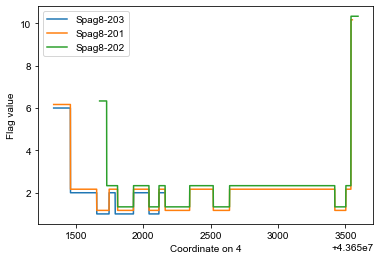

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Spag8_id_transcript:ENSMUST00000149575_name_Spag8-203_type_mRNA_strand_-_loc_4:43651335-43652159, size=523
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Spag8_id_transcript:ENSMUST00000084646_name_Spag8-201_type_mRNA_strand_-_loc_4:43651335-43653552, size=1549
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Spag8_id_transcript:ENSMUST00000107870_name_Spag8-202_type_mRNA_strand_-_loc_4:43651676-43653594, size=1342
- find mRNA for gene: Vpreb3


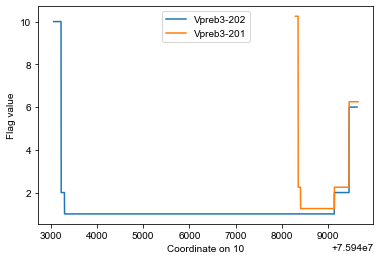

-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Vpreb3_id_transcript:ENSMUST00000121151_name_Vpreb3-202_type_mRNA_strand_+_loc_10:75943057-75949637, size=729
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Vpreb3_id_transcript:ENSMUST00000000926_name_Vpreb3-201_type_mRNA_strand_+_loc_10:75948300-75949657, size=625
- find mRNA for gene: Riiad1


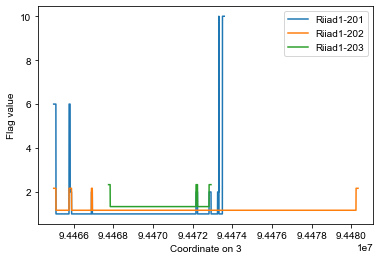

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Riiad1_id_transcript:ENSMUST00000029785_name_Riiad1-201_type_mRNA_strand_-_loc_3:94464983-94473591, size=630
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Riiad1_id_transcript:ENSMUST00000183915_name_Riiad1-202_type_lnc_RNA_strand_-_loc_3:94464985-94480341, size=389
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Riiad1_id_transcript:ENSMUST00000184619_name_Riiad1-203_type_lnc_RNA_strand_-_loc_3:94467754-94472922, size=257
- find mRNA for gene: Rsph1


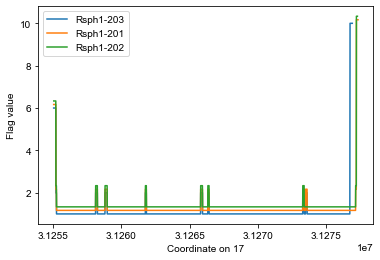

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Rsph1_id_transcript:ENSMUST00000236379_name_Rsph1-203_type_mRNA_strand_-_loc_17:31255019-31276961, size=1190
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Rsph1_id_transcript:ENSMUST00000024832_name_Rsph1-201_type_mRNA_strand_-_loc_17:31255019-31277383, size=1191
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Rsph1_id_transcript:ENSMUST00000235144_name_Rsph1-202_type_mRNA_strand_-_loc_17:31255025-31277338, size=1026
- find mRNA for gene: Odf3b


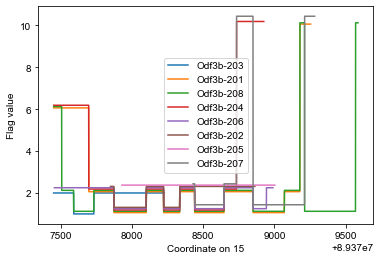

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Odf3b_id_transcript:ENSMUST00000227203_name_Odf3b-203_type_lnc_RNA_strand_-_loc_15:89377449-89378226, size=636
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Odf3b_id_transcript:ENSMUST00000049968_name_Odf3b-201_type_mRNA_strand_-_loc_15:89377449-89379254, size=1040
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Odf3b_id_transcript:ENSMUST00000238996_name_Odf3b-208_type_mRNA_strand_-_loc_15:89377449-89379587, size=873
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Odf3b_id_transcript:ENSMUST00000227834_name_Odf3b-204_type_mRNA_strand_-_loc_15:89377450-89378925, size=930
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Odf3b_id_transcript:ENSMUST00000228005_name_Odf3b-206_type_lnc_RNA_strand_

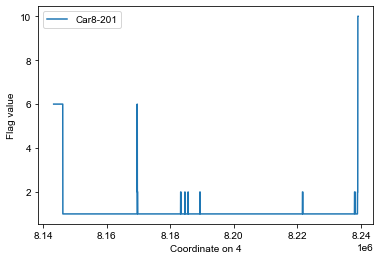

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Car8_id_transcript:ENSMUST00000066674_name_Car8-201_type_mRNA_strand_-_loc_4:8143362-8239041, size=3853
- find mRNA for gene: Rnase4


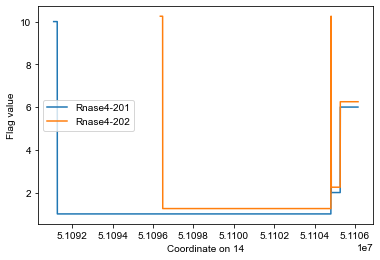

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Rnase4_id_transcript:ENSMUST00000022428_name_Rnase4-201_type_mRNA_strand_+_loc_14:51091077-51106147, size=1518
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Rnase4_id_transcript:ENSMUST00000169895_name_Rnase4-202_type_mRNA_strand_+_loc_14:51096359-51106151, size=1460
- find mRNA for gene: Tspan1


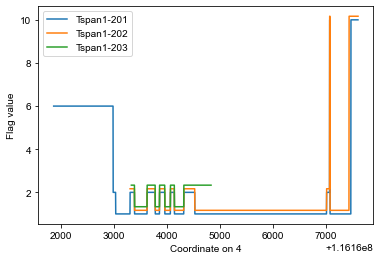

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Tspan1_id_transcript:ENSMUST00000030465_name_Tspan1-201_type_mRNA_strand_-_loc_4:116161869-116167600, size=1985
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Tspan1_id_transcript:ENSMUST00000143426_name_Tspan1-202_type_mRNA_strand_-_loc_4:116163308-116167601, size=853
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Tspan1_id_transcript:ENSMUST00000154534_name_Tspan1-203_type_lnc_RNA_strand_-_loc_4:116163332-116164833, size=901
- find mRNA for gene: Stxbp5l


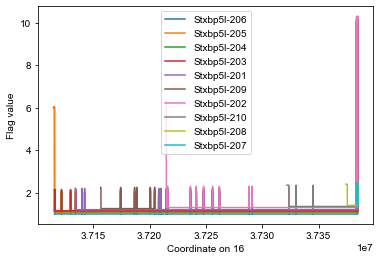

-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Stxbp5l_id_transcript:ENSMUST00000114787_name_Stxbp5l-206_type_mRNA_strand_-_loc_16:37114942-37384923, size=4394
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Stxbp5l_id_transcript:ENSMUST00000114782_name_Stxbp5l-205_type_mRNA_strand_-_loc_16:37115268-37384923, size=3996
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Stxbp5l_id_transcript:ENSMUST00000114781_name_Stxbp5l-204_type_mRNA_strand_-_loc_16:37115656-37384958, size=3544
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Stxbp5l_id_transcript:ENSMUST00000114780_name_Stxbp5l-203_type_mRNA_strand_-_loc_16:37115656-37384962, size=3476
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Stxbp5l_id_transcript:ENSMUST00000023526_name_Stxbp5l-201_

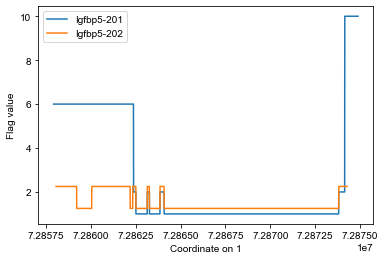

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Igfbp5_id_transcript:ENSMUST00000027377_name_Igfbp5-201_type_mRNA_strand_-_loc_1:72857932-72874884, size=6006
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Igfbp5_id_transcript:ENSMUST00000137339_name_Igfbp5-202_type_lnc_RNA_strand_-_loc_1:72858065-72874275, size=4281
- find mRNA for gene: Cpn1


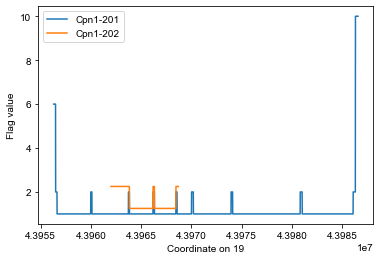

-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Cpn1_id_transcript:ENSMUST00000026210_name_Cpn1-201_type_mRNA_strand_-_loc_19:43956307-43986556, size=1828
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Cpn1_id_transcript:ENSMUST00000131882_name_Cpn1-202_type_lnc_RNA_strand_-_loc_19:43962000-43968693, size=2212
- find mRNA for gene: Rap1gap2


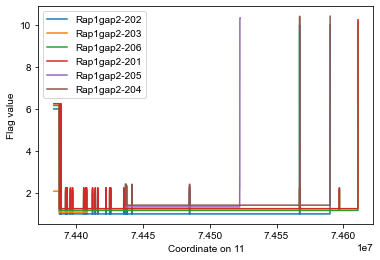

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Rap1gap2_id_transcript:ENSMUST00000102521_name_Rap1gap2-202_type_mRNA_strand_-_loc_11:74383356-74590186, size=6565
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Rap1gap2_id_transcript:ENSMUST00000123440_name_Rap1gap2-203_type_lnc_RNA_strand_-_loc_11:74383484-74408025, size=5120
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Rap1gap2_id_transcript:ENSMUST00000238457_name_Rap1gap2-206_type_mRNA_strand_-_loc_11:74383485-74610915, size=6389
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Rap1gap2_id_transcript:ENSMUST00000047488_name_Rap1gap2-201_type_mRNA_strand_-_loc_11:74383487-74610915, size=6382
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Rap1gap2_id_transcript:ENSMUST00000208896_name_

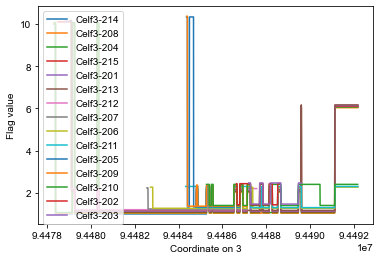

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Celf3_id_transcript:ENSMUST00000199884_name_Celf3-214_type_mRNA_strand_+_loc_3:94478295-94485318, size=366
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Celf3_id_transcript:ENSMUST00000198316_name_Celf3-208_type_mRNA_strand_+_loc_3:94478296-94492188, size=2505
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Celf3_id_transcript:ENSMUST00000197558_name_Celf3-204_type_mRNA_strand_+_loc_3:94478335-94492193, size=2414
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Celf3_id_transcript:ENSMUST00000200342_name_Celf3-215_type_mRNA_strand_+_loc_3:94478494-94492198, size=3173
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Celf3_id_transcript:ENSMUST00000029784_name_Celf3-201_type_mRNA_strand_+_loc_3:94478

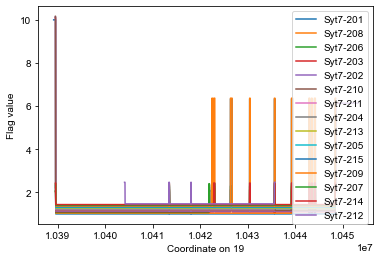

-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Syt7_id_transcript:ENSMUST00000073899_name_Syt7-201_type_mRNA_strand_+_loc_19:10389090-10448444, size=1605
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Syt7_id_transcript:ENSMUST00000225861_name_Syt7-208_type_lnc_RNA_strand_+_loc_19:10389430-10439416, size=697
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Syt7_id_transcript:ENSMUST00000225019_name_Syt7-206_type_lnc_RNA_strand_+_loc_19:10389431-10421968, size=479
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Syt7_id_transcript:ENSMUST00000169121_name_Syt7-203_type_mRNA_strand_+_loc_19:10389431-10448444, size=2116
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Syt7_id_transcript:ENSMUST00000076968_name_Syt7-202_type_mRNA_strand_+_loc_19:

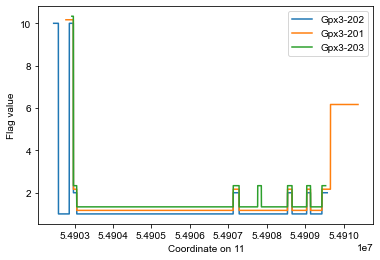

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Gpx3_id_transcript:ENSMUST00000125094_name_Gpx3-202_type_mRNA_strand_+_loc_11:54902453-54909576, size=829
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Gpx3_id_transcript:ENSMUST00000082430_name_Gpx3-201_type_mRNA_strand_+_loc_11:54902772-54910377, size=1594
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Gpx3_id_transcript:ENSMUST00000149324_name_Gpx3-203_type_mRNA_strand_+_loc_11:54902926-54909534, size=693
- find mRNA for gene: Foxa3


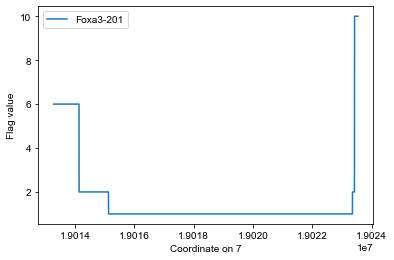

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Foxa3_id_transcript:ENSMUST00000036018_name_Foxa3-201_type_mRNA_strand_-_loc_7:19013284-19023538, size=2037
- find mRNA for gene: Foxa2


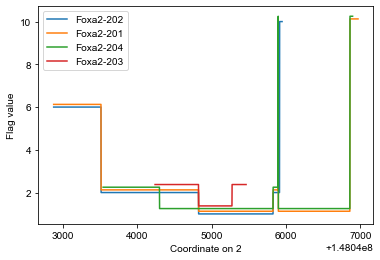

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Foxa2_id_transcript:ENSMUST00000109964_name_Foxa2-202_type_mRNA_strand_-_loc_2:148042877-148045948, size=2070
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Foxa2_id_transcript:ENSMUST00000047315_name_Foxa2-201_type_mRNA_strand_-_loc_2:148042877-148046969, size=2128
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Foxa2_id_transcript:ENSMUST00000172928_name_Foxa2-204_type_mRNA_strand_-_loc_2:148043542-148046896, size=865
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Foxa2_id_transcript:ENSMUST00000146242_name_Foxa2-203_type_lnc_RNA_strand_-_loc_2:148044240-148045464, size=775
- find mRNA for gene: Ckb


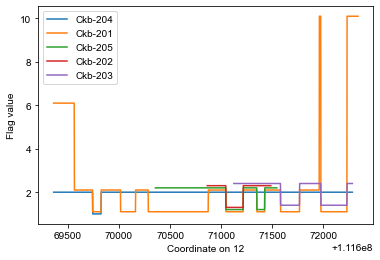

-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Ckb_id_transcript:ENSMUST00000222705_name_Ckb-204_type_lnc_RNA_strand_-_loc_12:111669361-111672282, size=2839
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Ckb_id_transcript:ENSMUST00000001304_name_Ckb-201_type_mRNA_strand_-_loc_12:111669361-111672338, size=1472
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Ckb_id_transcript:ENSMUST00000223099_name_Ckb-205_type_lnc_RNA_strand_-_loc_12:111670356-111671544, size=942
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Ckb_id_transcript:ENSMUST00000220888_name_Ckb-202_type_lnc_RNA_strand_-_loc_12:111670863-111671485, size=453
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Ckb_id_transcript:ENSMUST00000222513_name_Ckb-203_type_lnc_RNA_strand_-_loc

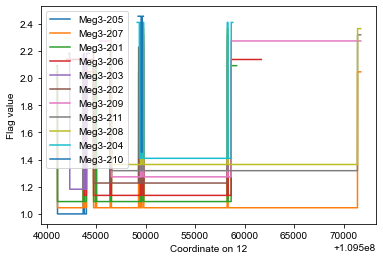

-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Meg3_id_transcript:ENSMUST00000129245_name_Meg3-205_type_lnc_RNA_strand_+_loc_12:109541001-109545319, size=1498
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Meg3_id_transcript:ENSMUST00000143836_name_Meg3-207_type_lnc_RNA_strand_+_loc_12:109541005-109571721, size=1896
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Meg3_id_transcript:ENSMUST00000124106_name_Meg3-201_type_lnc_RNA_strand_+_loc_12:109541007-109559189, size=1988
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Meg3_id_transcript:ENSMUST00000143272_name_Meg3-206_type_lnc_RNA_strand_+_loc_12:109542023-109561682, size=5971
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Meg3_id_transcript:ENSMUST00000128178_name_Meg3-203_type_lnc_R

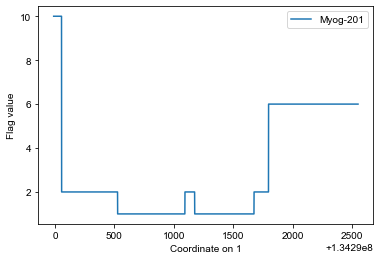

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Myog_id_transcript:ENSMUST00000027730_name_Myog-201_type_mRNA_strand_+_loc_1:134289989-134292548, size=1495
- find mRNA for gene: Ckm


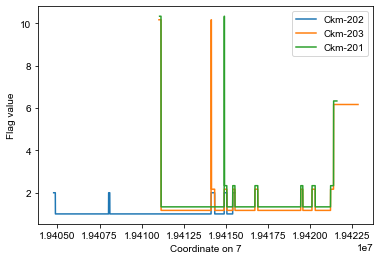

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Ckm_id_transcript:ENSMUST00000208079_name_Ckm-202_type_lnc_RNA_strand_+_loc_7:19404776-19415533, size=671
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Ckm_id_transcript:ENSMUST00000208710_name_Ckm-203_type_mRNA_strand_+_loc_7:19411025-19422841, size=2742
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Ckm_id_transcript:ENSMUST00000003643_name_Ckm-201_type_mRNA_strand_+_loc_7:19411063-19421584, size=1235
- find mRNA for gene: Jpt1


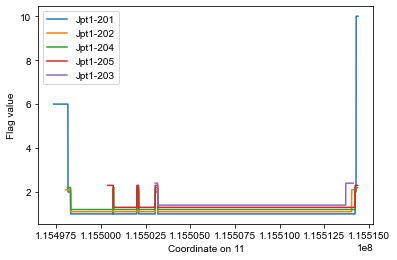

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Jpt1_id_transcript:ENSMUST00000021083_name_Jpt1-201_type_mRNA_strand_-_loc_11:115497353-115514387, size=1375
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Jpt1_id_transcript:ENSMUST00000139980_name_Jpt1-202_type_lnc_RNA_strand_-_loc_11:115498032-115514148, size=650
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Jpt1_id_transcript:ENSMUST00000145104_name_Jpt1-204_type_lnc_RNA_strand_-_loc_11:115498131-115514348, size=597
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Jpt1_id_transcript:ENSMUST00000155399_name_Jpt1-205_type_lnc_RNA_strand_-_loc_11:115500382-115514371, size=696
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Jpt1_id_transcript:ENSMUST00000142238_name_Jpt1-203_type_lnc_RNA_str

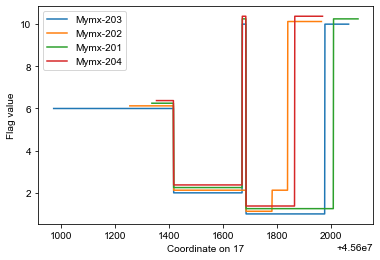

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Mymx_id_transcript:ENSMUST00000178858_name_Mymx-203_type_mRNA_strand_-_loc_17:45600971-45602067, size=804
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Mymx_id_transcript:ENSMUST00000169137_name_Mymx-202_type_mRNA_strand_-_loc_17:45601254-45601966, size=616
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Mymx_id_transcript:ENSMUST00000113529_name_Mymx-201_type_mRNA_strand_-_loc_17:45601336-45602102, size=442
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Mymx_id_transcript:ENSMUST00000208801_name_Mymx-204_type_mRNA_strand_-_loc_17:45601353-45601970, size=437
- find mRNA for gene: Dbn1


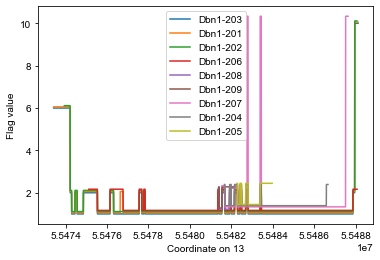

-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Dbn1_id_transcript:ENSMUST00000109923_name_Dbn1-203_type_mRNA_strand_-_loc_13:55473429-55488111, size=2940
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Dbn1_id_transcript:ENSMUST00000021950_name_Dbn1-201_type_mRNA_strand_-_loc_13:55473429-55488111, size=3078
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Dbn1_id_transcript:ENSMUST00000109921_name_Dbn1-202_type_mRNA_strand_-_loc_13:55473944-55488061, size=2378
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Dbn1_id_transcript:ENSMUST00000135705_name_Dbn1-206_type_lnc_RNA_strand_-_loc_13:55475125-55488066, size=2119
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Dbn1_id_transcript:ENSMUST00000139516_name_Dbn1-208_type_lnc_RNA_strand_-_loc_1

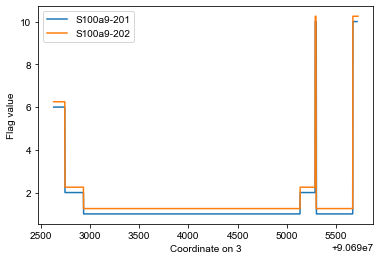

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_S100a9_id_transcript:ENSMUST00000069960_name_S100a9-201_type_mRNA_strand_-_loc_3:90692632-90695711, size=512
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_S100a9_id_transcript:ENSMUST00000117167_name_S100a9-202_type_mRNA_strand_-_loc_3:90692632-90695721, size=519
- find mRNA for gene: Pyy


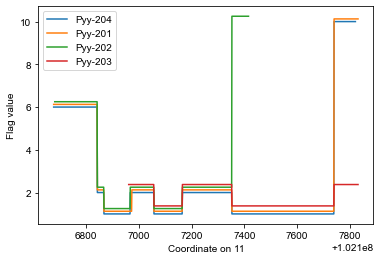

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pyy_id_transcript:ENSMUST00000177304_name_Pyy-204_type_mRNA_strand_-_loc_11:102106676-102107822, size=551
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pyy_id_transcript:ENSMUST00000017455_name_Pyy-201_type_mRNA_strand_-_loc_11:102106676-102107832, size=555
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pyy_id_transcript:ENSMUST00000127381_name_Pyy-202_type_mRNA_strand_-_loc_11:102106680-102107416, size=529
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Pyy_id_transcript:ENSMUST00000177149_name_Pyy-203_type_lnc_RNA_strand_-_loc_11:102106961-102107832, size=376
- find mRNA for gene: Fabp6


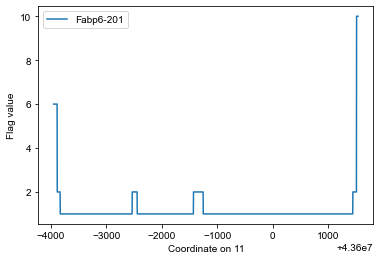

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Fabp6_id_transcript:ENSMUST00000020672_name_Fabp6-201_type_mRNA_strand_-_loc_11:43596049-43601540, size=479
- find mRNA for gene: Slpi


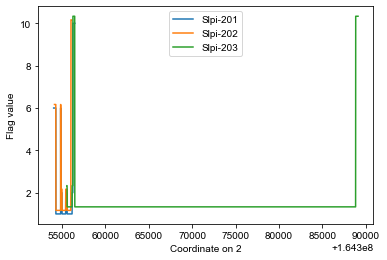

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Slpi_id_transcript:ENSMUST00000109367_name_Slpi-201_type_mRNA_strand_-_loc_2:164354070-164356507, size=876
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Slpi_id_transcript:ENSMUST00000165980_name_Slpi-202_type_mRNA_strand_-_loc_2:164354162-164356067, size=488
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Slpi_id_transcript:ENSMUST00000167427_name_Slpi-203_type_mRNA_strand_-_loc_2:164355595-164389095, size=601
- find mRNA for gene: Gal


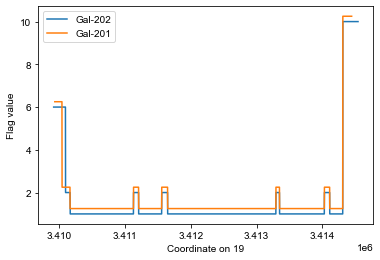

-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Gal_id_transcript:ENSMUST00000237521_name_Gal-202_type_mRNA_strand_-_loc_19:3409915-3414544, size=788
-- searching among 1 references
-- a match found in record: 19.
-- extracting transcript for gene_Gal_id_transcript:ENSMUST00000025842_name_Gal-201_type_mRNA_strand_-_loc_19:3409932-3414447, size=672
- find mRNA for gene: Crabp1


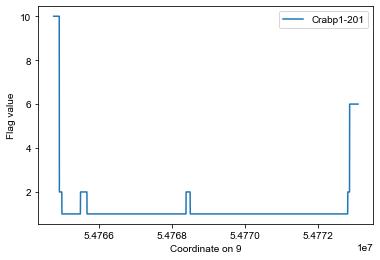

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Crabp1_id_transcript:ENSMUST00000034830_name_Crabp1-201_type_mRNA_strand_+_loc_9:54764748-54773110, size=802
- find mRNA for gene: Spp1


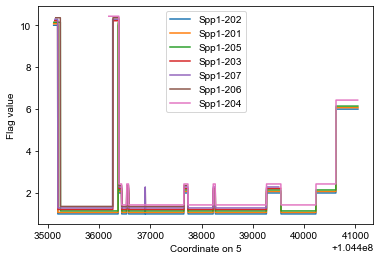

-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Spp1_id_transcript:ENSMUST00000086833_name_Spp1-202_type_mRNA_strand_+_loc_5:104435118-104441048, size=1411
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Spp1_id_transcript:ENSMUST00000031243_name_Spp1-201_type_mRNA_strand_+_loc_5:104435118-104441050, size=1410
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Spp1_id_transcript:ENSMUST00000112748_name_Spp1-205_type_mRNA_strand_+_loc_5:104435121-104441047, size=1456
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Spp1_id_transcript:ENSMUST00000112746_name_Spp1-203_type_mRNA_strand_+_loc_5:104435139-104439542, size=669
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Spp1_id_transcript:ENSMUST00000145084_name_Spp1-207_type_mRNA_strand_+_loc_5:1044351

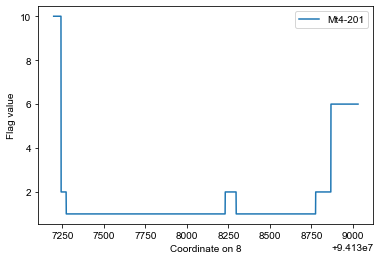

-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Mt4_id_transcript:ENSMUST00000034207_name_Mt4-201_type_mRNA_strand_+_loc_8:94137197-94139031, size=398
- find mRNA for gene: Pomc


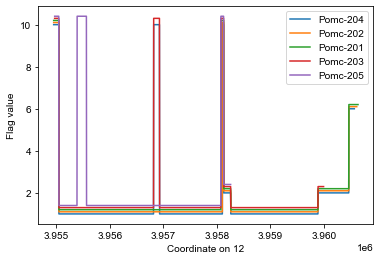

-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Pomc_id_transcript:ENSMUST00000219543_name_Pomc-204_type_mRNA_strand_+_loc_12:3954951-3960573, size=1043
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Pomc_id_transcript:ENSMUST00000218089_name_Pomc-202_type_mRNA_strand_+_loc_12:3954951-3960618, size=977
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Pomc_id_transcript:ENSMUST00000020990_name_Pomc-201_type_mRNA_strand_+_loc_12:3954951-3960642, size=1031
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Pomc_id_transcript:ENSMUST00000218169_name_Pomc-203_type_mRNA_strand_+_loc_12:3954969-3959998, size=480
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Pomc_id_transcript:ENSMUST00000220006_name_Pomc-205_type_mRNA_strand_+_loc_12:3954970-395826

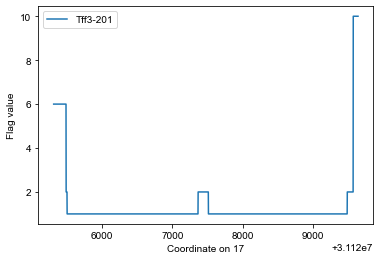

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Tff3_id_transcript:ENSMUST00000024827_name_Tff3-201_type_mRNA_strand_-_loc_17:31125306-31129646, size=493
- find mRNA for gene: Sst


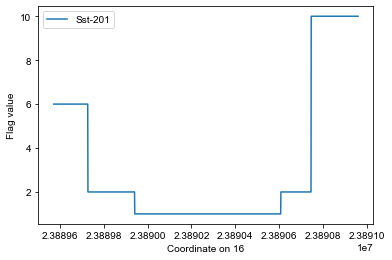

-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Sst_id_transcript:ENSMUST00000004480_name_Sst-201_type_mRNA_strand_-_loc_16:23889573-23890958, size=721
- find mRNA for gene: Ptgds


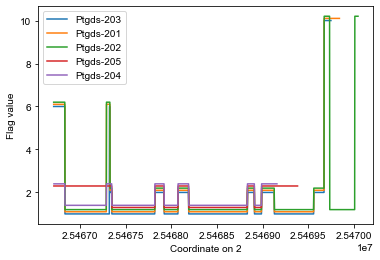

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Ptgds_id_transcript:ENSMUST00000114259_name_Ptgds-203_type_mRNA_strand_-_loc_2:25466709-25469749, size=775
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Ptgds_id_transcript:ENSMUST00000015234_name_Ptgds-201_type_mRNA_strand_-_loc_2:25466709-25469842, size=901
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Ptgds_id_transcript:ENSMUST00000114251_name_Ptgds-202_type_mRNA_strand_-_loc_2:25466709-25470046, size=830
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Ptgds_id_transcript:ENSMUST00000144016_name_Ptgds-205_type_lnc_RNA_strand_-_loc_2:25466711-25469383, size=1327
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Ptgds_id_transcript:ENSMUST00000137417_name_Ptgds-204_type_lnc_RNA_strand_-_loc_2:2

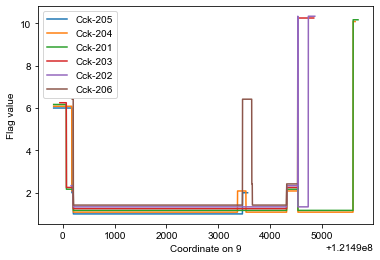

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cck_id_transcript:ENSMUST00000216176_name_Cck-205_type_mRNA_strand_-_loc_9:121489824-121493564, size=478
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cck_id_transcript:ENSMUST00000216138_name_Cck-204_type_mRNA_strand_-_loc_9:121489824-121495639, size=799
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cck_id_transcript:ENSMUST00000035120_name_Cck-201_type_mRNA_strand_-_loc_9:121489824-121495694, size=691
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cck_id_transcript:ENSMUST00000215228_name_Cck-203_type_mRNA_strand_-_loc_9:121489943-121494840, size=783
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cck_id_transcript:ENSMUST00000213106_name_Cck-202_type_mRNA_strand_-_loc_9:121490160-121494860,

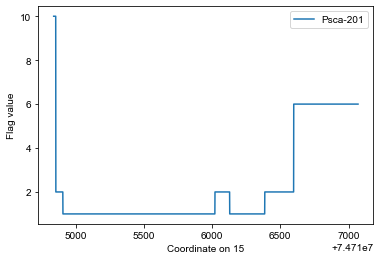

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Psca_id_transcript:ENSMUST00000023265_name_Psca-201_type_mRNA_strand_+_loc_15:74714839-74717069, size=860
- find mRNA for gene: Tac2


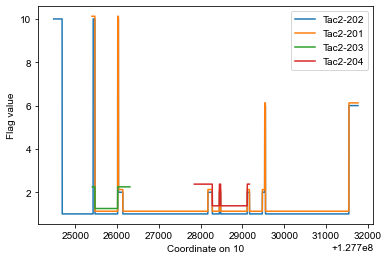

-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Tac2_id_transcript:ENSMUST00000179960_name_Tac2-202_type_mRNA_strand_+_loc_10:127724478-127731767, size=852
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Tac2_id_transcript:ENSMUST00000026466_name_Tac2-201_type_mRNA_strand_+_loc_10:127725395-127731768, size=678
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Tac2_id_transcript:ENSMUST00000217729_name_Tac2-203_type_lnc_RNA_strand_+_loc_10:127725404-127726306, size=358
-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Tac2_id_transcript:ENSMUST00000218048_name_Tac2-204_type_lnc_RNA_strand_+_loc_10:127727847-127729167, size=514
- find mRNA for gene: Gstm3


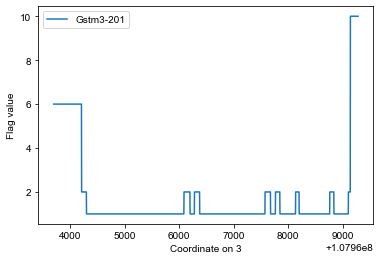

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Gstm3_id_transcript:ENSMUST00000004136_name_Gstm3-201_type_mRNA_strand_-_loc_3:107963696-107969283, size=1311
- find mRNA for gene: Pcp4


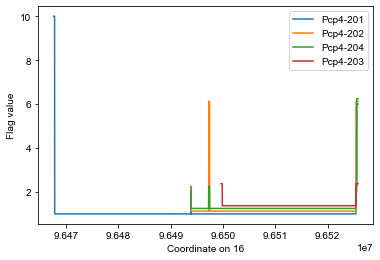

-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Pcp4_id_transcript:ENSMUST00000061739_name_Pcp4-201_type_mRNA_strand_+_loc_16:96467606-96525793, size=641
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Pcp4_id_transcript:ENSMUST00000232906_name_Pcp4-202_type_mRNA_strand_+_loc_16:96493816-96525793, size=637
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Pcp4_id_transcript:ENSMUST00000233816_name_Pcp4-204_type_mRNA_strand_+_loc_16:96493816-96525793, size=626
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Pcp4_id_transcript:ENSMUST00000233216_name_Pcp4-203_type_lnc_RNA_strand_+_loc_16:96499620-96525788, size=603
- find mRNA for gene: Pla2g1b


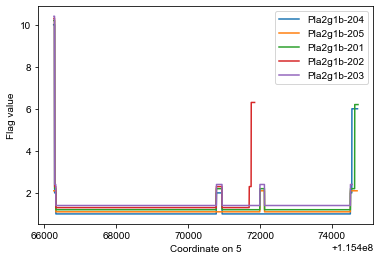

-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Pla2g1b_id_transcript:ENSMUST00000145785_name_Pla2g1b-204_type_mRNA_strand_+_loc_5:115466262-115474708, size=419
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Pla2g1b_id_transcript:ENSMUST00000202822_name_Pla2g1b-205_type_lnc_RNA_strand_+_loc_5:115466266-115474696, size=371
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Pla2g1b_id_transcript:ENSMUST00000031495_name_Pla2g1b-201_type_mRNA_strand_+_loc_5:115466266-115474722, size=557
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Pla2g1b_id_transcript:ENSMUST00000112071_name_Pla2g1b-202_type_mRNA_strand_+_loc_5:115466272-115471847, size=361
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Pla2g1b_id_transcript:ENSMUST00000125568_name_Pla2g1b-203_ty

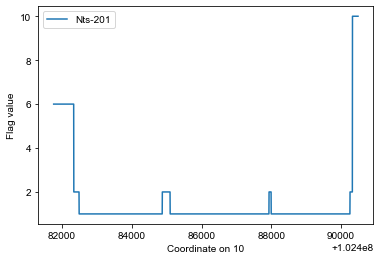

-- searching among 1 references
-- a match found in record: 10.
-- extracting transcript for gene_Nts_id_transcript:ENSMUST00000020040_name_Nts-201_type_mRNA_strand_-_loc_10:102481756-102490486, size=1248
- find mRNA for gene: Apod


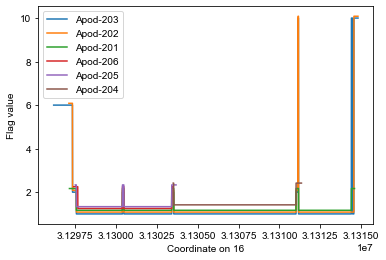

-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Apod_id_transcript:ENSMUST00000130560_name_Apod-203_type_mRNA_strand_-_loc_16:31296192-31314808, size=2074
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Apod_id_transcript:ENSMUST00000115230_name_Apod-202_type_mRNA_strand_-_loc_16:31297122-31314804, size=1070
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Apod_id_transcript:ENSMUST00000023207_name_Apod-201_type_lnc_RNA_strand_-_loc_16:31297156-31314594, size=979
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Apod_id_transcript:ENSMUST00000156456_name_Apod-206_type_lnc_RNA_strand_-_loc_16:31297420-31303445, size=371
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Apod_id_transcript:ENSMUST00000155682_name_Apod-205_type_lnc_RNA_strand_-_loc_

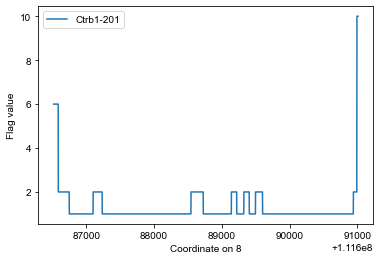

-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Ctrb1_id_transcript:ENSMUST00000034435_name_Ctrb1-201_type_mRNA_strand_-_loc_8:111686519-111691010, size=878
- find mRNA for gene: Lypd2


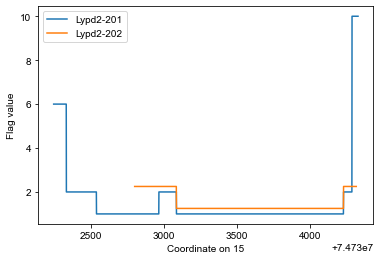

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Lypd2_id_transcript:ENSMUST00000023260_name_Lypd2-201_type_mRNA_strand_-_loc_15:74732247-74734329, size=513
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Lypd2_id_transcript:ENSMUST00000188716_name_Lypd2-202_type_lnc_RNA_strand_-_loc_15:74732801-74734317, size=374
- find mRNA for gene: Pgc


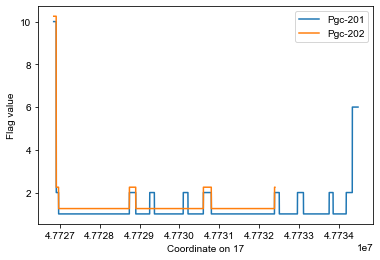

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Pgc_id_transcript:ENSMUST00000024782_name_Pgc-201_type_mRNA_strand_+_loc_17:47726842-47734482, size=1388
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Pgc_id_transcript:ENSMUST00000144955_name_Pgc-202_type_mRNA_strand_+_loc_17:47726844-47732393, size=490
- find mRNA for gene: Rarres1


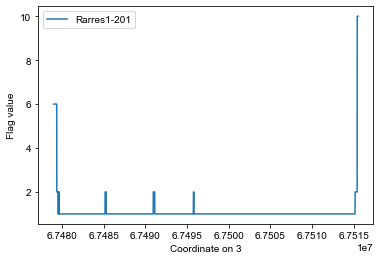

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Rarres1_id_transcript:ENSMUST00000054825_name_Rarres1-201_type_mRNA_strand_-_loc_3:67478972-67515523, size=1325
- find mRNA for gene: Retnla


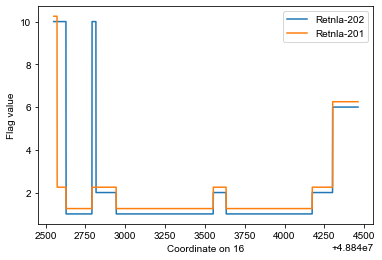

-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Retnla_id_transcript:ENSMUST00000238847_name_Retnla-202_type_mRNA_strand_+_loc_16:48842551-48844461, size=599
-- searching among 1 references
-- a match found in record: 16.
-- extracting transcript for gene_Retnla_id_transcript:ENSMUST00000023329_name_Retnla-201_type_mRNA_strand_+_loc_16:48842552-48844461, size=598
- find mRNA for gene: Ins2


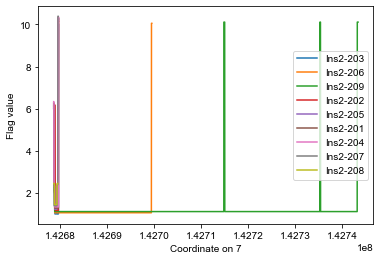

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Ins2_id_transcript:ENSMUST00000105931_name_Ins2-203_type_mRNA_strand_-_loc_7:142678656-142679685, size=472
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Ins2_id_transcript:ENSMUST00000105934_name_Ins2-206_type_mRNA_strand_-_loc_7:142678656-142699510, size=480
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Ins2_id_transcript:ENSMUST00000210288_name_Ins2-209_type_mRNA_strand_-_loc_7:142678656-142743381, size=918
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Ins2_id_transcript:ENSMUST00000105930_name_Ins2-202_type_mRNA_strand_-_loc_7:142678659-142679692, size=583
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Ins2_id_transcript:ENSMUST00000105933_name_Ins2-205_type_mRNA_strand_-_loc_7:142678659-

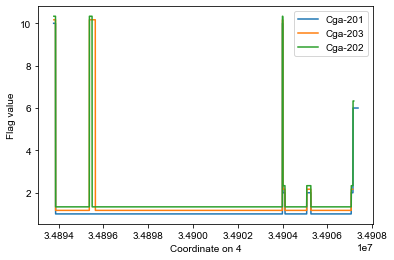

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Cga_id_transcript:ENSMUST00000029975_name_Cga-201_type_mRNA_strand_+_loc_4:34893779-34907370, size=687
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Cga_id_transcript:ENSMUST00000135871_name_Cga-203_type_mRNA_strand_+_loc_4:34893788-34907132, size=707
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Cga_id_transcript:ENSMUST00000108130_name_Cga-202_type_mRNA_strand_+_loc_4:34893788-34907178, size=609
- find mRNA for gene: Iapp


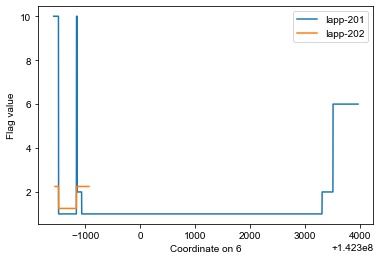

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Iapp_id_transcript:ENSMUST00000041993_name_Iapp-201_type_mRNA_strand_+_loc_6:142298423-142303961, size=839
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Iapp_id_transcript:ENSMUST00000141583_name_Iapp-202_type_lnc_RNA_strand_+_loc_6:142298447-142299066, size=294
- find mRNA for gene: Nppa


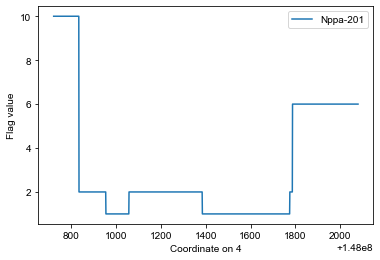

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Nppa_id_transcript:ENSMUST00000103230_name_Nppa-201_type_mRNA_strand_+_loc_4:148000722-148002079, size=865
- find mRNA for gene: Camp


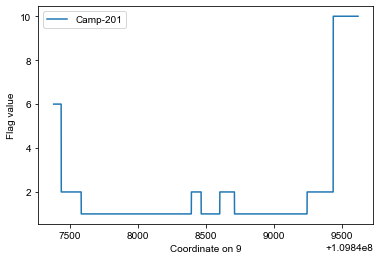

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Camp_id_transcript:ENSMUST00000112022_name_Camp-201_type_mRNA_strand_-_loc_9:109847379-109849617, size=758
- find mRNA for gene: Cyp1a2


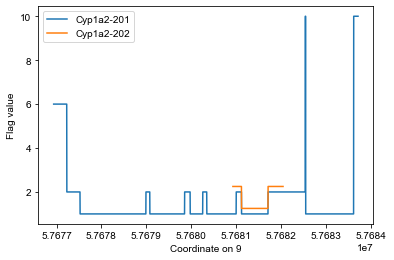

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cyp1a2_id_transcript:ENSMUST00000034860_name_Cyp1a2-201_type_mRNA_strand_-_loc_9:57676937-57683703, size=1940
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cyp1a2_id_transcript:ENSMUST00000215792_name_Cyp1a2-202_type_lnc_RNA_strand_-_loc_9:57680921-57682036, size=526
- find mRNA for gene: Dlk1


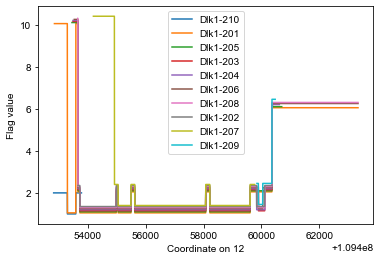

-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Dlk1_id_transcript:ENSMUST00000174539_name_Dlk1-210_type_lnc_RNA_strand_+_loc_12:109452823-109453782, size=668
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Dlk1_id_transcript:ENSMUST00000056110_name_Dlk1-201_type_mRNA_strand_+_loc_12:109452849-109463336, size=4653
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Dlk1_id_transcript:ENSMUST00000109844_name_Dlk1-205_type_mRNA_strand_+_loc_12:109453455-109460700, size=1703
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Dlk1_id_transcript:ENSMUST00000109842_name_Dlk1-203_type_mRNA_strand_+_loc_12:109453491-109460381, size=1129
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Dlk1_id_transcript:ENSMUST00000109843_name_Dlk1-204_type_mRNA_strand_+_l

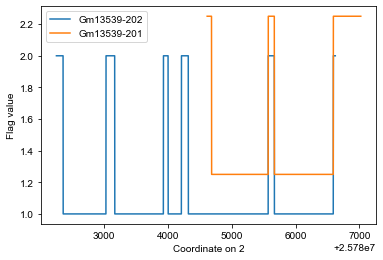

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Gm13539_id_transcript:ENSMUST00000211245_name_Gm13539-202_type_mRNA_strand_+_loc_2:25782257-25786623, size=552
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Gm13539_id_transcript:ENSMUST00000153913_name_Gm13539-201_type_lnc_RNA_strand_+_loc_2:25784617-25787022, size=596
- find mRNA for gene: Krt13


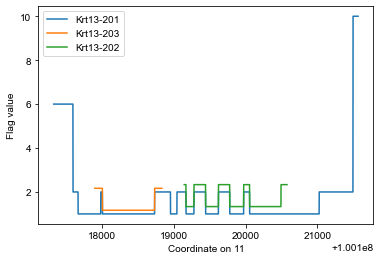

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt13_id_transcript:ENSMUST00000007275_name_Krt13-201_type_mRNA_strand_-_loc_11:100117327-100121566, size=1654
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt13_id_transcript:ENSMUST00000134282_name_Krt13-203_type_lnc_RNA_strand_-_loc_11:100117901-100118834, size=207
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt13_id_transcript:ENSMUST00000128934_name_Krt13-202_type_lnc_RNA_strand_-_loc_11:100119145-100120577, size=512
- find mRNA for gene: Cilp


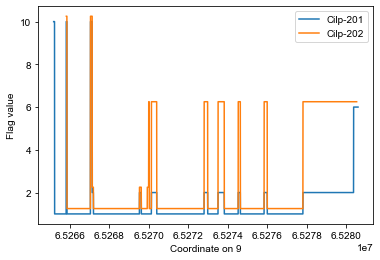

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cilp_id_transcript:ENSMUST00000048762_name_Cilp-201_type_mRNA_strand_+_loc_9:65265180-65280605, size=4153
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Cilp_id_transcript:ENSMUST00000141382_name_Cilp-202_type_mRNA_strand_+_loc_9:65265823-65280535, size=4128
- find mRNA for gene: Igfbp6


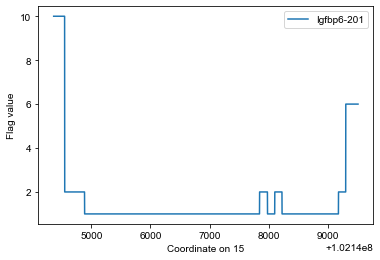

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Igfbp6_id_transcript:ENSMUST00000023807_name_Igfbp6-201_type_mRNA_strand_+_loc_15:102144362-102149511, size=1112
- find mRNA for gene: Apoc2


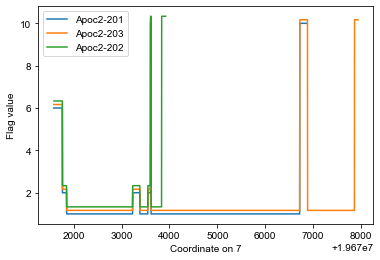

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Apoc2_id_transcript:ENSMUST00000003074_name_Apoc2-201_type_mRNA_strand_-_loc_7:19671579-19676864, size=631
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Apoc2_id_transcript:ENSMUST00000142352_name_Apoc2-203_type_mRNA_strand_-_loc_7:19671579-19677941, size=727
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Apoc2_id_transcript:ENSMUST00000134116_name_Apoc2-202_type_mRNA_strand_-_loc_7:19671584-19673920, size=569
- find mRNA for gene: Sparc


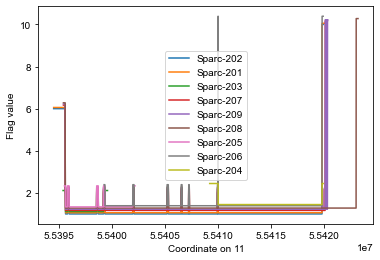

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Sparc_id_transcript:ENSMUST00000108858_name_Sparc-202_type_mRNA_strand_-_loc_11:55394500-55419898, size=2115
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Sparc_id_transcript:ENSMUST00000018737_name_Sparc-201_type_mRNA_strand_-_loc_11:55394500-55420080, size=2300
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Sparc_id_transcript:ENSMUST00000123775_name_Sparc-203_type_lnc_RNA_strand_-_loc_11:55395386-55399574, size=909
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Sparc_id_transcript:ENSMUST00000213866_name_Sparc-207_type_mRNA_strand_-_loc_11:55395421-55420290, size=1366
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Sparc_id_transcript:ENSMUST00000216313_name_Sparc-209_type_mRNA_strand_-

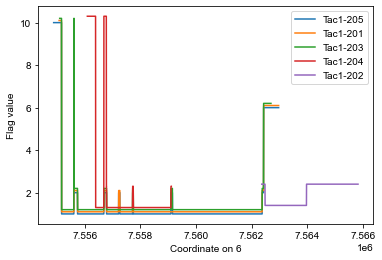

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Tac1_id_transcript:ENSMUST00000185187_name_Tac1-205_type_mRNA_strand_+_loc_6:7554879-7562977, size=1230
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Tac1_id_transcript:ENSMUST00000090679_name_Tac1-201_type_mRNA_strand_+_loc_6:7555074-7562976, size=980
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Tac1_id_transcript:ENSMUST00000184986_name_Tac1-203_type_mRNA_strand_+_loc_6:7555096-7562700, size=691
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Tac1_id_transcript:ENSMUST00000185130_name_Tac1-204_type_mRNA_strand_+_loc_6:7556091-7559114, size=434
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Tac1_id_transcript:ENSMUST00000184481_name_Tac1-202_type_lnc_RNA_strand_+_loc_6:7562368-7565834, size=

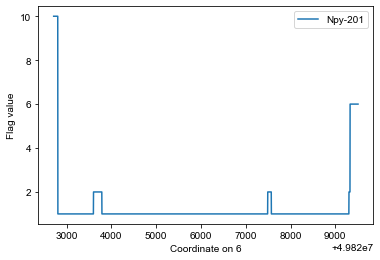

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Npy_id_transcript:ENSMUST00000031843_name_Npy-201_type_mRNA_strand_+_loc_6:49822710-49829507, size=566
- find mRNA for gene: Saa2


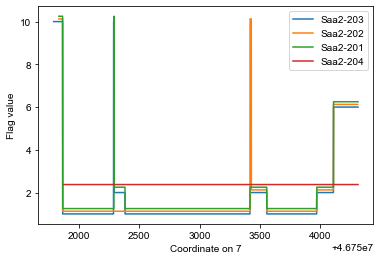

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Saa2_id_transcript:ENSMUST00000210769_name_Saa2-203_type_mRNA_strand_+_loc_7:46751790-46754313, size=652
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Saa2_id_transcript:ENSMUST00000210272_name_Saa2-202_type_mRNA_strand_+_loc_7:46751833-46754310, size=511
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Saa2_id_transcript:ENSMUST00000075982_name_Saa2-201_type_mRNA_strand_+_loc_7:46751833-46754313, size=606
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Saa2_id_transcript:ENSMUST00000211766_name_Saa2-204_type_lnc_RNA_strand_+_loc_7:46751871-46754313, size=2443
- find mRNA for gene: Mpo


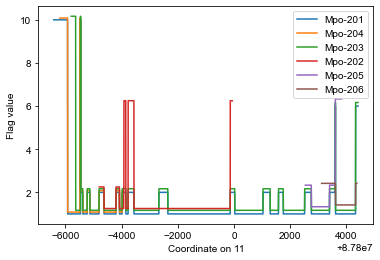

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Mpo_id_transcript:ENSMUST00000020779_name_Mpo-201_type_mRNA_strand_+_loc_11:87793581-87804413, size=2750
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Mpo_id_transcript:ENSMUST00000143021_name_Mpo-204_type_mRNA_strand_+_loc_11:87793795-87796046, size=806
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Mpo_id_transcript:ENSMUST00000121303_name_Mpo-203_type_mRNA_strand_+_loc_11:87794209-87804413, size=2409
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Mpo_id_transcript:ENSMUST00000107930_name_Mpo-202_type_mRNA_strand_+_loc_11:87795203-87799937, size=648
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Mpo_id_transcript:ENSMUST00000146650_name_Mpo-205_type_mRNA_strand_+_loc_11:87802538-8780382

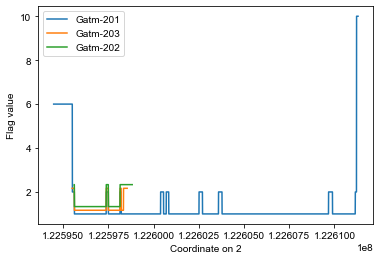

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Gatm_id_transcript:ENSMUST00000028624_name_Gatm-201_type_mRNA_strand_-_loc_2:122594467-122611303, size=2389
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Gatm_id_transcript:ENSMUST00000154598_name_Gatm-203_type_lnc_RNA_strand_-_loc_2:122595489-122598534, size=510
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Gatm_id_transcript:ENSMUST00000140808_name_Gatm-202_type_lnc_RNA_strand_-_loc_2:122595606-122598812, size=797
- find mRNA for gene: Xcl1


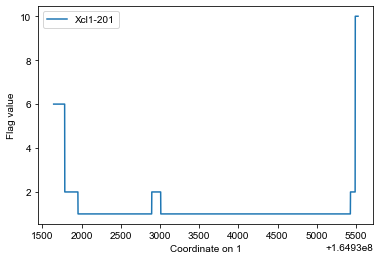

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Xcl1_id_transcript:ENSMUST00000027860_name_Xcl1-201_type_mRNA_strand_-_loc_1:164931644-164935527, size=523
- find mRNA for gene: H19


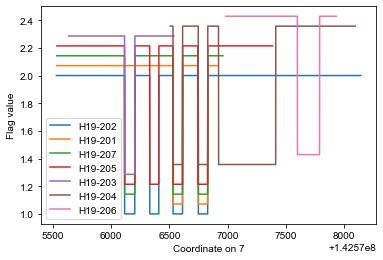

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_H19_id_transcript:ENSMUST00000136359_name_H19-202_type_lnc_RNA_strand_-_loc_7:142575529-142578143, size=2286
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_H19_id_transcript:ENSMUST00000132294_name_H19-201_type_lnc_RNA_strand_-_loc_7:142575531-142576910, size=1217
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_H19_id_transcript:ENSMUST00000228514_name_H19-207_type_lnc_RNA_strand_-_loc_7:142575531-142576959, size=1178
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_H19_id_transcript:ENSMUST00000152754_name_H19-205_type_lnc_RNA_strand_-_loc_7:142575533-142577386, size=1521
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_H19_id_transcript:ENSMUST00000140716_name_H19-203_type_lnc_RNA_strand_-_loc_7:1

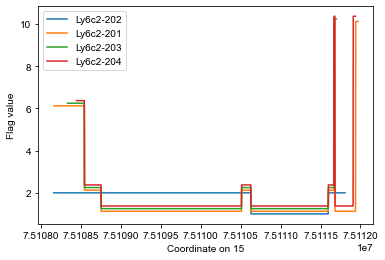

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c2_id_transcript:ENSMUST00000187864_name_Ly6c2-202_type_lnc_RNA_strand_-_loc_15:75108158-75111807, size=2680
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c2_id_transcript:ENSMUST00000100542_name_Ly6c2-201_type_mRNA_strand_-_loc_15:75108161-75111970, size=822
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c2_id_transcript:ENSMUST00000188214_name_Ly6c2-203_type_mRNA_strand_-_loc_15:75108331-75111697, size=638
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c2_id_transcript:ENSMUST00000191451_name_Ly6c2-204_type_mRNA_strand_-_loc_15:75108443-75111937, size=538
- find mRNA for gene: Cxcl13


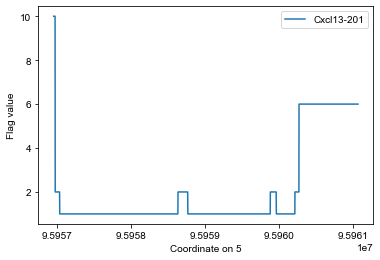

-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Cxcl13_id_transcript:ENSMUST00000023840_name_Cxcl13-201_type_mRNA_strand_+_loc_5:95956951-95961068, size=1150
- find mRNA for gene: Penk


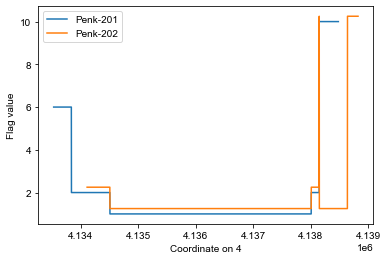

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Penk_id_transcript:ENSMUST00000070375_name_Penk-201_type_mRNA_strand_-_loc_4:4133531-4138477, size=1449
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Penk_id_transcript:ENSMUST00000133567_name_Penk-202_type_mRNA_strand_-_loc_4:4134112-4138819, size=721
- find mRNA for gene: Ecm1


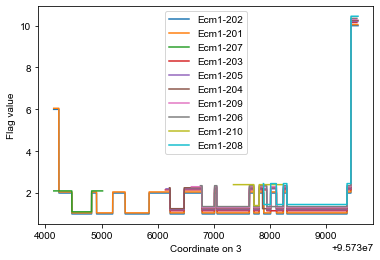

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Ecm1_id_transcript:ENSMUST00000117507_name_Ecm1-202_type_mRNA_strand_-_loc_3:95734147-95739569, size=1900
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Ecm1_id_transcript:ENSMUST00000029753_name_Ecm1-201_type_mRNA_strand_-_loc_3:95734148-95739567, size=1894
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Ecm1_id_transcript:ENSMUST00000144958_name_Ecm1-207_type_lnc_RNA_strand_-_loc_3:95734149-95735018, size=518
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Ecm1_id_transcript:ENSMUST00000123143_name_Ecm1-203_type_mRNA_strand_-_loc_3:95736137-95739549, size=906
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Ecm1_id_transcript:ENSMUST00000131376_name_Ecm1-205_type_mRNA_strand_-_loc_3:95736149-9573

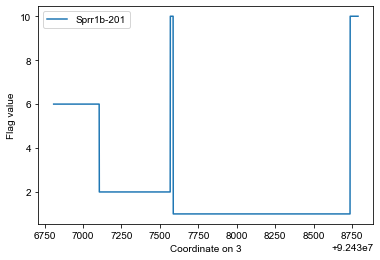

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Sprr1b_id_transcript:ENSMUST00000062160_name_Sprr1b-201_type_mRNA_strand_-_loc_3:92436809-92438789, size=830
- find mRNA for gene: Ly6c1


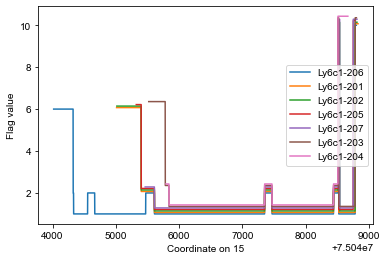

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c1_id_transcript:ENSMUST00000188845_name_Ly6c1-206_type_mRNA_strand_-_loc_15:75044018-75048803, size=784
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c1_id_transcript:ENSMUST00000065408_name_Ly6c1-201_type_mRNA_strand_-_loc_15:75045013-75048830, size=844
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c1_id_transcript:ENSMUST00000179762_name_Ly6c1-202_type_mRNA_strand_-_loc_15:75045017-75048813, size=838
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c1_id_transcript:ENSMUST00000187347_name_Ly6c1-205_type_mRNA_strand_-_loc_15:75045324-75048788, size=522
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Ly6c1_id_transcript:ENSMUST00000191216_name_Ly6c1-207_type_mRNA_strand_-_loc_1

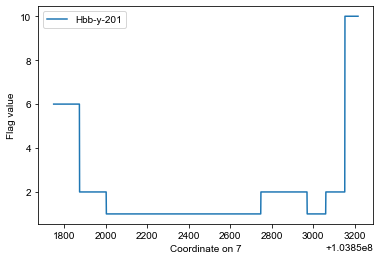

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Hbb-y_id_transcript:ENSMUST00000033229_name_Hbb-y-201_type_mRNA_strand_-_loc_7:103851749-103853216, size=633
- find mRNA for gene: Ccl1


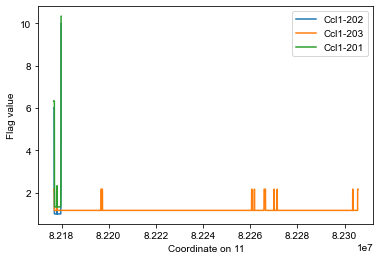

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl1_id_transcript:ENSMUST00000108189_name_Ccl1-202_type_mRNA_strand_-_loc_11:82176657-82179812, size=514
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl1_id_transcript:ENSMUST00000138333_name_Ccl1-203_type_lnc_RNA_strand_-_loc_11:82176657-82305690, size=2126
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl1_id_transcript:ENSMUST00000021043_name_Ccl1-201_type_mRNA_strand_-_loc_11:82176659-82179812, size=611
- find mRNA for gene: Klk7


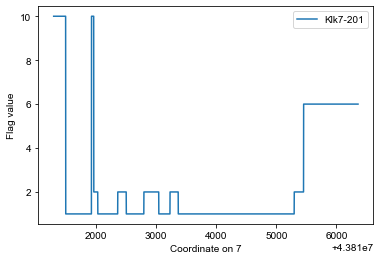

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Klk7_id_transcript:ENSMUST00000032955_name_Klk7-201_type_mRNA_strand_+_loc_7:43811294-43816359, size=1895
- find mRNA for gene: Dppa3


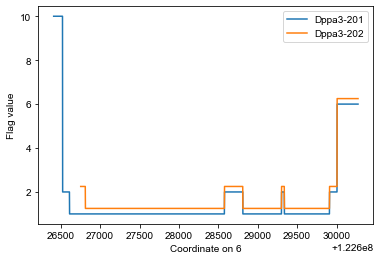

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Dppa3_id_transcript:ENSMUST00000049644_name_Dppa3-201_type_mRNA_strand_+_loc_6:122626410-122630272, size=833
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Dppa3_id_transcript:ENSMUST00000123429_name_Dppa3-202_type_mRNA_strand_+_loc_6:122626753-122630272, size=691
- find mRNA for gene: Hba-a2


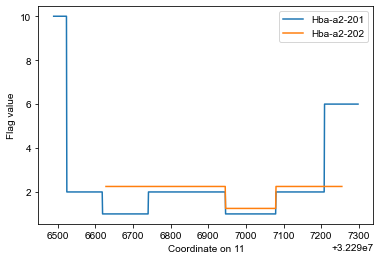

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Hba-a2_id_transcript:ENSMUST00000093207_name_Hba-a2-201_type_mRNA_strand_+_loc_11:32296489-32297298, size=554
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Hba-a2_id_transcript:ENSMUST00000147010_name_Hba-a2-202_type_lnc_RNA_strand_+_loc_11:32296628-32297255, size=494
- find mRNA for gene: Mt3


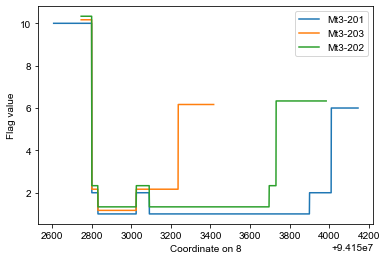

-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Mt3_id_transcript:ENSMUST00000034211_name_Mt3-201_type_mRNA_strand_+_loc_8:94152607-94154146, size=536
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Mt3_id_transcript:ENSMUST00000211930_name_Mt3-203_type_mRNA_strand_+_loc_8:94152746-94153416, size=477
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Mt3_id_transcript:ENSMUST00000211915_name_Mt3-202_type_mRNA_strand_+_loc_8:94152746-94153985, size=440
- find mRNA for gene: Krt71


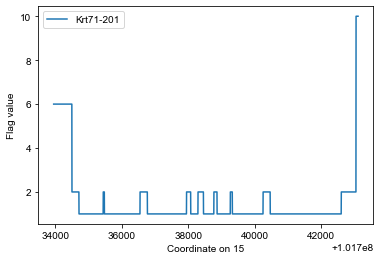

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Krt71_id_transcript:ENSMUST00000023710_name_Krt71-201_type_mRNA_strand_-_loc_15:101733949-101743109, size=2186
- find mRNA for gene: Cryaa


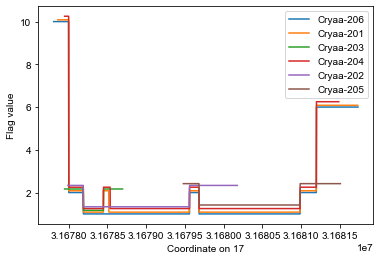

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Cryaa_id_transcript:ENSMUST00000228716_name_Cryaa-206_type_mRNA_strand_+_loc_17:31677807-31681733, size=1254
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Cryaa_id_transcript:ENSMUST00000019192_name_Cryaa-201_type_mRNA_strand_+_loc_17:31677860-31681729, size=1266
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Cryaa_id_transcript:ENSMUST00000227620_name_Cryaa-203_type_lnc_RNA_strand_+_loc_17:31677948-31678696, size=490
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Cryaa_id_transcript:ENSMUST00000228089_name_Cryaa-204_type_mRNA_strand_+_loc_17:31677948-31681485, size=952
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Cryaa_id_transcript:ENSMUST00000226183_name_Cryaa-202_type_lnc_RNA_strand

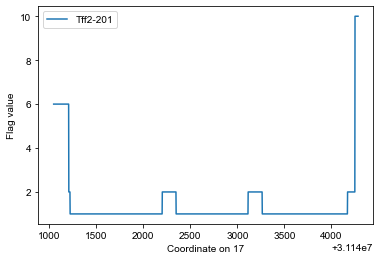

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Tff2_id_transcript:ENSMUST00000024826_name_Tff2-201_type_mRNA_strand_-_loc_17:31141049-31144282, size=584
- find mRNA for gene: Timp2


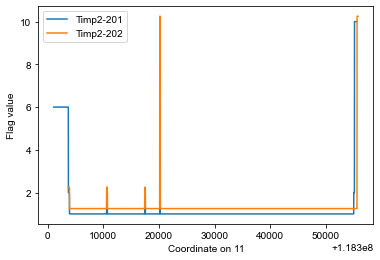

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Timp2_id_transcript:ENSMUST00000017610_name_Timp2-201_type_mRNA_strand_-_loc_11:118301069-118355506, size=3709
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Timp2_id_transcript:ENSMUST00000155707_name_Timp2-202_type_mRNA_strand_-_loc_11:118303701-118355740, size=718
- find mRNA for gene: Klk14


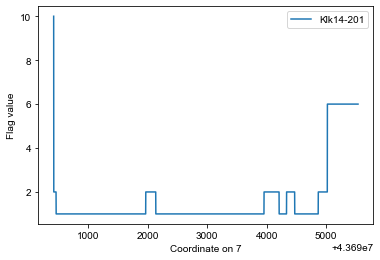

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Klk14_id_transcript:ENSMUST00000056329_name_Klk14-201_type_mRNA_strand_+_loc_7:43690418-43695536, size=1271
- find mRNA for gene: Fgg


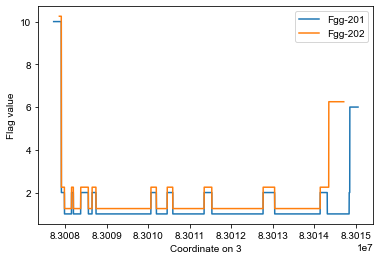

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Fgg_id_transcript:ENSMUST00000048486_name_Fgg-201_type_mRNA_strand_+_loc_3:83007724-83015049, size=1695
-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Fgg_id_transcript:ENSMUST00000194175_name_Fgg-202_type_mRNA_strand_+_loc_3:83007861-83014705, size=1741
- find mRNA for gene: Oas1d


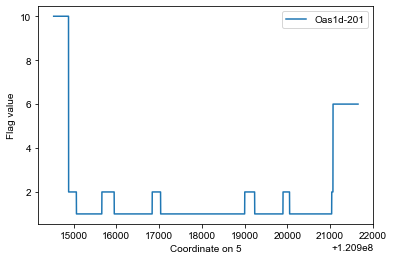

-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Oas1d_id_transcript:ENSMUST00000044224_name_Oas1d-201_type_mRNA_strand_+_loc_5:120914536-120921652, size=2021
- find mRNA for gene: Rsad2


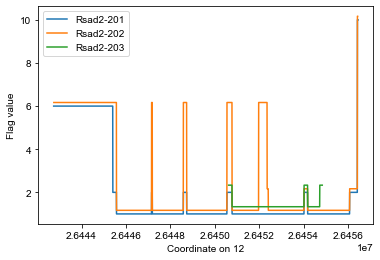

-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Rsad2_id_transcript:ENSMUST00000020970_name_Rsad2-201_type_mRNA_strand_-_loc_12:26442746-26456452, size=3782
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Rsad2_id_transcript:ENSMUST00000137792_name_Rsad2-202_type_mRNA_strand_-_loc_12:26442753-26456431, size=4189
-- searching among 1 references
-- a match found in record: 12.
-- extracting transcript for gene_Rsad2_id_transcript:ENSMUST00000142732_name_Rsad2-203_type_lnc_RNA_strand_-_loc_12:26450626-26454842, size=430
- find mRNA for gene: Apoa2


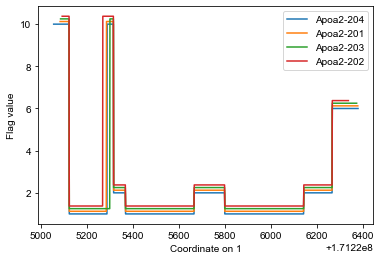

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Apoa2_id_transcript:ENSMUST00000111321_name_Apoa2-204_type_mRNA_strand_+_loc_1:171225054-171226379, size=518
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Apoa2_id_transcript:ENSMUST00000005824_name_Apoa2-201_type_mRNA_strand_+_loc_1:171225082-171226378, size=492
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Apoa2_id_transcript:ENSMUST00000111320_name_Apoa2-203_type_mRNA_strand_+_loc_1:171225084-171226373, size=470
-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Apoa2_id_transcript:ENSMUST00000111319_name_Apoa2-202_type_mRNA_strand_+_loc_1:171225091-171226337, size=458
- find mRNA for gene: Nefh


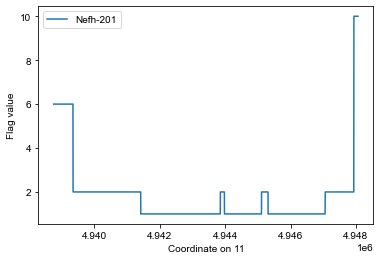

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Nefh_id_transcript:ENSMUST00000093369_name_Nefh-201_type_mRNA_strand_-_loc_11:4938754-4948064, size=3994
- find mRNA for gene: Idi2


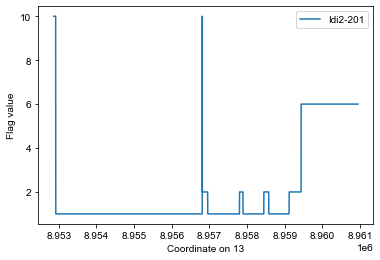

-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Idi2_id_transcript:ENSMUST00000038598_name_Idi2-201_type_mRNA_strand_+_loc_13:8952863-8960945, size=2253
- find mRNA for gene: Olfm1


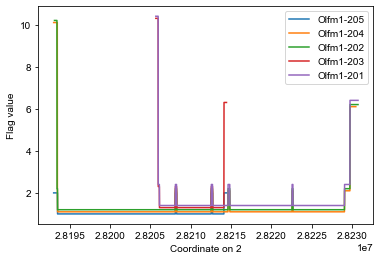

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Olfm1_id_transcript:ENSMUST00000152415_name_Olfm1-205_type_lnc_RNA_strand_+_loc_2:28192992-28214425, size=1102
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Olfm1_id_transcript:ENSMUST00000113920_name_Olfm1-204_type_mRNA_strand_+_loc_2:28192992-28230462, size=2513
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Olfm1_id_transcript:ENSMUST00000100244_name_Olfm1-202_type_mRNA_strand_+_loc_2:28193093-28230736, size=2686
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Olfm1_id_transcript:ENSMUST00000102879_name_Olfm1-203_type_mRNA_strand_+_loc_2:28205659-28214425, size=1072
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Olfm1_id_transcript:ENSMUST00000028177_name_Olfm1-201_type_mRNA_strand_+_loc_2:2

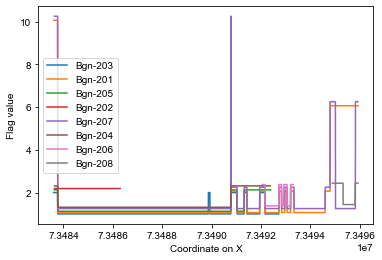

-- searching among 1 references
-- a match found in record: X.
-- extracting transcript for gene_Bgn_id_transcript:ENSMUST00000133394_name_Bgn-203_type_lnc_RNA_strand_+_loc_X:73483602-73492746, size=828
-- searching among 1 references
-- a match found in record: X.
-- extracting transcript for gene_Bgn_id_transcript:ENSMUST00000033741_name_Bgn-201_type_mRNA_strand_+_loc_X:73483602-73495933, size=2419
-- searching among 1 references
-- a match found in record: X.
-- extracting transcript for gene_Bgn_id_transcript:ENSMUST00000141945_name_Bgn-205_type_lnc_RNA_strand_+_loc_X:73483623-73492398, size=1473
-- searching among 1 references
-- a match found in record: X.
-- extracting transcript for gene_Bgn_id_transcript:ENSMUST00000130873_name_Bgn-202_type_lnc_RNA_strand_+_loc_X:73483633-73486298, size=2666
-- searching among 1 references
-- a match found in record: X.
-- extracting transcript for gene_Bgn_id_transcript:ENSMUST00000169489_name_Bgn-207_type_mRNA_strand_+_loc_X:73483635-7349592

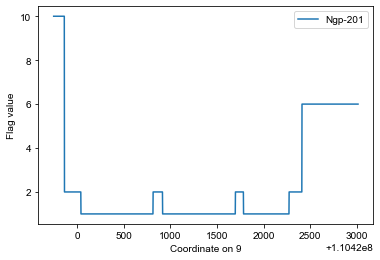

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Ngp_id_transcript:ENSMUST00000035061_name_Ngp-201_type_mRNA_strand_+_loc_9:110419747-110423012, size=1222
- find mRNA for gene: Car4


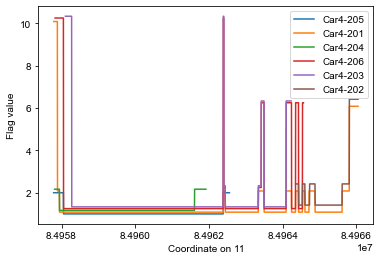

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Car4_id_transcript:ENSMUST00000139416_name_Car4-205_type_lnc_RNA_strand_+_loc_11:84957786-84962555, size=435
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Car4_id_transcript:ENSMUST00000103194_name_Car4-201_type_mRNA_strand_+_loc_11:84957788-84966044, size=1256
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Car4_id_transcript:ENSMUST00000138331_name_Car4-204_type_lnc_RNA_strand_+_loc_11:84957811-84961918, size=443
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Car4_id_transcript:ENSMUST00000150596_name_Car4-206_type_mRNA_strand_+_loc_11:84957825-84964563, size=692
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Car4_id_transcript:ENSMUST00000127827_name_Car4-203_type_mRNA_strand_+_loc_11:8

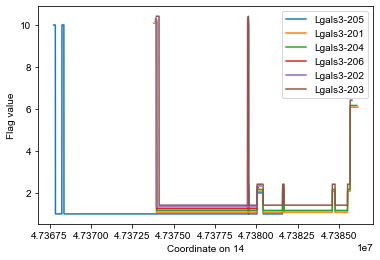

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Lgals3_id_transcript:ENSMUST00000151405_name_Lgals3-205_type_mRNA_strand_+_loc_14:47367751-47381628, size=646
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Lgals3_id_transcript:ENSMUST00000142734_name_Lgals3-201_type_mRNA_strand_+_loc_14:47373813-47386160, size=1419
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Lgals3_id_transcript:ENSMUST00000150290_name_Lgals3-204_type_mRNA_strand_+_loc_14:47373889-47386088, size=1298
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Lgals3_id_transcript:ENSMUST00000226585_name_Lgals3-206_type_mRNA_strand_+_loc_14:47373916-47380132, size=210
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Lgals3_id_transcript:ENSMUST00000144794_name_Lgals3-202_type_mRNA_st

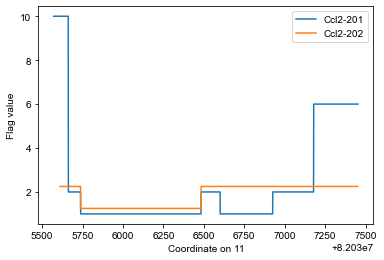

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl2_id_transcript:ENSMUST00000000193_name_Ccl2-201_type_mRNA_strand_+_loc_11:82035571-82037453, size=813
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Ccl2_id_transcript:ENSMUST00000124479_name_Ccl2-202_type_lnc_RNA_strand_+_loc_11:82035610-82037450, size=1096
- find mRNA for gene: Hp


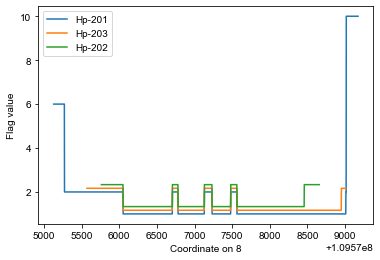

-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Hp_id_transcript:ENSMUST00000074898_name_Hp-201_type_mRNA_strand_-_loc_8:109575128-109579172, size=1345
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Hp_id_transcript:ENSMUST00000212918_name_Hp-203_type_lnc_RNA_strand_-_loc_8:109575570-109579010, size=801
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Hp_id_transcript:ENSMUST00000212018_name_Hp-202_type_lnc_RNA_strand_-_loc_8:109575762-109578657, size=749
- find mRNA for gene: C1qb


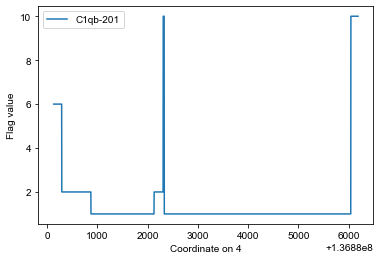

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_C1qb_id_transcript:ENSMUST00000046384_name_C1qb-201_type_mRNA_strand_-_loc_4:136880129-136886187, size=1088
- find mRNA for gene: Mal


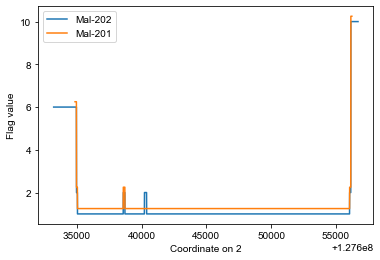

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Mal_id_transcript:ENSMUST00000028854_name_Mal-202_type_mRNA_strand_-_loc_2:127633226-127656695, size=2778
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Mal_id_transcript:ENSMUST00000028853_name_Mal-201_type_mRNA_strand_-_loc_2:127634874-127656219, size=486
- find mRNA for gene: Alpl


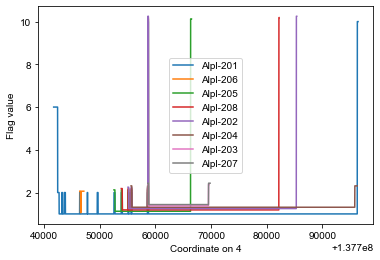

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Alpl_id_transcript:ENSMUST00000030551_name_Alpl-201_type_mRNA_strand_-_loc_4:137741733-137796384, size=2522
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Alpl_id_transcript:ENSMUST00000141451_name_Alpl-206_type_lnc_RNA_strand_-_loc_4:137746420-137747147, size=606
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Alpl_id_transcript:ENSMUST00000139951_name_Alpl-205_type_mRNA_strand_-_loc_4:137752552-137766475, size=916
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Alpl_id_transcript:ENSMUST00000153588_name_Alpl-208_type_mRNA_strand_-_loc_4:137753867-137782191, size=604
-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Alpl_id_transcript:ENSMUST00000133473_name_Alpl-202_type_mRNA_strand_-_loc_4:137755

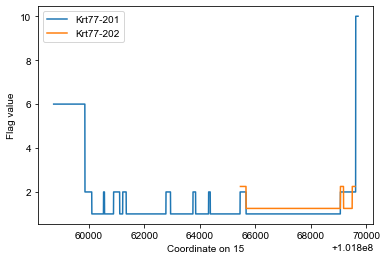

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Krt77_id_transcript:ENSMUST00000087996_name_Krt77-201_type_mRNA_strand_-_loc_15:101858731-101869705, size=2931
-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Krt77_id_transcript:ENSMUST00000229995_name_Krt77-202_type_lnc_RNA_strand_-_loc_15:101865465-101869596, size=418
- find mRNA for gene: Cnmd


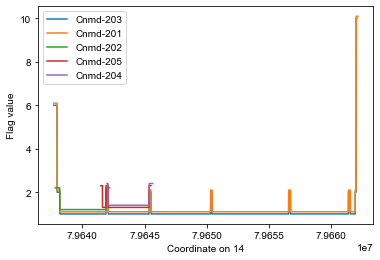

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Cnmd_id_transcript:ENSMUST00000165835_name_Cnmd-203_type_mRNA_strand_-_loc_14:79637690-79662084, size=1362
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Cnmd_id_transcript:ENSMUST00000022603_name_Cnmd-201_type_mRNA_strand_-_loc_14:79637693-79662170, size=1433
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Cnmd_id_transcript:ENSMUST00000165204_name_Cnmd-202_type_lnc_RNA_strand_-_loc_14:79637816-79642195, size=659
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Cnmd_id_transcript:ENSMUST00000172331_name_Cnmd-205_type_lnc_RNA_strand_-_loc_14:79641477-79645510, size=459
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Cnmd_id_transcript:ENSMUST00000167524_name_Cnmd-204_type_lnc_RNA_strand_-_loc_

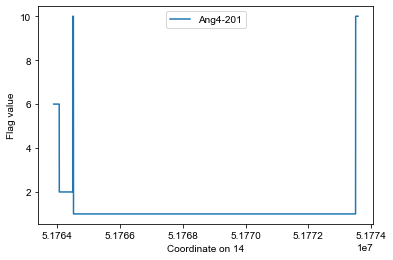

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Ang4_id_transcript:ENSMUST00000073860_name_Ang4-201_type_mRNA_strand_-_loc_14:51763878-51773590, size=709
- find mRNA for gene: Krt19


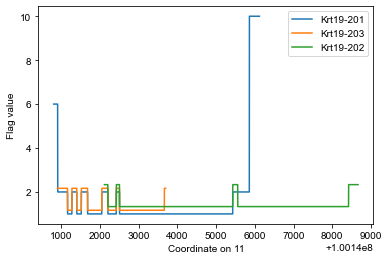

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt19_id_transcript:ENSMUST00000007317_name_Krt19-201_type_mRNA_strand_-_loc_11:100140810-100146120, size=1576
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt19_id_transcript:ENSMUST00000126460_name_Krt19-203_type_lnc_RNA_strand_-_loc_11:100140907-100143699, size=823
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt19_id_transcript:ENSMUST00000125888_name_Krt19-202_type_lnc_RNA_strand_-_loc_11:100142120-100148665, size=546
- find mRNA for gene: Mgp


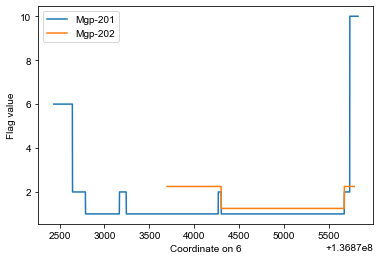

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Mgp_id_transcript:ENSMUST00000032342_name_Mgp-201_type_mRNA_strand_-_loc_6:136872435-136875823, size=617
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Mgp_id_transcript:ENSMUST00000203103_name_Mgp-202_type_lnc_RNA_strand_-_loc_6:136873697-136875781, size=715
- find mRNA for gene: Igf2


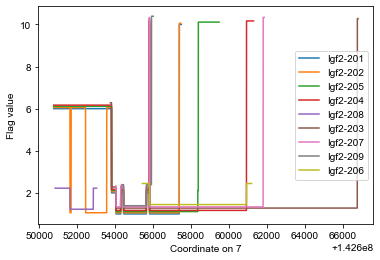

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Igf2_id_transcript:ENSMUST00000000033_name_Igf2-201_type_mRNA_strand_-_loc_7:142650766-142657496, size=3708
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Igf2_id_transcript:ENSMUST00000097936_name_Igf2-202_type_mRNA_strand_-_loc_7:142650769-142657466, size=2503
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Igf2_id_transcript:ENSMUST00000121128_name_Igf2-205_type_mRNA_strand_-_loc_7:142650769-142659489, size=4722
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Igf2_id_transcript:ENSMUST00000105936_name_Igf2-204_type_mRNA_strand_-_loc_7:142650769-142661305, size=3970
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Igf2_id_transcript:ENSMUST00000163148_name_Igf2-208_type_lnc_RNA_strand_-_loc_7:142

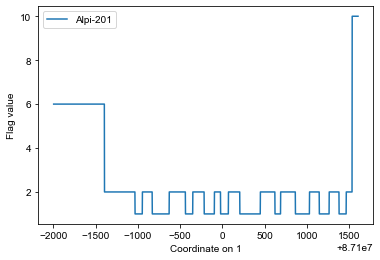

-- searching among 1 references
-- a match found in record: 1.
-- extracting transcript for gene_Alpi_id_transcript:ENSMUST00000113270_name_Alpi-201_type_mRNA_strand_-_loc_1:87098002-87101606, size=2337
- find mRNA for gene: Ghrl


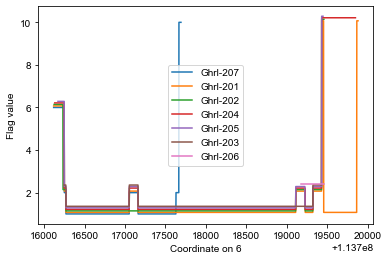

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Ghrl_id_transcript:ENSMUST00000204533_name_Ghrl-207_type_mRNA_strand_-_loc_6:113716119-113717692, size=323
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Ghrl_id_transcript:ENSMUST00000064993_name_Ghrl-201_type_mRNA_strand_-_loc_6:113716119-113719880, size=527
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Ghrl_id_transcript:ENSMUST00000203363_name_Ghrl-202_type_mRNA_strand_-_loc_6:113716124-113719458, size=400
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Ghrl_id_transcript:ENSMUST00000203770_name_Ghrl-204_type_mRNA_strand_-_loc_6:113716132-113719848, size=891
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Ghrl_id_transcript:ENSMUST00000204163_name_Ghrl-205_type_mRNA_strand_-_loc_6:113716172-

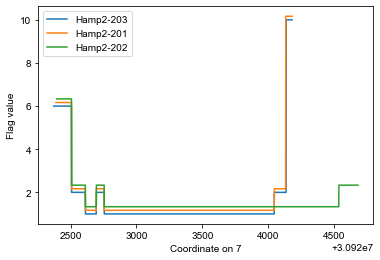

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Hamp2_id_transcript:ENSMUST00000217812_name_Hamp2-203_type_mRNA_strand_-_loc_7:30922372-30924181, size=437
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Hamp2_id_transcript:ENSMUST00000074671_name_Hamp2-201_type_mRNA_strand_-_loc_7:30922389-30924181, size=420
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Hamp2_id_transcript:ENSMUST00000205641_name_Hamp2-202_type_mRNA_strand_-_loc_7:30922395-30924681, size=424
- find mRNA for gene: Gm2a


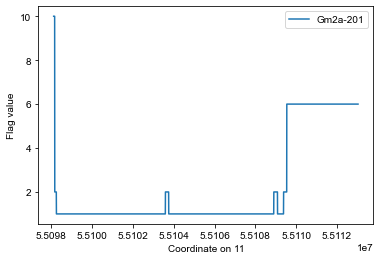

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Gm2a_id_transcript:ENSMUST00000000608_name_Gm2a-201_type_mRNA_strand_+_loc_11:55098115-55113029, size=4127
- find mRNA for gene: Krt9


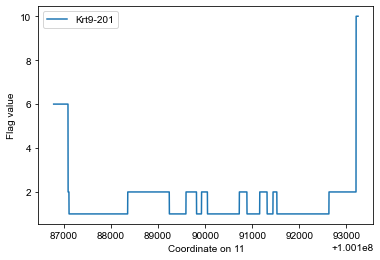

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Krt9_id_transcript:ENSMUST00000059707_name_Krt9-201_type_mRNA_strand_-_loc_11:100186781-100193246, size=2580
- find mRNA for gene: Reg4


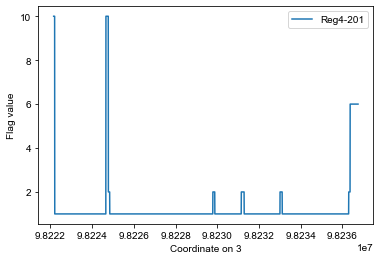

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Reg4_id_transcript:ENSMUST00000029469_name_Reg4-201_type_mRNA_strand_+_loc_3:98222156-98236748, size=1021
- find mRNA for gene: Isg15


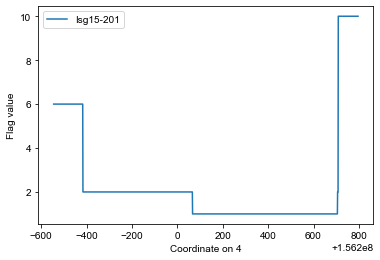

-- searching among 1 references
-- a match found in record: 4.
-- extracting transcript for gene_Isg15_id_transcript:ENSMUST00000085425_name_Isg15-201_type_mRNA_strand_-_loc_4:156199455-156200796, size=703
- find mRNA for gene: Calb2


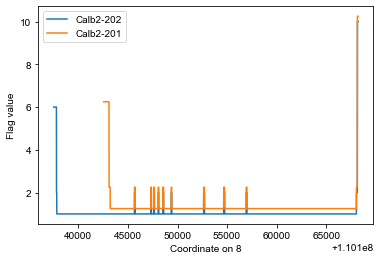

-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Calb2_id_transcript:ENSMUST00000212297_name_Calb2-202_type_mRNA_strand_-_loc_8:110137502-110168210, size=1080
-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Calb2_id_transcript:ENSMUST00000003754_name_Calb2-201_type_mRNA_strand_-_loc_8:110142538-110168206, size=1431
- find mRNA for gene: Zg16


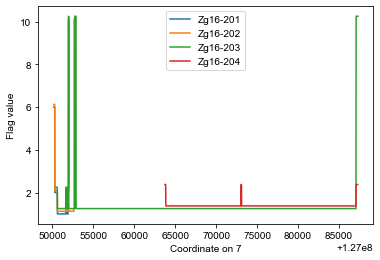

-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Zg16_id_transcript:ENSMUST00000051122_name_Zg16-201_type_mRNA_strand_-_loc_7:127050156-127051977, size=636
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Zg16_id_transcript:ENSMUST00000205424_name_Zg16-202_type_mRNA_strand_-_loc_7:127050156-127052675, size=682
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Zg16_id_transcript:ENSMUST00000205559_name_Zg16-203_type_mRNA_strand_-_loc_7:127050476-127087328, size=723
-- searching among 1 references
-- a match found in record: 7.
-- extracting transcript for gene_Zg16_id_transcript:ENSMUST00000205623_name_Zg16-204_type_lnc_RNA_strand_-_loc_7:127063735-127087286, size=378
- find mRNA for gene: Aldh3a1


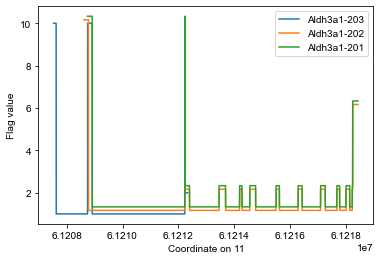

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Aldh3a1_id_transcript:ENSMUST00000147792_name_Aldh3a1-203_type_mRNA_strand_+_loc_11:61207537-61212333, size=361
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Aldh3a1_id_transcript:ENSMUST00000108716_name_Aldh3a1-202_type_mRNA_strand_+_loc_11:61208621-61218421, size=1721
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Aldh3a1_id_transcript:ENSMUST00000019246_name_Aldh3a1-201_type_mRNA_strand_+_loc_11:61208745-61218421, size=1729
- find mRNA for gene: Sftpd


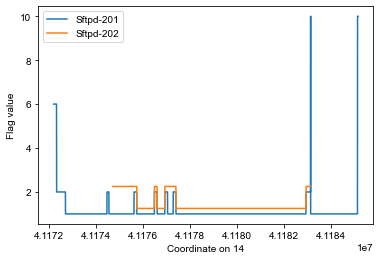

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Sftpd_id_transcript:ENSMUST00000077136_name_Sftpd-201_type_mRNA_strand_-_loc_14:41172214-41185149, size=1275
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Sftpd_id_transcript:ENSMUST00000225892_name_Sftpd-202_type_lnc_RNA_strand_-_loc_14:41174726-41183135, size=1809
- find mRNA for gene: Lcn3


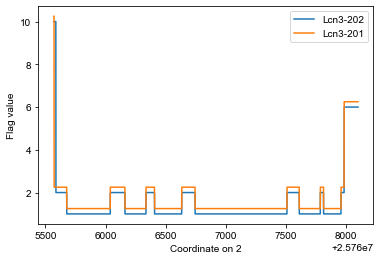

-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Lcn3_id_transcript:ENSMUST00000239498_name_Lcn3-202_type_mRNA_strand_+_loc_2:25765569-25768099, size=684
-- searching among 1 references
-- a match found in record: 2.
-- extracting transcript for gene_Lcn3_id_transcript:ENSMUST00000028304_name_Lcn3-201_type_mRNA_strand_+_loc_2:25765569-25768099, size=684
- find mRNA for gene: Sprr2i


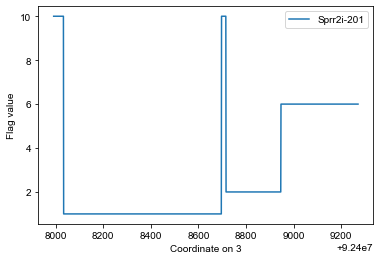

-- searching among 1 references
-- a match found in record: 3.
-- extracting transcript for gene_Sprr2i_id_transcript:ENSMUST00000047264_name_Sprr2i-201_type_mRNA_strand_+_loc_3:92407991-92409271, size=617
- find mRNA for gene: Reg3b


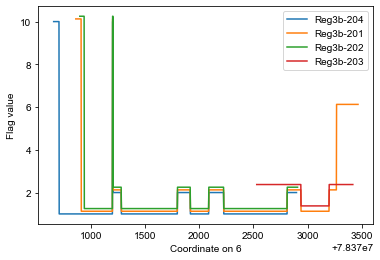

-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Reg3b_id_transcript:ENSMUST00000204873_name_Reg3b-204_type_mRNA_strand_+_loc_6:78370657-78372898, size=475
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Reg3b_id_transcript:ENSMUST00000096904_name_Reg3b-201_type_mRNA_strand_+_loc_6:78370861-78373466, size=783
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Reg3b_id_transcript:ENSMUST00000203266_name_Reg3b-202_type_mRNA_strand_+_loc_6:78370898-78372908, size=476
-- searching among 1 references
-- a match found in record: 6.
-- extracting transcript for gene_Reg3b_id_transcript:ENSMUST00000204760_name_Reg3b-203_type_lnc_RNA_strand_+_loc_6:78372531-78373418, size=628
- find mRNA for gene: Sftpa1


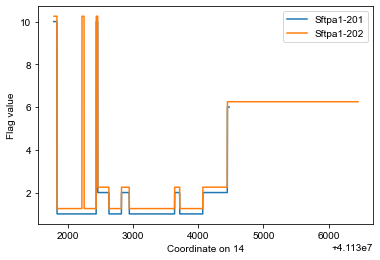

-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Sftpa1_id_transcript:ENSMUST00000022314_name_Sftpa1-201_type_mRNA_strand_+_loc_14:41131782-41134476, size=851
-- searching among 1 references
-- a match found in record: 14.
-- extracting transcript for gene_Sftpa1_id_transcript:ENSMUST00000170719_name_Sftpa1-202_type_mRNA_strand_+_loc_14:41131788-41136452, size=2854
- find mRNA for gene: Oas1h


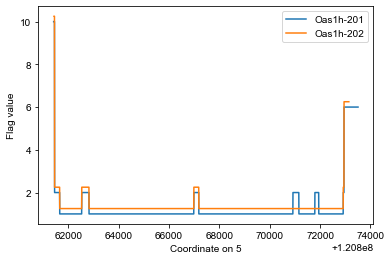

-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Oas1h_id_transcript:ENSMUST00000072476_name_Oas1h-201_type_mRNA_strand_+_loc_5:120861421-120873506, size=1703
-- searching among 1 references
-- a match found in record: 5.
-- extracting transcript for gene_Oas1h_id_transcript:ENSMUST00000171820_name_Oas1h-202_type_mRNA_strand_+_loc_5:120861438-120873141, size=931
- find mRNA for gene: Krt76


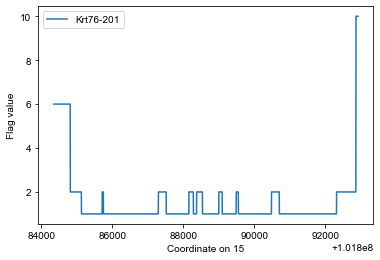

-- searching among 1 references
-- a match found in record: 15.
-- extracting transcript for gene_Krt76_id_transcript:ENSMUST00000100179_name_Krt76-201_type_mRNA_strand_-_loc_15:101884351-101892920, size=2312
- find mRNA for gene: Gsdma


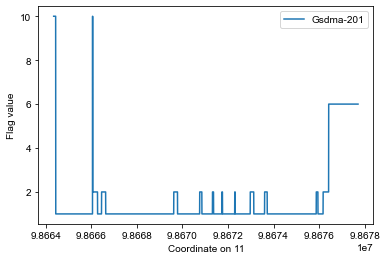

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Gsdma_id_transcript:ENSMUST00000017348_name_Gsdma-201_type_mRNA_strand_+_loc_11:98664351-98677708, size=2726
- find mRNA for gene: Ltf


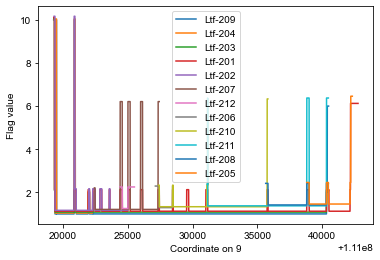

-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Ltf_id_transcript:ENSMUST00000198884_name_Ltf-209_type_mRNA_strand_+_loc_9:111019271-111040493, size=616
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Ltf_id_transcript:ENSMUST00000196777_name_Ltf-204_type_mRNA_strand_+_loc_9:111019292-111022463, size=567
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Ltf_id_transcript:ENSMUST00000196209_name_Ltf-203_type_mRNA_strand_+_loc_9:111019292-111040493, size=269
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Ltf_id_transcript:ENSMUST00000035077_name_Ltf-201_type_mRNA_strand_+_loc_9:111019292-111042767, size=2743
-- searching among 1 references
-- a match found in record: 9.
-- extracting transcript for gene_Ltf_id_transcript:ENSMUST00000196122_name_Ltf-202_type_mRNA_strand_+_loc_9:111019310-111025008

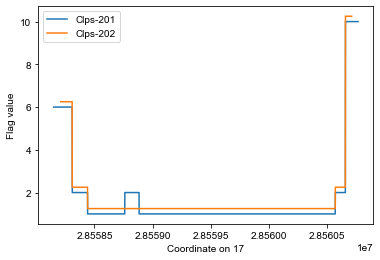

-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Clps_id_transcript:ENSMUST00000025062_name_Clps-201_type_mRNA_strand_-_loc_17:28558149-28560766, size=611
-- searching among 1 references
-- a match found in record: 17.
-- extracting transcript for gene_Clps_id_transcript:ENSMUST00000114785_name_Clps-202_type_mRNA_strand_-_loc_17:28558210-28560711, size=372
- find mRNA for gene: Col1a1


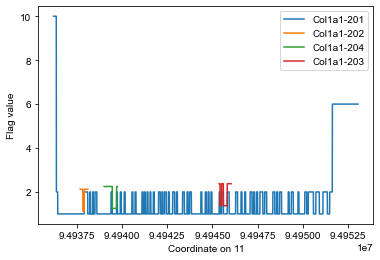

-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Col1a1_id_transcript:ENSMUST00000001547_name_Col1a1-201_type_mRNA_strand_+_loc_11:94936224-94953042, size=5930
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Col1a1_id_transcript:ENSMUST00000139974_name_Col1a1-202_type_lnc_RNA_strand_+_loc_11:94937686-94938103, size=337
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Col1a1_id_transcript:ENSMUST00000148593_name_Col1a1-204_type_lnc_RNA_strand_+_loc_11:94939012-94939741, size=493
-- searching among 1 references
-- a match found in record: 11.
-- extracting transcript for gene_Col1a1_id_transcript:ENSMUST00000148046_name_Col1a1-203_type_lnc_RNA_strand_+_loc_11:94945368-94946029, size=363
- find mRNA for gene: Gpx6


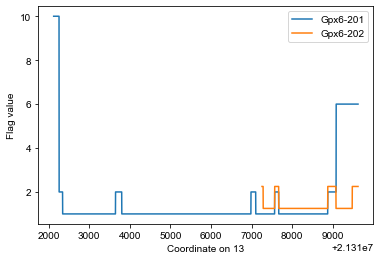

-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Gpx6_id_transcript:ENSMUST00000004453_name_Gpx6-201_type_mRNA_strand_+_loc_13:21312125-21319624, size=1340
-- searching among 1 references
-- a match found in record: 13.
-- extracting transcript for gene_Gpx6_id_transcript:ENSMUST00000136668_name_Gpx6-202_type_lnc_RNA_strand_+_loc_13:21317258-21319624, size=475
- find mRNA for gene: Plvap


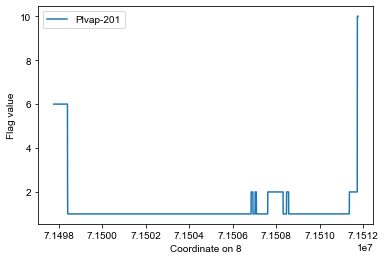

-- searching among 1 references
-- a match found in record: 8.
-- extracting transcript for gene_Plvap_id_transcript:ENSMUST00000048452_name_Plvap-201_type_mRNA_strand_-_loc_8:71497765-71511752, size=1987


In [17]:
# load smallest exons for given genes by sequence reader
mrna_record_dict = seq_rd.find_transcript_isoforms(gene_dicts, save=True)

In [18]:
isoform_folder = os.path.join(sequence_folder, 'isoforms')
if not os.path.exists(isoform_folder):
    print(f"create folder: {isoform_folder}.")
    os.makedirs(isoform_folder)
isoform_files = seq_rd._save_sequences_from_dict('isoform_mRNA_dict', isoform_folder, merge=True)

create folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms.
-- saving isoform_mRNA_dict sequences into folder: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Ccl21a_isoform_mRNA_merged_1_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Krt14_isoform_mRNA_merged_2_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Krt5_isoform_mRNA_merged_1_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Col6a1_isoform_mRNA_merged_2_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Lifr_isoform_mRNA_merged_8_isof

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Syt7_isoform_mRNA_merged_15_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Gpx3_isoform_mRNA_merged_3_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Foxa3_isoform_mRNA_merged_1_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Foxa2_isoform_mRNA_merged_4_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Ckb_isoform_mRNA_merged_5_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\Meg3_isoform_mRNA_merged_11_isoforms.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\s

In [ ]:
# clear the memory
del(seq_rd)

<a id='2'></a>
# 2. Design probe targeting sequences by probe_designer

run probe_designer, remeber to clear the memory usage because each table should take ~32GB

<a id='2.1'></a>
## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires mm10 genome

In [7]:
overwrite_table = False

### construct map for whole genome

In [8]:
reload(library_tools.design)
 
genome_table_file = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')

if not os.path.exists(genome_table_file) or overwrite_table:
    # genome
    _genome_filenames = [os.path.join(genome_folder, _fl) 
         for _fl in os.listdir(genome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_genome_filenames))

    ct = library_tools.design.countTable(word=17,save_file=genome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_genome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()

    # clear RAM if contructed countable 
    del(ct)

### construct map for transcriptome

In [9]:
from tqdm import tqdm
# transcriptome
transcriptome_folder = os.path.join(reference_folder, 'Transcriptome')

transcriptome_table_file = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy')

if not os.path.exists(transcriptome_table_file) or overwrite_table:
    # transcriptome
    _transcriptome_filenames = [os.path.join(transcriptome_folder, _fl) 
         for _fl in os.listdir(transcriptome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_transcriptome_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=transcriptome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_transcriptome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)

### construct map for repeats from RepBase

In [10]:
from tqdm import tqdm
# repeat
repeat_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\Repbase'

repeat_table_file = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

if not os.path.exists(repeat_table_file) or overwrite_table:
    # repeat
    _repeat_filenames = [os.path.join(repeat_folder, _fl) 
         for _fl in os.listdir(repeat_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_repeat_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=repeat_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_repeat_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)

### construct map for isoforms for this library

In [12]:
from tqdm import tqdm
# isoform
# RNA specific: get isoform files
isoform_folder = os.path.join(sequence_folder, 'isoforms')

isoform_table_file = os.path.join(isoform_folder, 'library_isoform_17w.npy')

if not os.path.exists(isoform_table_file) or overwrite_table:
    # isoform
    isoform_files = [os.path.join(isoform_folder, _fl) 
                     for _fl in os.listdir(isoform_folder) 
                     if _fl.split(os.extsep)[-1] == 'fasta' or _fl.split(os.extsep)[-1] == 'fa']
    print(len(isoform_files))
    
    ct = library_tools.design.countTable(word=17,save_file=isoform_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(isoform_files) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)

209
- Start multi-processing comsume 756 sequences 24 threads, finish in 4.169s
- Total sequences loaded: 1077035
Time to compute unique and clip: 0.34476733207702637
Time to update matrix: 0.5529382228851318
- start saving to file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\isoforms\library_isoform_17w.npy


<a id='2.2'></a>
## 2.2 Design probes

In [13]:
# required parameters
resolution = 0

## required folders
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire'

library_folder = os.path.join(pool_folder, f'Genes_intronic_RNA')
sequence_folder = os.path.join(library_folder, 'sequences')
report_folder = os.path.join(library_folder, 'reports')

In [15]:
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(reference_folder, 'GRCm38_genome_17w.npy')

transcriptome_index = os.path.join(reference_folder, 'GRCm38_transcriptome_17w.npy') 

repeat_index = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

isoform_folder = os.path.join(sequence_folder, 'isoforms')
isoform_index = os.path.join(isoform_folder, 'library_isoform_17w.npy')

# get input files 
input_files = glob.glob(os.path.join(sequence_folder, '*.fasta'))

print(f"{len(input_files)} regions loaded to design probes.")

if not os.path.exists(report_folder):
    os.makedirs(report_folder)
    
# filename to save probe reports
save_file = os.path.join(report_folder, f'merged_probes.pbr')
print(save_file)

1483 regions loaded to design probes.
\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\reports\merged_probes.pbr


### create pb_designer class

In [16]:
reload(library_tools)
reload(library_tools.design)

pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':True, # design reverse-complement of given sequences 
                  'two_stranded':False, # design two strands
                 },
    map_dic={#'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':True,'two_stranded':False}, # RNA specific
             'isoforms':{'file':isoform_index,'force_list':True,'rev_com':True,'two_stranded':False}, # RNA specific
             #'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True}, # DNA specific
             },
        save_file=save_file,
    params_dic={'word_size':17,'pb_len':30,'buffer_len':1,'max_count':2**16-1,
                'check_on_go': False, # whether automatically check probes
                'auto': False, # whether automatically convert reference maps
               },
    check_dic={#('genome','self_sequences'): (30-17+1)*2-5,
               'rep_genome': 0,
               ('transcriptome','isoforms'): 5, 
               'gc':[0.25,0.75],
               'tm': 37+0.62*30+5, # 37C incubation + 30% formamide + 5C for the melting curve
               'masks': ['AAAAA','TTTTT','CCCCC','GGGGG', # Quartet-repeats
                         'GAATTC','CTTAAG', # EcoRI sites
                         'GGTACC','CCATGG',], # KpnI sites
               }
    )
print(pb_designer)
pb_designer.load_from_file(load_probes_only=True)


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_complement (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 1483
    - save_file location: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\reports\merged_probes.pbr

- Fail to load from savefile: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\reports\merged_probes.pbr, file doesn't exist.


False

### calculate probe reports

In [17]:
reload(library_tools)
reload(library_tools.design)
overwrite_candidate_probes = False
if len(pb_designer.cand_probes) == 0 or overwrite_candidate_probes:
    pb_designer.computeOTmaps() # load the tables 
    pb_designer.compute_pb_report() # design candidate probes

-- setting attribute: map_transcriptome
--- finish map_transcriptome in 87.862s.
-- setting attribute: map_rep_genome
--- finish map_rep_genome in 83.877s.
-- setting attribute: map_isoforms
--- finish map_isoforms in 114.377s.
Time(s): 286.12437105178833
- Designing targeting sequence for 1483 regions
-- designing region: 19:44548572-44555440_reg_Ndufb8:- 0, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ndufb8_reg_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.167s.
in 1.501s.
-- designing region: gene_Ccl21a_id_gene:ENSMUSG00000094686_name_Ccl21a-201-smintron-1_type_smintron_strand_-_loc_4:42773765-42773851 1, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ccl21a_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.545s.
in 0.563s.
-- designing region: gene_Cc

--- finish map_self_sequences in 0.526s.
in 0.816s.
-- designing region: gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-3_type_smintron_strand_-_loc_10:76721977-76723375 22, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col6a1_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.527s.
in 0.819s.
-- designing region: gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-4_type_smintron_strand_-_loc_10:76721533-76721815 23, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col6a1_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.580s.
-- designing region: gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-5_type_smintron_strand_-_loc_10:76721285-76721402 24, input file: \\10.245.74.212\Chromatin_NAS_2\Libra

--- finish map_self_sequences in 0.520s.
in 0.536s.
-- designing region: gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-25_type_smintron_strand_-_loc_10:76713663-76713872 44, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col6a1_small_intron_25.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.533s.
in 0.572s.
-- designing region: gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-26_type_smintron_strand_-_loc_10:76713223-76713625 45, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col6a1_small_intron_26.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.517s.
in 0.595s.
-- designing region: gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-27_type_smintron_strand_-_loc_10:76712875-76713184 46, input file: \\10.245.74.212\Chromatin_NAS_2\

--- finish map_self_sequences in 0.523s.
in 0.928s.
-- designing region: gene_Lifr_id_gene:ENSMUSG00000054263_name_Lifr-203-smintron-14_type_smintron_strand_+_loc_15:7175707-7177431 66, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Lifr_small_intron_14.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.868s.
-- designing region: gene_Lifr_id_gene:ENSMUSG00000054263_name_Lifr-203-smintron-15_type_smintron_strand_+_loc_15:7177596-7177903 67, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Lifr_small_intron_15.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.516s.
in 0.576s.
-- designing region: gene_Lifr_id_gene:ENSMUSG00000054263_name_Lifr-203-smintron-16_type_smintron_strand_+_loc_15:7177976-7178798 68, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\

--- finish map_self_sequences in 0.526s.
in 0.745s.
-- designing region: gene_Itga6_id_gene:ENSMUSG00000027111_name_Itga6-205-smintron-13_type_smintron_strand_+_loc_2:71828016-71833695 88, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Itga6_small_intron_13.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.557s.
in 1.659s.
-- designing region: gene_Itga6_id_gene:ENSMUSG00000027111_name_Itga6-205-smintron-14_type_smintron_strand_+_loc_2:71833796-71834008 89, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Itga6_small_intron_14.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.525s.
in 0.564s.
-- designing region: gene_Itga6_id_gene:ENSMUSG00000027111_name_Itga6-205-smintron-15_type_smintron_strand_+_loc_2:71834072-71838080 90, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\C

--- finish map_self_sequences in 0.605s.
in 4.775s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-4_type_smintron_strand_-_loc_8:11246909-11247005 110, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.534s.
in 0.544s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-5_type_smintron_strand_-_loc_8:11245939-11246862 111, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_5.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.534s.
in 0.726s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-6_type_smintron_strand_-_loc_8:11245801-11245892 112, input file: \\10.245.74.212\Chromatin_NAS_2\Libra

--- finish map_self_sequences in 0.545s.
in 1.436s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-26_type_smintron_strand_-_loc_8:11226495-11226949 132, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_26.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.528s.
in 0.622s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-27_type_smintron_strand_-_loc_8:11223670-11226324 133, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_27.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.529s.
in 1.097s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-28_type_smintron_strand_-_loc_8:11223105-11223575 134, input file: \\10.245.74.212\Chromatin_NAS_2\

--- finish map_self_sequences in 0.527s.
in 0.778s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-48_type_smintron_strand_-_loc_8:11207408-11208232 154, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_48.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.526s.
in 0.698s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-49_type_smintron_strand_-_loc_8:11206405-11207193 155, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col4a1_small_intron_49.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.690s.
-- designing region: gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-50_type_smintron_strand_-_loc_8:11204554-11206225 156, input file: \\10.245.74.212\Chromatin_NAS_2\

--- finish map_self_sequences in 0.532s.
in 0.978s.
-- designing region: gene_Krt17_id_gene:ENSMUSG00000035557_name_Krt17-201-smintron-1_type_smintron_strand_-_loc_11:100259779-100260533 176, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt17_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.527s.
in 0.684s.
-- designing region: gene_Krt17_id_gene:ENSMUSG00000035557_name_Krt17-201-smintron-2_type_smintron_strand_-_loc_11:100259331-100259694 177, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt17_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.596s.
-- designing region: gene_Krt17_id_gene:ENSMUSG00000035557_name_Krt17-201-smintron-3_type_smintron_strand_-_loc_11:100258572-100259172 178, input file: \\10.245.74.212\Chromatin_NAS_2\Libr

--- finish map_self_sequences in 0.524s.
in 0.625s.
-- designing region: gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-16_type_smintron_strand_-_loc_17:57221175-57221322 198, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\C3_small_intron_16.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.523s.
in 0.549s.
-- designing region: gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-17_type_smintron_strand_-_loc_17:57220204-57220972 199, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\C3_small_intron_17.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.525s.
in 0.685s.
-- designing region: gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-18_type_smintron_strand_-_loc_17:57219974-57220093 200, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_i

--- finish map_self_sequences in 0.523s.
in 0.579s.
-- designing region: gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-39_type_smintron_strand_-_loc_17:57204552-57205296 221, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\C3_small_intron_39.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.529s.
in 0.686s.
-- designing region: gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-40_type_smintron_strand_-_loc_17:57204388-57204466 222, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\C3_small_intron_40.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.522s.
in 0.533s.
-- designing region: gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-41_type_smintron_strand_-_loc_17:57204155-57204250 223, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_i

--- finish map_self_sequences in 0.669s.
in 5.777s.
-- designing region: gene_Dclk1_id_gene:ENSMUSG00000027797_name_Dclk1-210-smintron-5_type_smintron_strand_+_loc_3:55380882-55450966 243, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Dclk1_small_intron_5.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.696s.
in 14.185s.
-- designing region: gene_Dclk1_id_gene:ENSMUSG00000027797_name_Dclk1-210-smintron-6_type_smintron_strand_+_loc_3:55451085-55461727 244, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Dclk1_small_intron_6.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.624s.
in 2.850s.
-- designing region: gene_Dclk1_id_gene:ENSMUSG00000027797_name_Dclk1-210-smintron-7_type_smintron_strand_+_loc_3:55462084-55463000 245, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CT

--- finish map_self_sequences in 0.523s.
in 0.792s.
-- designing region: gene_Trpm5_id_gene:ENSMUSG00000009246_name_Trpm5-203-smintron-6_type_smintron_strand_-_loc_7:143085311-143085455 265, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trpm5_small_intron_6.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.528s.
in 0.546s.
-- designing region: gene_Trpm5_id_gene:ENSMUSG00000009246_name_Trpm5-203-smintron-7_type_smintron_strand_-_loc_7:143084860-143085117 266, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Trpm5_small_intron_7.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.535s.
in 0.585s.
-- designing region: gene_Trpm5_id_gene:ENSMUSG00000009246_name_Trpm5-203-smintron-8_type_smintron_strand_-_loc_7:143083538-143084755 267, input file: \\10.245.74.212\Chromatin_NAS_2\Librari

--- finish map_self_sequences in 0.536s.
in 0.938s.
-- designing region: gene_Ly6g6f_id_gene:ENSMUSG00000034923_name_Ly6g6f-201-smintron-2_type_smintron_strand_-_loc_17:35083093-35083174 287, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ly6g6f_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.534s.
in 0.544s.
-- designing region: gene_Ly6g6f_id_gene:ENSMUSG00000034923_name_Ly6g6f-201-smintron-3_type_smintron_strand_-_loc_17:35081223-35082827 288, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ly6g6f_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.533s.
in 0.845s.
-- designing region: gene_Ly6g6f_id_gene:ENSMUSG00000034923_name_Ly6g6f-201-smintron-4_type_smintron_strand_-_loc_17:35080915-35081059 289, input file: \\10.245.74.212\Chromatin_NAS_2\Li

--- finish map_self_sequences in 0.536s.
in 0.797s.
-- designing region: gene_Avil_id_gene:ENSMUSG00000025432_name_Avil-203-smintron-19_type_smintron_strand_+_loc_10:127018513-127020449 309, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Avil_small_intron_19.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.536s.
in 0.922s.
-- designing region: gene_Alox5ap_id_gene:ENSMUSG00000060063_name_Alox5ap-204-smintron-1_type_smintron_strand_+_loc_5:149265183-149265346 310, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Alox5ap_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.537s.
in 0.555s.
-- designing region: gene_Alox5ap_id_gene:ENSMUSG00000060063_name_Alox5ap-204-smintron-2_type_smintron_strand_+_loc_5:149265391-149272380 311, input file: \\10.245.74.212\Chromatin_NAS

--- finish map_self_sequences in 0.526s.
in 0.544s.
-- designing region: gene_Plk2_id_gene:ENSMUSG00000021701_name_Plk2-204-smintron-3_type_smintron_strand_+_loc_13:110397888-110397973 331, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Plk2_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.523s.
in 0.540s.
-- designing region: gene_Plk2_id_gene:ENSMUSG00000021701_name_Plk2-204-smintron-4_type_smintron_strand_+_loc_13:110398123-110398372 332, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Plk2_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.526s.
in 0.576s.
-- designing region: gene_Plk2_id_gene:ENSMUSG00000021701_name_Plk2-204-smintron-5_type_smintron_strand_+_loc_13:110398810-110399020 333, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CT

--- finish map_self_sequences in 0.506s.
in 0.514s.
-- designing region: gene_Pik3r5_id_gene:ENSMUSG00000020901_name_Pik3r5-205-smintron-17_type_smintron_strand_+_loc_11:68495432-68495907 353, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pik3r5_small_intron_17.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.615s.
-- designing region: gene_Pik3r5_id_gene:ENSMUSG00000020901_name_Pik3r5-205-smintron-18_type_smintron_strand_+_loc_11:68496022-68496108 354, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pik3r5_small_intron_18.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.525s.
in 0.533s.
-- designing region: gene_Agt_id_gene:ENSMUSG00000031980_name_Agt-201-smintron-1_type_smintron_strand_-_loc_8:124564583-124569675 355, input file: \\10.245.74.212\Chromatin_NAS_2\Lib

--- finish map_self_sequences in 0.543s.
in 1.438s.
-- designing region: gene_Pou2f3_id_gene:ENSMUSG00000032015_name_Pou2f3-203-smintron-2_type_smintron_strand_-_loc_9:43199100-43205653 375, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pou2f3_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.546s.
in 1.849s.
-- designing region: gene_Pou2f3_id_gene:ENSMUSG00000032015_name_Pou2f3-203-smintron-3_type_smintron_strand_-_loc_9:43176322-43199029 376, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pou2f3_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.585s.
in 4.977s.
-- designing region: gene_Pou2f3_id_gene:ENSMUSG00000032015_name_Pou2f3-203-smintron-4_type_smintron_strand_-_loc_9:43146916-43176285 377, input file: \\10.245.74.212\Chromatin_NAS_2\Libra

--- finish map_self_sequences in 0.524s.
in 0.691s.
-- designing region: gene_Gp2_id_gene:ENSMUSG00000030954_name_Gp2-203-smintron-1_type_smintron_strand_-_loc_7:119457298-119459184 398, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gp2_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.527s.
in 0.910s.
-- designing region: gene_Gp2_id_gene:ENSMUSG00000030954_name_Gp2-203-smintron-2_type_smintron_strand_-_loc_7:119454650-119457160 399, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gp2_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.536s.
in 1.032s.
-- designing region: gene_Gp2_id_gene:ENSMUSG00000030954_name_Gp2-203-smintron-3_type_smintron_strand_-_loc_7:119452956-119454201 400, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\G

--- finish map_self_sequences in 0.532s.
in 0.794s.
-- designing region: gene_Fxyd3_id_gene:ENSMUSG00000057092_name_Fxyd3-208-smintron-3_type_smintron_strand_-_loc_7:31072291-31073018 420, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Fxyd3_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.532s.
in 0.683s.
-- designing region: gene_Fxyd3_id_gene:ENSMUSG00000057092_name_Fxyd3-208-smintron-4_type_smintron_strand_-_loc_7:31072099-31072180 421, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Fxyd3_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.526s.
in 0.538s.
-- designing region: gene_Tnfrsf11b_id_gene:ENSMUSG00000063727_name_Tnfrsf11b-201-smintron-1_type_smintron_strand_-_loc_15:54260172-54278214 422, input file: \\10.245.74.212\Chromatin_NAS_2\Libr

--- finish map_self_sequences in 0.524s.
in 0.714s.
-- designing region: gene_Pigr_id_gene:ENSMUSG00000026417_name_Pigr-203-smintron-9_type_smintron_strand_+_loc_1:130848632-130848990 442, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_9.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.526s.
in 0.604s.
-- designing region: gene_Pigr_id_gene:ENSMUSG00000026417_name_Pigr-203-smintron-10_type_smintron_strand_+_loc_1:130849120-130849487 443, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pigr_small_intron_10.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.527s.
in 0.600s.
-- designing region: gene_Pigr_id_gene:ENSMUSG00000026417_name_Pigr-203-smintron-11_type_smintron_strand_+_loc_1:130849621-130849730 444, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CT

--- finish map_self_sequences in 0.523s.
in 0.687s.
-- designing region: gene_Aldob_id_gene:ENSMUSG00000028307_name_Aldob-202-smintron-7_type_smintron_strand_-_loc_4:49538329-49538536 465, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Aldob_small_intron_7.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.514s.
in 0.554s.
-- designing region: gene_Aldob_id_gene:ENSMUSG00000028307_name_Aldob-202-smintron-8_type_smintron_strand_-_loc_4:49537140-49538127 466, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Aldob_small_intron_8.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.523s.
in 0.731s.
-- designing region: gene_Aldob_id_gene:ENSMUSG00000028307_name_Aldob-202-smintron-9_type_smintron_strand_-_loc_4:49536889-49537033 467, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP

--- finish map_self_sequences in 0.566s.
in 0.610s.
-- designing region: gene_Hnf4a_id_gene:ENSMUSG00000017950_name_Hnf4a-204-smintron-3_type_smintron_strand_+_loc_2:163547421-163550082 487, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Hnf4a_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.528s.
in 1.048s.
-- designing region: gene_Hnf4a_id_gene:ENSMUSG00000017950_name_Hnf4a-204-smintron-4_type_smintron_strand_+_loc_2:163550244-163551576 488, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Hnf4a_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.526s.
in 0.788s.
-- designing region: gene_Hnf4a_id_gene:ENSMUSG00000017950_name_Hnf4a-204-smintron-5_type_smintron_strand_+_loc_2:163551753-163552559 489, input file: \\10.245.74.212\Chromatin_NAS_2\Librari

--- finish map_self_sequences in 0.517s.
in 0.533s.
-- designing region: gene_Igf1_id_gene:ENSMUSG00000020053_name_Igf1-206-smintron-3_type_smintron_strand_+_loc_10:87859641-87860029 509, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igf1_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.525s.
in 0.605s.
-- designing region: gene_Igf1_id_gene:ENSMUSG00000020053_name_Igf1-206-smintron-4_type_smintron_strand_+_loc_10:87861387-87864730 510, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igf1_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.533s.
in 1.210s.
-- designing region: gene_Igf1_id_gene:ENSMUSG00000020053_name_Igf1-206-smintron-5_type_smintron_strand_+_loc_10:87864889-87913618 511, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_A

--- finish map_self_sequences in 0.524s.
in 0.789s.
-- designing region: gene_Lypd3_id_gene:ENSMUSG00000057454_name_Lypd3-201-smintron-1_type_smintron_strand_+_loc_7:24636675-24637124 531, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Lypd3_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.615s.
-- designing region: gene_Lypd3_id_gene:ENSMUSG00000057454_name_Lypd3-201-smintron-2_type_smintron_strand_+_loc_7:24637258-24638427 532, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Lypd3_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.522s.
in 0.772s.
-- designing region: gene_Lypd3_id_gene:ENSMUSG00000057454_name_Lypd3-201-smintron-3_type_smintron_strand_+_loc_7:24638600-24638913 533, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP

--- finish map_self_sequences in 0.653s.
in 7.724s.
-- designing region: gene_Tmem45a_id_gene:ENSMUSG00000022754_name_Tmem45a-202-smintron-3_type_smintron_strand_-_loc_16:56825860-56831703 553, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Tmem45a_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.581s.
in 1.835s.
-- designing region: gene_Tmem45a_id_gene:ENSMUSG00000022754_name_Tmem45a-202-smintron-4_type_smintron_strand_-_loc_16:56823596-56825665 554, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Tmem45a_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.543s.
in 0.991s.
-- designing region: gene_Tmem45a_id_gene:ENSMUSG00000022754_name_Tmem45a-202-smintron-5_type_smintron_strand_-_loc_16:56822411-56823387 555, input file: \\10.245.74.212\Chromatin_

--- finish map_self_sequences in 0.542s.
in 0.922s.
-- designing region: gene_Acpp_id_gene:ENSMUSG00000032561_name_Acpp-206-smintron-7_type_smintron_strand_-_loc_9:104309494-104314307 575, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Acpp_small_intron_7.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.542s.
in 1.564s.
-- designing region: gene_Acpp_id_gene:ENSMUSG00000032561_name_Acpp-206-smintron-8_type_smintron_strand_-_loc_9:104306990-104309409 576, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Acpp_small_intron_8.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.538s.
in 1.057s.
-- designing region: gene_Acpp_id_gene:ENSMUSG00000032561_name_Acpp-206-smintron-9_type_smintron_strand_-_loc_9:104301227-104306673 577, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-1

--- finish map_self_sequences in 0.526s.
in 0.657s.
-- designing region: gene_Ly6d_id_gene:ENSMUSG00000034634_name_Ly6d-201-smintron-2_type_smintron_strand_-_loc_15:74762589-74762750 597, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ly6d_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.523s.
in 0.553s.
-- designing region: gene_Gsta4_id_gene:ENSMUSG00000032348_name_Gsta4-201-smintron-1_type_smintron_strand_+_loc_9:78182907-78191790 598, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsta4_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.544s.
in 2.298s.
-- designing region: gene_Gsta4_id_gene:ENSMUSG00000032348_name_Gsta4-201-smintron-2_type_smintron_strand_+_loc_9:78192066-78198269 599, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-1

--- finish map_self_sequences in 0.531s.
in 1.231s.
-- designing region: gene_Gabrp_id_gene:ENSMUSG00000020159_name_Gabrp-202-smintron-7_type_smintron_strand_-_loc_11:33557069-33563865 619, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gabrp_small_intron_7.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.547s.
in 1.957s.
-- designing region: gene_Gabrp_id_gene:ENSMUSG00000020159_name_Gabrp-202-smintron-8_type_smintron_strand_-_loc_11:33555122-33556929 620, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gabrp_small_intron_8.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.550s.
in 0.950s.
-- designing region: gene_Gabrp_id_gene:ENSMUSG00000020159_name_Gabrp-202-smintron-9_type_smintron_strand_-_loc_11:33554483-33554967 621, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\

--- finish map_self_sequences in 0.525s.
in 0.739s.
-- designing region: gene_Anxa8_id_gene:ENSMUSG00000021950_name_Anxa8-202-smintron-3_type_smintron_strand_+_loc_14:34090703-34091800 641, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Anxa8_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.521s.
in 0.751s.
-- designing region: gene_Anxa8_id_gene:ENSMUSG00000021950_name_Anxa8-202-smintron-4_type_smintron_strand_+_loc_14:34091916-34092529 642, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Anxa8_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.517s.
in 0.647s.
-- designing region: gene_Anxa8_id_gene:ENSMUSG00000021950_name_Anxa8-202-smintron-5_type_smintron_strand_+_loc_14:34092622-34093377 643, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\

--- finish map_self_sequences in 0.523s.
in 0.676s.
-- designing region: gene_Mlph_id_gene:ENSMUSG00000026303_name_Mlph-203-smintron-14_type_smintron_strand_+_loc_1:90943751-90945613 663, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mlph_small_intron_14.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.527s.
in 0.897s.
-- designing region: gene_Mlph_id_gene:ENSMUSG00000026303_name_Mlph-203-smintron-15_type_smintron_strand_+_loc_1:90945716-90948582 664, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mlph_small_intron_15.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.527s.
in 1.106s.
-- designing region: gene_Foxa1_id_gene:ENSMUSG00000035451_name_Foxa1-202-smintron-1_type_smintron_strand_-_loc_12:57546123-57546780 665, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-

in 1.630s.
-- designing region: gene_Ccdc30_id_gene:ENSMUSG00000028637_name_Ccdc30-220-smintron-12_type_smintron_strand_-_loc_4:119359978-119367639 685, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ccdc30_small_intron_12.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.552s.
in 2.045s.
-- designing region: gene_Ccdc30_id_gene:ENSMUSG00000028637_name_Ccdc30-220-smintron-13_type_smintron_strand_-_loc_4:119356849-119359557 686, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ccdc30_small_intron_13.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.536s.
in 1.097s.
-- designing region: gene_Ccdc30_id_gene:ENSMUSG00000028637_name_Ccdc30-220-smintron-14_type_smintron_strand_-_loc_4:119353226-119356637 687, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_introni

--- finish map_self_sequences in 0.534s.
in 1.541s.
-- designing region: gene_Vpreb3_id_gene:ENSMUSG00000000903_name_Vpreb3-201-smintron-2_type_smintron_strand_+_loc_10:75948411-75949142 708, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Vpreb3_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.533s.
in 0.675s.
-- designing region: gene_Riiad1_id_gene:ENSMUSG00000028139_name_Riiad1-203-smintron-1_type_smintron_strand_-_loc_3:94473593-94480237 709, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Riiad1_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.547s.
in 1.853s.
-- designing region: gene_Riiad1_id_gene:ENSMUSG00000028139_name_Riiad1-203-smintron-2_type_smintron_strand_-_loc_3:94473321-94473495 710, input file: \\10.245.74.212\Chromatin_NAS_2\Libr

--- finish map_self_sequences in 0.573s.
in 3.736s.
-- designing region: gene_Car8_id_gene:ENSMUSG00000041261_name_Car8-201-smintron-3_type_smintron_strand_-_loc_4:8189394-8221549 730, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Car8_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.636s.
in 6.851s.
-- designing region: gene_Car8_id_gene:ENSMUSG00000041261_name_Car8-201-smintron-4_type_smintron_strand_-_loc_4:8185640-8189296 731, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Car8_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.568s.
in 1.304s.
-- designing region: gene_Car8_id_gene:ENSMUSG00000041261_name_Car8-201-smintron-5_type_smintron_strand_-_loc_4:8184634-8185575 732, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes

--- finish map_self_sequences in 0.556s.
in 1.077s.
-- designing region: gene_Stxbp5l_id_gene:ENSMUSG00000022829_name_Stxbp5l-207-smintron-8_type_smintron_strand_-_loc_16:37261969-37288286 752, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_8.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.595s.
in 5.699s.
-- designing region: gene_Stxbp5l_id_gene:ENSMUSG00000022829_name_Stxbp5l-207-smintron-9_type_smintron_strand_-_loc_16:37255934-37261883 753, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Stxbp5l_small_intron_9.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.562s.
in 1.741s.
-- designing region: gene_Stxbp5l_id_gene:ENSMUSG00000022829_name_Stxbp5l-207-smintron-10_type_smintron_strand_-_loc_16:37247950-37255808 754, input file: \\10.245.74.212\Chromatin

--- finish map_self_sequences in 0.527s.
in 0.546s.
-- designing region: gene_Igfbp5_id_gene:ENSMUSG00000026185_name_Igfbp5-202-smintron-1_type_smintron_strand_-_loc_1:72864082-72873805 774, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igfbp5_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.545s.
in 2.489s.
-- designing region: gene_Igfbp5_id_gene:ENSMUSG00000026185_name_Igfbp5-202-smintron-2_type_smintron_strand_-_loc_1:72863264-72863850 775, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igfbp5_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.539s.
in 0.648s.
-- designing region: gene_Igfbp5_id_gene:ENSMUSG00000026185_name_Igfbp5-202-smintron-3_type_smintron_strand_-_loc_1:72862509-72863142 776, input file: \\10.245.74.212\Chromatin_NAS_2\Libra

--- finish map_self_sequences in 0.550s.
in 2.653s.
-- designing region: gene_Rap1gap2_id_gene:ENSMUSG00000038807_name_Rap1gap2-204-smintron-12_type_smintron_strand_-_loc_11:74425237-74425911 796, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Rap1gap2_small_intron_12.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.539s.
in 0.680s.
-- designing region: gene_Rap1gap2_id_gene:ENSMUSG00000038807_name_Rap1gap2-204-smintron-13_type_smintron_strand_-_loc_11:74422515-74425181 797, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Rap1gap2_small_intron_13.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.540s.
in 1.106s.
-- designing region: gene_Rap1gap2_id_gene:ENSMUSG00000038807_name_Rap1gap2-204-smintron-14_type_smintron_strand_-_loc_11:74416334-74422429 798, input file: \\10.245.74.2

--- finish map_self_sequences in 0.524s.
in 0.608s.
-- designing region: gene_Celf3_id_gene:ENSMUSG00000028137_name_Celf3-203-smintron-7_type_smintron_strand_+_loc_3:94485403-94485496 818, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Celf3_small_intron_7.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.534s.
in 0.548s.
-- designing region: gene_Celf3_id_gene:ENSMUSG00000028137_name_Celf3-203-smintron-8_type_smintron_strand_+_loc_3:94485578-94486523 819, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Celf3_small_intron_8.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.724s.
-- designing region: gene_Celf3_id_gene:ENSMUSG00000028137_name_Celf3-203-smintron-9_type_smintron_strand_+_loc_3:94486669-94486793 820, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP

--- finish map_self_sequences in 0.529s.
in 0.565s.
-- designing region: gene_Gpx3_id_gene:ENSMUSG00000018339_name_Gpx3-203-smintron-2_type_smintron_strand_+_loc_11:54903054-54907126 840, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gpx3_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.531s.
in 1.365s.
-- designing region: gene_Gpx3_id_gene:ENSMUSG00000018339_name_Gpx3-203-smintron-3_type_smintron_strand_+_loc_11:54907282-54907763 841, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gpx3_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.535s.
in 0.632s.
-- designing region: gene_Gpx3_id_gene:ENSMUSG00000018339_name_Gpx3-203-smintron-4_type_smintron_strand_+_loc_11:54907861-54908540 842, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_A

--- finish map_self_sequences in 0.530s.
in 1.138s.
-- designing region: gene_Ckm_id_gene:ENSMUSG00000030399_name_Ckm-201-smintron-4_type_smintron_strand_+_loc_7:19414332-19414896 862, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ckm_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.521s.
in 0.640s.
-- designing region: gene_Ckm_id_gene:ENSMUSG00000030399_name_Ckm-201-smintron-5_type_smintron_strand_+_loc_7:19415053-19415400 863, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ckm_small_intron_5.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.522s.
in 0.592s.
-- designing region: gene_Ckm_id_gene:ENSMUSG00000030399_name_Ckm-201-smintron-6_type_smintron_strand_+_loc_7:19415535-19416718 864, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_i

--- finish map_self_sequences in 0.524s.
in 0.667s.
-- designing region: gene_Dbn1_id_gene:ENSMUSG00000034675_name_Dbn1-205-smintron-11_type_smintron_strand_-_loc_13:55475538-55476145 885, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Dbn1_small_intron_11.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.525s.
in 0.654s.
-- designing region: gene_Dbn1_id_gene:ENSMUSG00000034675_name_Dbn1-205-smintron-12_type_smintron_strand_-_loc_13:55474563-55474859 886, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Dbn1_small_intron_12.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.516s.
in 0.575s.
-- designing region: gene_Dbn1_id_gene:ENSMUSG00000034675_name_Dbn1-205-smintron-13_type_smintron_strand_-_loc_13:55474294-55474455 887, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP

--- finish map_self_sequences in 0.525s.
in 0.629s.
-- designing region: gene_Crabp1_id_gene:ENSMUSG00000032291_name_Crabp1-201-smintron-2_type_smintron_strand_+_loc_9:54765663-54768383 907, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Crabp1_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.531s.
in 1.110s.
-- designing region: gene_Crabp1_id_gene:ENSMUSG00000032291_name_Crabp1-201-smintron-3_type_smintron_strand_+_loc_9:54768499-54772825 908, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Crabp1_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.543s.
in 1.463s.
-- designing region: gene_Spp1_id_gene:ENSMUSG00000029304_name_Spp1-204-smintron-1_type_smintron_strand_+_loc_5:104435249-104436191 909, input file: \\10.245.74.212\Chromatin_NAS_2\Librari

--- finish map_self_sequences in 0.524s.
in 0.663s.
-- designing region: gene_Ptgds_id_gene:ENSMUSG00000015090_name_Ptgds-204-smintron-5_type_smintron_strand_-_loc_2:25467921-25468071 929, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ptgds_small_intron_5.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.516s.
in 0.544s.
-- designing region: gene_Ptgds_id_gene:ENSMUSG00000015090_name_Ptgds-204-smintron-6_type_smintron_strand_-_loc_2:25467346-25467817 930, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ptgds_small_intron_6.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.515s.
in 0.616s.
-- designing region: gene_Cck_id_gene:ENSMUSG00000032532_name_Cck-206-smintron-1_type_smintron_strand_-_loc_9:121494862-121495597 931, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-1

--- finish map_self_sequences in 0.685s.
in 6.148s.
-- designing region: gene_Pcp4_id_gene:ENSMUSG00000090223_name_Pcp4-203-smintron-2_type_smintron_strand_+_loc_16:96493869-96497225 951, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pcp4_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.557s.
in 1.223s.
-- designing region: gene_Pcp4_id_gene:ENSMUSG00000090223_name_Pcp4-203-smintron-3_type_smintron_strand_+_loc_16:96497408-96499619 952, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pcp4_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.595s.
in 1.110s.
-- designing region: gene_Pcp4_id_gene:ENSMUSG00000090223_name_Pcp4-203-smintron-4_type_smintron_strand_+_loc_16:96499825-96525389 953, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_A

--- finish map_self_sequences in 0.645s.
in 0.698s.
-- designing region: gene_Pgc_id_gene:ENSMUSG00000023987_name_Pgc-202-smintron-1_type_smintron_strand_+_loc_17:47726965-47728741 973, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pgc_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.657s.
in 1.010s.
-- designing region: gene_Pgc_id_gene:ENSMUSG00000023987_name_Pgc-202-smintron-2_type_smintron_strand_+_loc_17:47728903-47729251 974, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Pgc_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.525s.
in 0.586s.
-- designing region: gene_Pgc_id_gene:ENSMUSG00000023987_name_Pgc-202-smintron-3_type_smintron_strand_+_loc_17:47729371-47730093 975, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Gene

--- finish map_self_sequences in 0.524s.
in 0.824s.
-- designing region: gene_Cga_id_gene:ENSMUSG00000028298_name_Cga-202-smintron-2_type_smintron_strand_+_loc_4:34895639-34903992 995, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Cga_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.546s.
in 2.436s.
-- designing region: gene_Cga_id_gene:ENSMUSG00000028298_name_Cga-202-smintron-3_type_smintron_strand_+_loc_4:34904108-34905077 996, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Cga_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.667s.
in 0.912s.
-- designing region: gene_Cga_id_gene:ENSMUSG00000028298_name_Cga-202-smintron-4_type_smintron_strand_+_loc_4:34905264-34907065 997, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_i

--- finish map_self_sequences in 0.549s.
in 0.680s.
-- designing region: gene_Gm13539_id_gene:ENSMUSG00000085484_name_Gm13539-201-smintron-2_type_smintron_strand_+_loc_2:25783171-25783931 1017, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gm13539_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.733s.
in 0.912s.
-- designing region: gene_Gm13539_id_gene:ENSMUSG00000085484_name_Gm13539-201-smintron-3_type_smintron_strand_+_loc_2:25784007-25784213 1018, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gm13539_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.560s.
-- designing region: gene_Gm13539_id_gene:ENSMUSG00000085484_name_Gm13539-201-smintron-4_type_smintron_strand_+_loc_2:25784323-25784616 1019, input file: \\10.245.74.212\Chromatin_

--- finish map_self_sequences in 0.523s.
in 0.757s.
-- designing region: gene_Cilp_id_gene:ENSMUSG00000042254_name_Cilp-202-smintron-10_type_smintron_strand_+_loc_9:65276003-65277810 1039, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Cilp_small_intron_10.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.523s.
in 0.877s.
-- designing region: gene_Igfbp6_id_gene:ENSMUSG00000023046_name_Igfbp6-201-smintron-1_type_smintron_strand_+_loc_15:102144885-102147844 1040, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igfbp6_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.526s.
in 1.121s.
-- designing region: gene_Igfbp6_id_gene:ENSMUSG00000023046_name_Igfbp6-201-smintron-2_type_smintron_strand_+_loc_15:102147980-102148101 1041, input file: \\10.245.74.212\Chromatin_NAS_2\

--- finish map_self_sequences in 0.516s.
in 0.579s.
-- designing region: gene_Tac1_id_gene:ENSMUSG00000061762_name_Tac1-202-smintron-4_type_smintron_strand_+_loc_6:7556782-7557215 1062, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Tac1_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.519s.
in 0.595s.
-- designing region: gene_Tac1_id_gene:ENSMUSG00000061762_name_Tac1-202-smintron-5_type_smintron_strand_+_loc_6:7557262-7557719 1063, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Tac1_small_intron_5.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.529s.
in 0.617s.
-- designing region: gene_Tac1_id_gene:ENSMUSG00000061762_name_Tac1-202-smintron-6_type_smintron_strand_+_loc_6:7557745-7559098 1064, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Ge

--- finish map_self_sequences in 0.514s.
in 0.612s.
-- designing region: gene_Gatm_id_gene:ENSMUSG00000027199_name_Gatm-202-smintron-1_type_smintron_strand_-_loc_2:122609889-122611147 1085, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gatm_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.516s.
in 0.770s.
-- designing region: gene_Gatm_id_gene:ENSMUSG00000027199_name_Gatm-202-smintron-2_type_smintron_strand_-_loc_2:122603779-122609668 1086, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gatm_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.535s.
in 1.685s.
-- designing region: gene_Gatm_id_gene:ENSMUSG00000027199_name_Gatm-202-smintron-3_type_smintron_strand_-_loc_2:122602697-122603581 1087, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CT

- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.538s.
-- designing region: gene_Ecm1_id_gene:ENSMUSG00000028108_name_Ecm1-208-smintron-4_type_smintron_strand_-_loc_3:95737059-95737349 1108, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ecm1_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.520s.
in 0.576s.
-- designing region: gene_Ecm1_id_gene:ENSMUSG00000028108_name_Ecm1-208-smintron-5_type_smintron_strand_-_loc_3:95736793-95737012 1109, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ecm1_small_intron_5.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.521s.
in 0.560s.
-- designing region: gene_Ecm1_id_gene:ENSMUSG00000028108_name_Ecm1-208-smintron-6_type_smintron_strand_-_loc_3:95736223-95736471 1110, input file: \\10.245.74.212\Chromatin

--- finish map_self_sequences in 0.579s.
in 0.624s.
-- designing region: gene_Ccl1_id_gene:ENSMUSG00000020702_name_Ccl1-201-smintron-9_type_smintron_strand_-_loc_11:82179814-82196746 1130, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ccl1_small_intron_9.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.566s.
in 3.941s.
-- designing region: gene_Ccl1_id_gene:ENSMUSG00000020702_name_Ccl1-201-smintron-10_type_smintron_strand_-_loc_11:82178135-82179668 1131, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ccl1_small_intron_10.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.543s.
in 0.857s.
-- designing region: gene_Ccl1_id_gene:ENSMUSG00000020702_name_Ccl1-201-smintron-11_type_smintron_strand_-_loc_11:82177011-82178018 1132, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CT

--- finish map_self_sequences in 0.528s.
in 0.737s.
-- designing region: gene_Krt71_id_gene:ENSMUSG00000051879_name_Krt71-201-smintron-8_type_smintron_strand_-_loc_15:101734709-101735438 1153, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt71_small_intron_8.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.669s.
-- designing region: gene_Cryaa_id_gene:ENSMUSG00000024041_name_Cryaa-205-smintron-1_type_smintron_strand_+_loc_17:31678190-31678448 1154, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Cryaa_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.522s.
in 0.569s.
-- designing region: gene_Cryaa_id_gene:ENSMUSG00000024041_name_Cryaa-205-smintron-2_type_smintron_strand_+_loc_17:31678698-31679479 1155, input file: \\10.245.74.212\Chromatin_NAS_2\Libra

--- finish map_self_sequences in 0.523s.
in 0.667s.
-- designing region: gene_Fgg_id_gene:ENSMUSG00000033860_name_Fgg-202-smintron-7_type_smintron_strand_+_loc_3:83011531-83012763 1175, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Fgg_small_intron_7.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.526s.
in 0.769s.
-- designing region: gene_Fgg_id_gene:ENSMUSG00000033860_name_Fgg-202-smintron-8_type_smintron_strand_+_loc_3:83013043-83014137 1176, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Fgg_small_intron_8.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.526s.
in 0.739s.
-- designing region: gene_Fgg_id_gene:ENSMUSG00000033860_name_Fgg-202-smintron-9_type_smintron_strand_+_loc_3:83014707-83014834 1177, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Gene

--- finish map_self_sequences in 0.537s.
in 1.316s.
-- designing region: gene_Idi2_id_gene:ENSMUSG00000033520_name_Idi2-201-smintron-2_type_smintron_strand_+_loc_13:8956954-8957796 1197, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Idi2_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.527s.
in 0.692s.
-- designing region: gene_Idi2_id_gene:ENSMUSG00000033520_name_Idi2-201-smintron-3_type_smintron_strand_+_loc_13:8957891-8958442 1198, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Idi2_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.525s.
in 0.629s.
-- designing region: gene_Idi2_id_gene:ENSMUSG00000033520_name_Idi2-201-smintron-4_type_smintron_strand_+_loc_13:8958575-8959114 1199, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire

--- finish map_self_sequences in 0.526s.
in 0.613s.
-- designing region: gene_Car4_id_gene:ENSMUSG00000000805_name_Car4-202-smintron-4_type_smintron_strand_+_loc_11:84962557-84963337 1219, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Car4_small_intron_4.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.678s.
-- designing region: gene_Car4_id_gene:ENSMUSG00000000805_name_Car4-202-smintron-5_type_smintron_strand_+_loc_11:84963495-84964092 1220, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Car4_small_intron_5.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.638s.
-- designing region: gene_Car4_id_gene:ENSMUSG00000000805_name_Car4-202-smintron-6_type_smintron_strand_+_loc_11:84964240-84964346 1221, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-1

--- finish map_self_sequences in 0.572s.
in 3.687s.
-- designing region: gene_Mal_id_gene:ENSMUSG00000027375_name_Mal-201-smintron-2_type_smintron_strand_-_loc_2:127638716-127640220 1241, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mal_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.544s.
in 0.846s.
-- designing region: gene_Mal_id_gene:ENSMUSG00000027375_name_Mal-201-smintron-3_type_smintron_strand_-_loc_2:127635055-127638588 1242, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Mal_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.534s.
in 1.235s.
-- designing region: gene_Alpl_id_gene:ENSMUSG00000028766_name_Alpl-207-smintron-1_type_smintron_strand_-_loc_4:137796232-137796241 Too short the sequence, skip.
-- designing region: gene_Alpl_id_gene

--- finish map_self_sequences in 0.526s.
in 0.686s.
-- designing region: gene_Krt77_id_gene:ENSMUSG00000067594_name_Krt77-202-smintron-5_type_smintron_strand_-_loc_15:101861346-101862777 1264, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt77_small_intron_5.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.527s.
in 0.813s.
-- designing region: gene_Krt77_id_gene:ENSMUSG00000067594_name_Krt77-202-smintron-6_type_smintron_strand_-_loc_15:101861111-101861218 1265, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Krt77_small_intron_6.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.542s.
-- designing region: gene_Krt77_id_gene:ENSMUSG00000067594_name_Krt77-202-smintron-7_type_smintron_strand_-_loc_15:101860563-101860888 1266, input file: \\10.245.74.212\Chromatin_NAS_2\L

--- finish map_self_sequences in 0.524s.
in 0.596s.
-- designing region: gene_Igf2_id_gene:ENSMUSG00000048583_name_Igf2-206-smintron-1_type_smintron_strand_-_loc_7:142661872-142666775 1286, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igf2_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.537s.
in 1.515s.
-- designing region: gene_Igf2_id_gene:ENSMUSG00000048583_name_Igf2-206-smintron-2_type_smintron_strand_-_loc_7:142661307-142661810 1287, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Igf2_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.530s.
in 0.632s.
-- designing region: gene_Igf2_id_gene:ENSMUSG00000048583_name_Igf2-206-smintron-3_type_smintron_strand_-_loc_7:142659491-142660931 1288, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CT

--- finish map_self_sequences in 0.525s.
in 0.780s.
-- designing region: gene_Hamp2_id_gene:ENSMUSG00000056978_name_Hamp2-202-smintron-3_type_smintron_strand_-_loc_7:30922613-30922695 1309, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Hamp2_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.522s.
in 0.534s.
-- designing region: gene_Gm2a_id_gene:ENSMUSG00000000594_name_Gm2a-201-smintron-1_type_smintron_strand_+_loc_11:55098245-55103586 1310, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gm2a_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.537s.
in 1.601s.
-- designing region: gene_Gm2a_id_gene:ENSMUSG00000000594_name_Gm2a-201-smintron-2_type_smintron_strand_+_loc_11:55103750-55108897 1311, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP

--- finish map_self_sequences in 0.527s.
in 0.675s.
-- designing region: gene_Calb2_id_gene:ENSMUSG00000003657_name_Calb2-201-smintron-6_type_smintron_strand_-_loc_8:110148100-110148513 1331, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Calb2_small_intron_6.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.601s.
-- designing region: gene_Calb2_id_gene:ENSMUSG00000003657_name_Calb2-201-smintron-7_type_smintron_strand_-_loc_8:110147656-110148042 1332, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Calb2_small_intron_7.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.522s.
in 0.601s.
-- designing region: gene_Calb2_id_gene:ENSMUSG00000003657_name_Calb2-201-smintron-8_type_smintron_strand_-_loc_8:110147356-110147614 1333, input file: \\10.245.74.212\Chromatin_NAS_2\Libr

--- finish map_self_sequences in 0.523s.
in 0.587s.
-- designing region: gene_Aldh3a1_id_gene:ENSMUSG00000019102_name_Aldh3a1-201-smintron-10_type_smintron_strand_+_loc_11:61217764-61217990 1353, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Aldh3a1_small_intron_10.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.530s.
in 0.571s.
-- designing region: gene_Aldh3a1_id_gene:ENSMUSG00000019102_name_Aldh3a1-201-smintron-11_type_smintron_strand_+_loc_11:61218123-61218213 1354, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Aldh3a1_small_intron_11.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.515s.
in 0.537s.
-- designing region: gene_Sftpd_id_gene:ENSMUSG00000021795_name_Sftpd-202-smintron-1_type_smintron_strand_-_loc_14:41183137-41185124 1355, input file: \\10.245.74.212\Chromat

--- finish map_self_sequences in 0.520s.
in 0.593s.
-- designing region: gene_Sftpa1_id_gene:ENSMUSG00000021789_name_Sftpa1-202-smintron-2_type_smintron_strand_+_loc_14:41132250-41132434 1375, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Sftpa1_small_intron_2.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.513s.
in 0.549s.
-- designing region: gene_Sftpa1_id_gene:ENSMUSG00000021789_name_Sftpa1-202-smintron-3_type_smintron_strand_+_loc_14:41132631-41132821 1376, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Sftpa1_small_intron_3.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.518s.
in 0.551s.
-- designing region: gene_Sftpa1_id_gene:ENSMUSG00000021789_name_Sftpa1-202-smintron-4_type_smintron_strand_+_loc_14:41132943-41133637 1377, input file: \\10.245.74.212\Chromatin_NAS_2

- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.525s.
in 0.613s.
-- designing region: gene_Gsdma_id_gene:ENSMUSG00000017204_name_Gsdma-201-smintron-6_type_smintron_strand_+_loc_11:98671367-98671730 1397, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_6.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.518s.
in 0.586s.
-- designing region: gene_Gsdma_id_gene:ENSMUSG00000017204_name_Gsdma-201-smintron-7_type_smintron_strand_+_loc_11:98671759-98672294 1398, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Gsdma_small_intron_7.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.518s.
in 0.619s.
-- designing region: gene_Gsdma_id_gene:ENSMUSG00000017204_name_Gsdma-201-smintron-8_type_smintron_strand_+_loc_11:98672317-98672975 1399, input file: \\10.245.74.21

--- finish map_self_sequences in 0.526s.
in 0.789s.
-- designing region: gene_Ltf_id_gene:ENSMUSG00000032496_name_Ltf-205-smintron-17_type_smintron_strand_+_loc_9:111040519-111042147 1419, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Ltf_small_intron_17.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
in 0.851s.
-- designing region: gene_Clps_id_gene:ENSMUSG00000024225_name_Clps-202-smintron-1_type_smintron_strand_-_loc_17:28558885-28560570 1420, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Clps_small_intron_1.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.520s.
in 0.866s.
-- designing region: gene_Clps_id_gene:ENSMUSG00000024225_name_Clps-202-smintron-2_type_smintron_strand_-_loc_17:28558441-28558760 1421, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-1

--- finish map_self_sequences in 0.521s.
in 0.534s.
-- designing region: gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-20_type_smintron_strand_+_loc_11:94942442-94942559 1441, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col1a1_small_intron_20.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.521s.
in 0.539s.
-- designing region: gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-21_type_smintron_strand_+_loc_11:94942615-94942794 1442, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col1a1_small_intron_21.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.521s.
in 0.552s.
-- designing region: gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-22_type_smintron_strand_+_loc_11:94942904-94943005 1443, input file: \\10.245.74.212\Chromatin_

--- finish map_self_sequences in 0.523s.
in 0.585s.
-- designing region: gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-42_type_smintron_strand_+_loc_11:94948441-94948542 1463, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col1a1_small_intron_42.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.521s.
in 0.537s.
-- designing region: gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-43_type_smintron_strand_+_loc_11:94948598-94948705 1464, input file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\sequences\Col1a1_small_intron_43.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.520s.
in 0.537s.
-- designing region: gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-44_type_smintron_strand_+_loc_11:94948815-94949180 1465, input file: \\10.245.74.212\Chromatin_

### check probes

In [18]:
overwrite_filtered_probes = False

if len(pb_designer.kept_probes) == 0 or overwrite_filtered_probes:
    pbs, pb_scores = pb_designer.check_probes()

-- check region:0 19:44548572-44555440_reg_Ndufb8:-, 6828 candidate probes
--- 2539 probes passed check_dic selection.
finish in 0.353s, 96 probes kept.
-- check region:1 gene_Ccl21a_id_gene:ENSMUSG00000094686_name_Ccl21a-201-smintron-1_type_smintron_strand_-_loc_4:42773765-42773851, 58 candidate probes
--- 31 probes passed check_dic selection.
finish in 0.004s, 2 probes kept.
-- check region:2 gene_Ccl21a_id_gene:ENSMUSG00000094686_name_Ccl21a-201-smintron-2_type_smintron_strand_-_loc_4:42773550-42773642, 64 candidate probes
--- 63 probes passed check_dic selection.
finish in 0.006s, 3 probes kept.
-- check region:3 gene_Ccl21a_id_gene:ENSMUSG00000094686_name_Ccl21a-201-smintron-3_type_smintron_strand_-_loc_4:42773284-42773365, 53 candidate probes
--- 51 probes passed check_dic selection.
finish in 0.005s, 1 probes kept.
-- check region:4 gene_Krt14_id_gene:ENSMUSG00000045545_name_Krt14-201-smintron-1_type_smintron_strand_-_loc_11:100206032-100206912, 852 candidate probes
--- 621 prob

-- check region:36 gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-17_type_smintron_strand_-_loc_10:76717166-76717261, 67 candidate probes
--- 66 probes passed check_dic selection.
finish in 0.006s, 3 probes kept.
-- check region:37 gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-18_type_smintron_strand_-_loc_10:76716783-76717128, 317 candidate probes
--- 291 probes passed check_dic selection.
finish in 0.028s, 10 probes kept.
-- check region:38 gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-19_type_smintron_strand_-_loc_10:76716325-76716718, 365 candidate probes
--- 319 probes passed check_dic selection.
finish in 0.028s, 10 probes kept.
-- check region:39 gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-202-smintron-20_type_smintron_strand_-_loc_10:76715335-76716260, 897 candidate probes
--- 787 probes passed check_dic selection.
finish in 0.063s, 28 probes kept.
-- check region:40 gene_Col6a1_id_gene:ENSMUSG00000001119_name_Col6a1-2

-- check region:72 gene_Lifr_id_gene:ENSMUSG00000054263_name_Lifr-203-smintron-20_type_smintron_strand_+_loc_15:7185735-7186865, 1102 candidate probes
--- 816 probes passed check_dic selection.
finish in 0.078s, 29 probes kept.
-- check region:73 gene_Lifr_id_gene:ENSMUSG00000054263_name_Lifr-203-smintron-21_type_smintron_strand_+_loc_15:7187029-7188074, 1017 candidate probes
--- 810 probes passed check_dic selection.
finish in 0.064s, 29 probes kept.
-- check region:74 gene_Lifr_id_gene:ENSMUSG00000054263_name_Lifr-203-smintron-22_type_smintron_strand_+_loc_15:7188170-7190114, 1915 candidate probes
--- 1409 probes passed check_dic selection.
finish in 0.137s, 48 probes kept.
-- check region:75 gene_Lifr_id_gene:ENSMUSG00000054263_name_Lifr-203-smintron-23_type_smintron_strand_+_loc_15:7190195-7190545, 322 candidate probes
--- 225 probes passed check_dic selection.
finish in 0.023s, 9 probes kept.
-- check region:76 gene_Itga6_id_gene:ENSMUSG00000027111_name_Itga6-205-smintron-1_type_s

--- 24743 probes passed check_dic selection.
finish in 2.025s, 889 probes kept.
-- check region:108 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-2_type_smintron_strand_-_loc_8:11267658-11279620, 11909 candidate probes
--- 9440 probes passed check_dic selection.
finish in 0.768s, 329 probes kept.
-- check region:109 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-3_type_smintron_strand_-_loc_8:11247097-11267596, 20444 candidate probes
--- 16008 probes passed check_dic selection.
finish in 1.323s, 567 probes kept.
-- check region:110 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-4_type_smintron_strand_-_loc_8:11246909-11247005, 68 candidate probes
--- 49 probes passed check_dic selection.
finish in 0.000s, 2 probes kept.
-- check region:111 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-5_type_smintron_strand_-_loc_8:11245939-11246862, 895 candidate probes
--- 710 probes passed check_dic selection.
finish in 0.061s, 25

-- check region:143 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-37_type_smintron_strand_-_loc_8:11218054-11218680, 598 candidate probes
--- 471 probes passed check_dic selection.
finish in 0.048s, 17 probes kept.
-- check region:144 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-38_type_smintron_strand_-_loc_8:11217562-11217912, 322 candidate probes
--- 293 probes passed check_dic selection.
finish in 0.018s, 10 probes kept.
-- check region:145 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-39_type_smintron_strand_-_loc_8:11217347-11217433, 58 candidate probes
--- 53 probes passed check_dic selection.
finish in 0.010s, 2 probes kept.
-- check region:146 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-205-smintron-40_type_smintron_strand_-_loc_8:11216801-11217264, 435 candidate probes
--- 322 probes passed check_dic selection.
finish in 0.030s, 13 probes kept.
-- check region:147 gene_Col4a1_id_gene:ENSMUSG00000031502_name_Col4a1-

-- check region:179 gene_Krt17_id_gene:ENSMUSG00000035557_name_Krt17-201-smintron-4_type_smintron_strand_-_loc_11:100257870-100258408, 510 candidate probes
--- 433 probes passed check_dic selection.
finish in 0.039s, 16 probes kept.
-- check region:180 gene_Krt17_id_gene:ENSMUSG00000035557_name_Krt17-201-smintron-5_type_smintron_strand_-_loc_11:100257655-100257742, 59 candidate probes
--- 57 probes passed check_dic selection.
finish in 0.008s, 2 probes kept.
-- check region:181 gene_Krt17_id_gene:ENSMUSG00000035557_name_Krt17-201-smintron-6_type_smintron_strand_-_loc_11:100257347-100257432, 57 candidate probes
--- 48 probes passed check_dic selection.
finish in 0.008s, 2 probes kept.
-- check region:182 gene_Krt17_id_gene:ENSMUSG00000035557_name_Krt17-201-smintron-7_type_smintron_strand_-_loc_11:100256497-100257319, 794 candidate probes
--- 700 probes passed check_dic selection.
finish in 0.050s, 24 probes kept.
-- check region:183 gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintro

-- check region:216 gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-34_type_smintron_strand_-_loc_17:57207621-57209238, 1564 candidate probes
--- 1223 probes passed check_dic selection.
finish in 0.099s, 44 probes kept.
-- check region:217 gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-35_type_smintron_strand_-_loc_17:57207425-57207531, 78 candidate probes
--- 28 probes passed check_dic selection.
finish in 0.008s, 1 probes kept.
-- check region:218 gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-36_type_smintron_strand_-_loc_17:57206297-57207333, 1008 candidate probes
--- 786 probes passed check_dic selection.
finish in 0.079s, 29 probes kept.
-- check region:219 gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-37_type_smintron_strand_-_loc_17:57205747-57206189, 414 candidate probes
--- 349 probes passed check_dic selection.
finish in 0.030s, 13 probes kept.
-- check region:220 gene_C3_id_gene:ENSMUSG00000024164_name_C3-202-smintron-38_type_smintron_str

-- check region:252 gene_Dclk1_id_gene:ENSMUSG00000027797_name_Dclk1-210-smintron-14_type_smintron_strand_+_loc_3:55489898-55500034, 9995 candidate probes
--- 7356 probes passed check_dic selection.
finish in 0.626s, 268 probes kept.
-- check region:253 gene_Dclk1_id_gene:ENSMUSG00000027797_name_Dclk1-210-smintron-15_type_smintron_strand_+_loc_3:55500170-55502372, 1814 candidate probes
--- 1350 probes passed check_dic selection.
finish in 0.119s, 50 probes kept.
-- check region:254 gene_Dclk1_id_gene:ENSMUSG00000027797_name_Dclk1-210-smintron-16_type_smintron_strand_+_loc_3:55502452-55502808, 328 candidate probes
--- 226 probes passed check_dic selection.
finish in 0.020s, 9 probes kept.
-- check region:255 gene_Dclk1_id_gene:ENSMUSG00000027797_name_Dclk1-210-smintron-17_type_smintron_strand_+_loc_3:55502907-55506700, 3582 candidate probes
--- 2011 probes passed check_dic selection.
finish in 0.210s, 79 probes kept.
-- check region:256 gene_Dclk1_id_gene:ENSMUSG00000027797_name_Dclk1-2

-- check region:288 gene_Ly6g6f_id_gene:ENSMUSG00000034923_name_Ly6g6f-201-smintron-3_type_smintron_strand_-_loc_17:35081223-35082827, 1480 candidate probes
--- 826 probes passed check_dic selection.
finish in 0.095s, 35 probes kept.
-- check region:289 gene_Ly6g6f_id_gene:ENSMUSG00000034923_name_Ly6g6f-201-smintron-4_type_smintron_strand_-_loc_17:35080915-35081059, 116 candidate probes
--- 115 probes passed check_dic selection.
finish in 0.010s, 4 probes kept.
-- check region:290 gene_Ly6g6f_id_gene:ENSMUSG00000034923_name_Ly6g6f-201-smintron-5_type_smintron_strand_-_loc_17:35080707-35080846, 111 candidate probes
--- 110 probes passed check_dic selection.
finish in 0.010s, 4 probes kept.
-- check region:291 gene_Avil_id_gene:ENSMUSG00000025432_name_Avil-203-smintron-1_type_smintron_strand_+_loc_10:127000832-127003000, 2140 candidate probes
--- 1725 probes passed check_dic selection.
finish in 0.162s, 60 probes kept.
-- check region:292 gene_Avil_id_gene:ENSMUSG00000025432_name_Avil-20

-- check region:324 gene_Hck_id_gene:ENSMUSG00000003283_name_Hck-201-smintron-8_type_smintron_strand_+_loc_2:153134778-153136697, 1891 candidate probes
--- 1563 probes passed check_dic selection.
finish in 0.135s, 53 probes kept.
-- check region:325 gene_Hck_id_gene:ENSMUSG00000003283_name_Hck-201-smintron-9_type_smintron_strand_+_loc_2:153136879-153138261, 1354 candidate probes
--- 899 probes passed check_dic selection.
finish in 0.095s, 36 probes kept.
-- check region:326 gene_Hck_id_gene:ENSMUSG00000003283_name_Hck-201-smintron-10_type_smintron_strand_+_loc_2:153138340-153144418, 5905 candidate probes
--- 3920 probes passed check_dic selection.
finish in 0.367s, 153 probes kept.
-- check region:327 gene_Hck_id_gene:ENSMUSG00000003283_name_Hck-201-smintron-11_type_smintron_strand_+_loc_2:153144574-153148946, 4315 candidate probes
--- 3191 probes passed check_dic selection.
finish in 0.278s, 117 probes kept.
-- check region:328 gene_Hck_id_gene:ENSMUSG00000003283_name_Hck-201-smintron

--- 4504 probes passed check_dic selection.
finish in 0.415s, 163 probes kept.
-- check region:360 gene_Nrgn_id_gene:ENSMUSG00000053310_name_Nrgn-202-smintron-2_type_smintron_strand_-_loc_9:37545719-37545947, 200 candidate probes
--- 173 probes passed check_dic selection.
finish in 0.012s, 6 probes kept.
-- check region:361 gene_Nrgn_id_gene:ENSMUSG00000053310_name_Nrgn-202-smintron-3_type_smintron_strand_-_loc_9:37545332-37545699, 339 candidate probes
--- 270 probes passed check_dic selection.
finish in 0.018s, 10 probes kept.
-- check region:362 gene_Plac8_id_gene:ENSMUSG00000029322_name_Plac8-204-smintron-1_type_smintron_strand_-_loc_5:100563425-100572144, 8639 candidate probes
--- 5946 probes passed check_dic selection.
finish in 0.535s, 226 probes kept.
-- check region:363 gene_Plac8_id_gene:ENSMUSG00000029322_name_Plac8-204-smintron-2_type_smintron_strand_-_loc_5:100559878-100562437, 2421 candidate probes
--- 1359 probes passed check_dic selection.
finish in 0.151s, 54 probes kep

-- check region:395 gene_Ccl6_id_gene:ENSMUSG00000018927_name_Ccl6-203-smintron-2_type_smintron_strand_-_loc_11:83589416-83589472, 28 candidate probes
--- 27 probes passed check_dic selection.
finish in 0.003s, 1 probes kept.
-- check region:396 gene_Ccl6_id_gene:ENSMUSG00000018927_name_Ccl6-203-smintron-3_type_smintron_strand_-_loc_11:83588940-83589302, 334 candidate probes
--- 256 probes passed check_dic selection.
finish in 0.023s, 9 probes kept.
-- check region:397 gene_Rnase1_id_gene:ENSMUSG00000035896_name_Rnase1-201-smintron-1_type_smintron_strand_-_loc_14:51145920-51146715, 767 candidate probes
--- 602 probes passed check_dic selection.
finish in 0.054s, 22 probes kept.
-- check region:398 gene_Gp2_id_gene:ENSMUSG00000030954_name_Gp2-203-smintron-1_type_smintron_strand_-_loc_7:119457298-119459184, 1808 candidate probes
--- 975 probes passed check_dic selection.
finish in 0.110s, 41 probes kept.
-- check region:399 gene_Gp2_id_gene:ENSMUSG00000030954_name_Gp2-203-smintron-2_type

-- check region:431 gene_Ifi27l2b_id_gene:ENSMUSG00000021208_name_Ifi27l2b-201-smintron-6_type_smintron_strand_-_loc_12:103451353-103451805, 424 candidate probes
--- 393 probes passed check_dic selection.
finish in 0.038s, 14 probes kept.
-- check region:432 gene_Guca2a_id_gene:ENSMUSG00000023247_name_Guca2a-201-smintron-1_type_smintron_strand_+_loc_4:119637826-119638601, 747 candidate probes
--- 662 probes passed check_dic selection.
finish in 0.059s, 22 probes kept.
-- check region:433 gene_Guca2a_id_gene:ENSMUSG00000023247_name_Guca2a-201-smintron-2_type_smintron_strand_+_loc_4:119638814-119639210, 368 candidate probes
--- 328 probes passed check_dic selection.
finish in 0.030s, 12 probes kept.
-- check region:434 gene_Pigr_id_gene:ENSMUSG00000026417_name_Pigr-203-smintron-1_type_smintron_strand_+_loc_1:130826808-130826887, 51 candidate probes
--- 50 probes passed check_dic selection.
finish in 0.000s, 2 probes kept.
-- check region:435 gene_Pigr_id_gene:ENSMUSG00000026417_name_Pigr

-- check region:467 gene_Aldob_id_gene:ENSMUSG00000028307_name_Aldob-202-smintron-9_type_smintron_strand_-_loc_4:49536889-49537033, 116 candidate probes
--- 113 probes passed check_dic selection.
finish in 0.010s, 4 probes kept.
-- check region:468 gene_Lgals2_id_gene:ENSMUSG00000043501_name_Lgals2-201-smintron-1_type_smintron_strand_-_loc_15:78852354-78855471, 3012 candidate probes
--- 1811 probes passed check_dic selection.
finish in 0.172s, 72 probes kept.
-- check region:469 gene_Lgals2_id_gene:ENSMUSG00000043501_name_Lgals2-201-smintron-2_type_smintron_strand_-_loc_15:78851425-78852269, 816 candidate probes
--- 654 probes passed check_dic selection.
finish in 0.061s, 23 probes kept.
-- check region:470 gene_Lgals2_id_gene:ENSMUSG00000043501_name_Lgals2-201-smintron-3_type_smintron_strand_-_loc_15:78851151-78851263, 84 candidate probes
--- 64 probes passed check_dic selection.
finish in 0.010s, 3 probes kept.
-- check region:471 gene_Gsta2_id_gene:ENSMUSG00000057933_name_Gsta2-204-

-- check region:503 gene_Hnf4g_id_gene:ENSMUSG00000017688_name_Hnf4g-202-smintron-7_type_smintron_strand_+_loc_3:3648123-3651271, 3100 candidate probes
--- 2314 probes passed check_dic selection.
finish in 0.210s, 86 probes kept.
-- check region:504 gene_Hnf4g_id_gene:ENSMUSG00000017688_name_Hnf4g-202-smintron-8_type_smintron_strand_+_loc_3:3651426-3651547, 93 candidate probes
--- 66 probes passed check_dic selection.
finish in 0.008s, 3 probes kept.
-- check region:505 gene_Hnf4g_id_gene:ENSMUSG00000017688_name_Hnf4g-202-smintron-9_type_smintron_strand_+_loc_3:3651786-3652836, 1022 candidate probes
--- 655 probes passed check_dic selection.
finish in 0.061s, 27 probes kept.
-- check region:506 gene_Hnf4g_id_gene:ENSMUSG00000017688_name_Hnf4g-202-smintron-10_type_smintron_strand_+_loc_3:3652961-3657054, 4011 candidate probes
--- 2321 probes passed check_dic selection.
finish in 0.238s, 100 probes kept.
-- check region:507 gene_Igf1_id_gene:ENSMUSG00000020053_name_Igf1-206-smintron-1_ty

-- check region:539 gene_Krtdap_id_gene:ENSMUSG00000074199_name_Krtdap-204-smintron-5_type_smintron_strand_+_loc_7:30790617-30790919, 274 candidate probes
--- 114 probes passed check_dic selection.
finish in 0.018s, 5 probes kept.
-- check region:540 gene_Krt16_id_gene:ENSMUSG00000053797_name_Krt16-201-smintron-1_type_smintron_strand_-_loc_11:100247941-100248371, 402 candidate probes
--- 387 probes passed check_dic selection.
finish in 0.030s, 13 probes kept.
-- check region:541 gene_Krt16_id_gene:ENSMUSG00000053797_name_Krt16-201-smintron-2_type_smintron_strand_-_loc_11:100247720-100247856, 72 candidate probes
--- 44 probes passed check_dic selection.
finish in 0.008s, 2 probes kept.
-- check region:542 gene_Krt16_id_gene:ENSMUSG00000053797_name_Krt16-201-smintron-3_type_smintron_strand_-_loc_11:100247477-100247561, 56 candidate probes
--- 55 probes passed check_dic selection.
finish in 0.008s, 2 probes kept.
-- check region:543 gene_Krt16_id_gene:ENSMUSG00000053797_name_Krt16-201-smi

-- check region:575 gene_Acpp_id_gene:ENSMUSG00000032561_name_Acpp-206-smintron-7_type_smintron_strand_-_loc_9:104309494-104314307, 4344 candidate probes
--- 3107 probes passed check_dic selection.
finish in 0.282s, 112 probes kept.
-- check region:576 gene_Acpp_id_gene:ENSMUSG00000032561_name_Acpp-206-smintron-8_type_smintron_strand_-_loc_9:104306990-104309409, 2348 candidate probes
--- 1851 probes passed check_dic selection.
finish in 0.158s, 65 probes kept.
-- check region:577 gene_Acpp_id_gene:ENSMUSG00000032561_name_Acpp-206-smintron-9_type_smintron_strand_-_loc_9:104301227-104306673, 5374 candidate probes
--- 3825 probes passed check_dic selection.
finish in 0.368s, 140 probes kept.
-- check region:578 gene_Acpp_id_gene:ENSMUSG00000032561_name_Acpp-206-smintron-10_type_smintron_strand_-_loc_9:104300470-104300815, 317 candidate probes
--- 293 probes passed check_dic selection.
finish in 0.026s, 10 probes kept.
-- check region:579 gene_Acpp_id_gene:ENSMUSG00000032561_name_Acpp-206-

-- check region:611 gene_Serpinb11_id_gene:ENSMUSG00000026327_name_Serpinb11-201-smintron-7_type_smintron_strand_+_loc_1:107376917-107377504, 559 candidate probes
--- 334 probes passed check_dic selection.
finish in 0.039s, 14 probes kept.
-- check region:612 gene_Serpinb11_id_gene:ENSMUSG00000026327_name_Serpinb11-201-smintron-8_type_smintron_strand_+_loc_1:107377662-107379605, 1915 candidate probes
--- 1657 probes passed check_dic selection.
finish in 0.129s, 57 probes kept.
-- check region:613 gene_Gabrp_id_gene:ENSMUSG00000020159_name_Gabrp-202-smintron-1_type_smintron_strand_-_loc_11:33574576-33578805, 4014 candidate probes
--- 2722 probes passed check_dic selection.
finish in 0.252s, 96 probes kept.
-- check region:614 gene_Gabrp_id_gene:ENSMUSG00000020159_name_Gabrp-202-smintron-2_type_smintron_strand_-_loc_11:33573418-33574481, 1025 candidate probes
--- 767 probes passed check_dic selection.
finish in 0.068s, 28 probes kept.
-- check region:615 gene_Gabrp_id_gene:ENSMUSG0000002

-- check region:647 gene_Anxa8_id_gene:ENSMUSG00000021950_name_Anxa8-202-smintron-9_type_smintron_strand_+_loc_14:34094820-34096529, 1592 candidate probes
--- 1397 probes passed check_dic selection.
finish in 0.119s, 47 probes kept.
-- check region:648 gene_Anxa8_id_gene:ENSMUSG00000021950_name_Anxa8-202-smintron-10_type_smintron_strand_+_loc_14:34096590-34097856, 1238 candidate probes
--- 1047 probes passed check_dic selection.
finish in 0.099s, 35 probes kept.
-- check region:649 gene_Anxa8_id_gene:ENSMUSG00000021950_name_Anxa8-202-smintron-11_type_smintron_strand_+_loc_14:34097981-34099690, 1679 candidate probes
--- 1343 probes passed check_dic selection.
finish in 0.111s, 46 probes kept.
-- check region:650 gene_Mlph_id_gene:ENSMUSG00000026303_name_Mlph-203-smintron-1_type_smintron_strand_+_loc_1:90915254-90921844, 6550 candidate probes
--- 5465 probes passed check_dic selection.
finish in 0.474s, 187 probes kept.
-- check region:651 gene_Mlph_id_gene:ENSMUSG00000026303_name_Mlph-2

-- check region:683 gene_Ccdc30_id_gene:ENSMUSG00000028637_name_Ccdc30-220-smintron-10_type_smintron_strand_-_loc_4:119373819-119377210, 3352 candidate probes
--- 2225 probes passed check_dic selection.
finish in 0.229s, 85 probes kept.
-- check region:684 gene_Ccdc30_id_gene:ENSMUSG00000028637_name_Ccdc30-220-smintron-11_type_smintron_strand_-_loc_4:119368019-119373481, 5238 candidate probes
--- 3447 probes passed check_dic selection.
finish in 0.321s, 130 probes kept.
-- check region:685 gene_Ccdc30_id_gene:ENSMUSG00000028637_name_Ccdc30-220-smintron-12_type_smintron_strand_-_loc_4:119359978-119367639, 7456 candidate probes
--- 4393 probes passed check_dic selection.
finish in 0.438s, 183 probes kept.
-- check region:686 gene_Ccdc30_id_gene:ENSMUSG00000028637_name_Ccdc30-220-smintron-13_type_smintron_strand_-_loc_4:119356849-119359557, 2603 candidate probes
--- 1918 probes passed check_dic selection.
finish in 0.179s, 68 probes kept.
-- check region:687 gene_Ccdc30_id_gene:ENSMUSG000

-- check region:719 gene_Rsph1_id_gene:ENSMUSG00000024033_name_Rsph1-202-smintron-3_type_smintron_strand_-_loc_17:31273424-31273524, 72 candidate probes
--- 64 probes passed check_dic selection.
finish in 0.006s, 2 probes kept.
-- check region:720 gene_Rsph1_id_gene:ENSMUSG00000024033_name_Rsph1-202-smintron-4_type_smintron_strand_-_loc_17:31266435-31273316, 6700 candidate probes
--- 4331 probes passed check_dic selection.
finish in 0.426s, 159 probes kept.
-- check region:721 gene_Rsph1_id_gene:ENSMUSG00000024033_name_Rsph1-202-smintron-5_type_smintron_strand_-_loc_17:31265951-31266342, 363 candidate probes
--- 290 probes passed check_dic selection.
finish in 0.030s, 11 probes kept.
-- check region:722 gene_Rsph1_id_gene:ENSMUSG00000024033_name_Rsph1-202-smintron-6_type_smintron_strand_-_loc_17:31261828-31265813, 3696 candidate probes
--- 2428 probes passed check_dic selection.
finish in 0.251s, 93 probes kept.
-- check region:723 gene_Rsph1_id_gene:ENSMUSG00000024033_name_Rsph1-202-s

--- 3786 probes passed check_dic selection.
finish in 0.407s, 172 probes kept.
-- check region:755 gene_Stxbp5l_id_gene:ENSMUSG00000022829_name_Stxbp5l-207-smintron-11_type_smintron_strand_-_loc_16:37241495-37247869, 6206 candidate probes
--- 3121 probes passed check_dic selection.
finish in 0.346s, 134 probes kept.
-- check region:756 gene_Stxbp5l_id_gene:ENSMUSG00000022829_name_Stxbp5l-207-smintron-12_type_smintron_strand_-_loc_16:37236304-37241338, 5006 candidate probes
--- 3255 probes passed check_dic selection.
finish in 0.285s, 130 probes kept.
-- check region:757 gene_Stxbp5l_id_gene:ENSMUSG00000022829_name_Stxbp5l-207-smintron-13_type_smintron_strand_-_loc_16:37216072-37236229, 19896 candidate probes
--- 11099 probes passed check_dic selection.
finish in 1.102s, 458 probes kept.
-- check region:758 gene_Stxbp5l_id_gene:ENSMUSG00000022829_name_Stxbp5l-207-smintron-14_type_smintron_strand_-_loc_16:37214919-37215922, 975 candidate probes
--- 405 probes passed check_dic selection.


--- 27386 probes passed check_dic selection.
finish in 2.274s, 985 probes kept.
-- check region:790 gene_Rap1gap2_id_gene:ENSMUSG00000038807_name_Rap1gap2-204-smintron-6_type_smintron_strand_-_loc_11:74441787-74484886, 42636 candidate probes
--- 31567 probes passed check_dic selection.
finish in 2.682s, 1137 probes kept.
-- check region:791 gene_Rap1gap2_id_gene:ENSMUSG00000038807_name_Rap1gap2-204-smintron-7_type_smintron_strand_-_loc_11:74438310-74441749, 3411 candidate probes
--- 2930 probes passed check_dic selection.
finish in 0.225s, 98 probes kept.
-- check region:792 gene_Rap1gap2_id_gene:ENSMUSG00000038807_name_Rap1gap2-204-smintron-8_type_smintron_strand_-_loc_11:74437465-74438263, 770 candidate probes
--- 646 probes passed check_dic selection.
finish in 0.055s, 22 probes kept.
-- check region:793 gene_Rap1gap2_id_gene:ENSMUSG00000038807_name_Rap1gap2-204-smintron-9_type_smintron_strand_-_loc_11:74437138-74437430, 264 candidate probes
--- 235 probes passed check_dic selection

-- check region:825 gene_Syt7_id_gene:ENSMUSG00000024743_name_Syt7-212-smintron-1_type_smintron_strand_+_loc_19:10389514-10404017, 14388 candidate probes
--- 10997 probes passed check_dic selection.
finish in 0.955s, 398 probes kept.
-- check region:826 gene_Syt7_id_gene:ENSMUSG00000024743_name_Syt7-212-smintron-2_type_smintron_strand_+_loc_19:10404110-10413339, 9056 candidate probes
--- 6870 probes passed check_dic selection.
finish in 0.618s, 245 probes kept.
-- check region:827 gene_Syt7_id_gene:ENSMUSG00000024743_name_Syt7-212-smintron-3_type_smintron_strand_+_loc_19:10413445-10417962, 4359 candidate probes
--- 3390 probes passed check_dic selection.
finish in 0.305s, 119 probes kept.
-- check region:828 gene_Syt7_id_gene:ENSMUSG00000024743_name_Syt7-212-smintron-4_type_smintron_strand_+_loc_19:10418044-10421756, 3684 candidate probes
--- 2931 probes passed check_dic selection.
finish in 0.240s, 99 probes kept.
-- check region:829 gene_Syt7_id_gene:ENSMUSG00000024743_name_Syt7-212-

-- check region:861 gene_Ckm_id_gene:ENSMUSG00000030399_name_Ckm-201-smintron-3_type_smintron_strand_+_loc_7:19411148-19414118, 2911 candidate probes
--- 1899 probes passed check_dic selection.
finish in 0.170s, 70 probes kept.
-- check region:862 gene_Ckm_id_gene:ENSMUSG00000030399_name_Ckm-201-smintron-4_type_smintron_strand_+_loc_7:19414332-19414896, 536 candidate probes
--- 267 probes passed check_dic selection.
finish in 0.034s, 13 probes kept.
-- check region:863 gene_Ckm_id_gene:ENSMUSG00000030399_name_Ckm-201-smintron-5_type_smintron_strand_+_loc_7:19415053-19415400, 319 candidate probes
--- 253 probes passed check_dic selection.
finish in 0.024s, 9 probes kept.
-- check region:864 gene_Ckm_id_gene:ENSMUSG00000030399_name_Ckm-201-smintron-6_type_smintron_strand_+_loc_7:19415535-19416718, 1155 candidate probes
--- 705 probes passed check_dic selection.
finish in 0.075s, 29 probes kept.
-- check region:865 gene_Ckm_id_gene:ENSMUSG00000030399_name_Ckm-201-smintron-7_type_smintron_

-- check region:897 gene_Slpi_id_gene:ENSMUSG00000017002_name_Slpi-203-smintron-2_type_smintron_strand_-_loc_2:164356069-164356187, 90 candidate probes
--- 25 probes passed check_dic selection.
finish in 0.005s, 2 probes kept.
-- check region:898 gene_Slpi_id_gene:ENSMUSG00000017002_name_Slpi-203-smintron-3_type_smintron_strand_-_loc_2:164355614-164356043, 401 candidate probes
--- 339 probes passed check_dic selection.
finish in 0.031s, 12 probes kept.
-- check region:899 gene_Slpi_id_gene:ENSMUSG00000017002_name_Slpi-203-smintron-4_type_smintron_strand_-_loc_2:164355027-164355450, 395 candidate probes
--- 394 probes passed check_dic selection.
finish in 0.034s, 12 probes kept.
-- check region:900 gene_Slpi_id_gene:ENSMUSG00000017002_name_Slpi-203-smintron-5_type_smintron_strand_-_loc_2:164354314-164354875, 533 candidate probes
--- 443 probes passed check_dic selection.
finish in 0.042s, 15 probes kept.
-- check region:901 gene_Gal_id_gene:ENSMUSG00000024907_name_Gal-201-smintron-1_typ

-- check region:933 gene_Cck_id_gene:ENSMUSG00000032532_name_Cck-206-smintron-3_type_smintron_strand_-_loc_9:121490202-121493368, 3066 candidate probes
--- 2102 probes passed check_dic selection.
finish in 0.188s, 82 probes kept.
-- check region:934 gene_Psca_id_gene:ENSMUSG00000022598_name_Psca-201-smintron-1_type_smintron_strand_+_loc_15:74714907-74716020, 1085 candidate probes
--- 914 probes passed check_dic selection.
finish in 0.085s, 31 probes kept.
-- check region:935 gene_Psca_id_gene:ENSMUSG00000022598_name_Psca-201-smintron-2_type_smintron_strand_+_loc_15:74716130-74716385, 227 candidate probes
--- 152 probes passed check_dic selection.
finish in 0.014s, 5 probes kept.
-- check region:936 gene_Tac2_id_gene:ENSMUSG00000025400_name_Tac2-204-smintron-1_type_smintron_strand_+_loc_10:127724681-127725394, 674 candidate probes
--- 462 probes passed check_dic selection.
finish in 0.048s, 18 probes kept.
-- check region:937 gene_Tac2_id_gene:ENSMUSG00000025400_name_Tac2-204-smintron-2

-- check region:969 gene_Ctrb1_id_gene:ENSMUSG00000031957_name_Ctrb1-201-smintron-5_type_smintron_strand_-_loc_8:111687236-111688544, 1112 candidate probes
--- 426 probes passed check_dic selection.
finish in 0.061s, 20 probes kept.
-- check region:970 gene_Ctrb1_id_gene:ENSMUSG00000031957_name_Ctrb1-201-smintron-6_type_smintron_strand_-_loc_8:111686749-111687100, 323 candidate probes
--- 280 probes passed check_dic selection.
finish in 0.026s, 9 probes kept.
-- check region:971 gene_Lypd2_id_gene:ENSMUSG00000022595_name_Lypd2-202-smintron-1_type_smintron_strand_-_loc_15:74733088-74734229, 1113 candidate probes
--- 839 probes passed check_dic selection.
finish in 0.081s, 28 probes kept.
-- check region:972 gene_Lypd2_id_gene:ENSMUSG00000022595_name_Lypd2-202-smintron-2_type_smintron_strand_-_loc_15:74732540-74732800, 232 candidate probes
--- 204 probes passed check_dic selection.
finish in 0.019s, 7 probes kept.
-- check region:973 gene_Pgc_id_gene:ENSMUSG00000023987_name_Pgc-202-smint

-- check region:1005 gene_Cyp1a2_id_gene:ENSMUSG00000032310_name_Cyp1a2-202-smintron-1_type_smintron_strand_-_loc_9:57682539-57683604, 1037 candidate probes
--- 805 probes passed check_dic selection.
finish in 0.065s, 28 probes kept.
-- check region:1006 gene_Cyp1a2_id_gene:ENSMUSG00000032310_name_Cyp1a2-202-smintron-2_type_smintron_strand_-_loc_9:57681113-57681701, 560 candidate probes
--- 455 probes passed check_dic selection.
finish in 0.043s, 16 probes kept.
-- check region:1007 gene_Cyp1a2_id_gene:ENSMUSG00000032310_name_Cyp1a2-202-smintron-3_type_smintron_strand_-_loc_9:57680341-57680920, 548 candidate probes
--- 389 probes passed check_dic selection.
finish in 0.039s, 14 probes kept.
-- check region:1008 gene_Cyp1a2_id_gene:ENSMUSG00000032310_name_Cyp1a2-202-smintron-4_type_smintron_strand_-_loc_9:57679972-57680249, 249 candidate probes
--- 197 probes passed check_dic selection.
finish in 0.019s, 7 probes kept.
-- check region:1009 gene_Cyp1a2_id_gene:ENSMUSG00000032310_name_Cyp

-- check region:1041 gene_Igfbp6_id_gene:ENSMUSG00000023046_name_Igfbp6-201-smintron-2_type_smintron_strand_+_loc_15:102147980-102148101, 93 candidate probes
--- 85 probes passed check_dic selection.
finish in 0.010s, 3 probes kept.
-- check region:1042 gene_Igfbp6_id_gene:ENSMUSG00000023046_name_Igfbp6-201-smintron-3_type_smintron_strand_+_loc_15:102148226-102149179, 920 candidate probes
--- 548 probes passed check_dic selection.
finish in 0.058s, 23 probes kept.
-- check region:1043 gene_Apoc2_id_gene:ENSMUSG00000002992_name_Apoc2-202-smintron-1_type_smintron_strand_-_loc_7:19676886-19677865, 910 candidate probes
--- 495 probes passed check_dic selection.
finish in 0.054s, 21 probes kept.
-- check region:1044 gene_Apoc2_id_gene:ENSMUSG00000002992_name_Apoc2-202-smintron-2_type_smintron_strand_-_loc_7:19673922-19676721, 2655 candidate probes
--- 1456 probes passed check_dic selection.
finish in 0.149s, 60 probes kept.
-- check region:1045 gene_Apoc2_id_gene:ENSMUSG00000002992_name_Apo

-- check region:1077 gene_Mpo_id_gene:ENSMUSG00000009350_name_Mpo-206-smintron-7_type_smintron_strand_+_loc_11:87796148-87796229, 53 candidate probes
--- 52 probes passed check_dic selection.
finish in 0.002s, 2 probes kept.
-- check region:1078 gene_Mpo_id_gene:ENSMUSG00000009350_name_Mpo-206-smintron-8_type_smintron_strand_+_loc_11:87796438-87797323, 805 candidate probes
--- 561 probes passed check_dic selection.
finish in 0.048s, 21 probes kept.
-- check region:1079 gene_Mpo_id_gene:ENSMUSG00000009350_name_Mpo-206-smintron-9_type_smintron_strand_+_loc_11:87797644-87799863, 2103 candidate probes
--- 1546 probes passed check_dic selection.
finish in 0.149s, 57 probes kept.
-- check region:1080 gene_Mpo_id_gene:ENSMUSG00000009350_name_Mpo-206-smintron-10_type_smintron_strand_+_loc_11:87800026-87801029, 961 candidate probes
--- 605 probes passed check_dic selection.
finish in 0.060s, 25 probes kept.
-- check region:1081 gene_Mpo_id_gene:ENSMUSG00000009350_name_Mpo-206-smintron-11_type_s

-- check region:1113 gene_Ecm1_id_gene:ENSMUSG00000028108_name_Ecm1-208-smintron-9_type_smintron_strand_-_loc_3:95734471-95734822, 323 candidate probes
--- 263 probes passed check_dic selection.
finish in 0.025s, 9 probes kept.
-- check region:1114 gene_Sprr1b_id_gene:ENSMUSG00000048455_name_Sprr1b-201-smintron-1_type_smintron_strand_-_loc_3:92437587-92438737, 1112 candidate probes
--- 732 probes passed check_dic selection.
finish in 0.075s, 29 probes kept.
-- check region:1115 gene_Ly6c1_id_gene:ENSMUSG00000079018_name_Ly6c1-204-smintron-1_type_smintron_strand_-_loc_15:75048671-75048753, 54 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.003s, 0 probes kept.
-- check region:1116 gene_Ly6c1_id_gene:ENSMUSG00000079018_name_Ly6c1-204-smintron-2_type_smintron_strand_-_loc_15:75047471-75048441, 942 candidate probes
--- 875 probes passed check_dic selection.
finish in 0.069s, 29 probes kept.
-- check region:1117 gene_Ly6c1_id_gene:ENSMUSG00000079018_name_Ly6c1-204-smin

-- check region:1149 gene_Krt71_id_gene:ENSMUSG00000051879_name_Krt71-201-smintron-4_type_smintron_strand_-_loc_15:101738457-101738768, 283 candidate probes
--- 282 probes passed check_dic selection.
finish in 0.024s, 10 probes kept.
-- check region:1150 gene_Krt71_id_gene:ENSMUSG00000051879_name_Krt71-201-smintron-5_type_smintron_strand_-_loc_15:101738073-101738290, 189 candidate probes
--- 127 probes passed check_dic selection.
finish in 0.014s, 5 probes kept.
-- check region:1151 gene_Krt71_id_gene:ENSMUSG00000051879_name_Krt71-201-smintron-6_type_smintron_strand_-_loc_15:101736769-101737945, 1148 candidate probes
--- 1053 probes passed check_dic selection.
finish in 0.091s, 34 probes kept.
-- check region:1152 gene_Krt71_id_gene:ENSMUSG00000051879_name_Krt71-201-smintron-7_type_smintron_strand_-_loc_15:101735475-101736546, 970 candidate probes
--- 677 probes passed check_dic selection.
finish in 0.069s, 26 probes kept.
-- check region:1153 gene_Krt71_id_gene:ENSMUSG00000051879_name

-- check region:1185 gene_Rsad2_id_gene:ENSMUSG00000020641_name_Rsad2-203-smintron-3_type_smintron_strand_-_loc_12:26452409-26454017, 1580 candidate probes
--- 1308 probes passed check_dic selection.
finish in 0.115s, 45 probes kept.
-- check region:1186 gene_Rsad2_id_gene:ENSMUSG00000020641_name_Rsad2-203-smintron-4_type_smintron_strand_-_loc_12:26450777-26451972, 1167 candidate probes
--- 832 probes passed check_dic selection.
finish in 0.080s, 31 probes kept.
-- check region:1187 gene_Rsad2_id_gene:ENSMUSG00000020641_name_Rsad2-203-smintron-5_type_smintron_strand_-_loc_12:26448734-26450545, 1783 candidate probes
--- 1498 probes passed check_dic selection.
finish in 0.114s, 51 probes kept.
-- check region:1188 gene_Rsad2_id_gene:ENSMUSG00000020641_name_Rsad2-203-smintron-6_type_smintron_strand_-_loc_12:26447186-26448582, 1368 candidate probes
--- 1062 probes passed check_dic selection.
finish in 0.100s, 39 probes kept.
-- check region:1189 gene_Rsad2_id_gene:ENSMUSG00000020641_name_R

-- check region:1221 gene_Car4_id_gene:ENSMUSG00000000805_name_Car4-202-smintron-6_type_smintron_strand_+_loc_11:84964240-84964346, 78 candidate probes
--- 59 probes passed check_dic selection.
finish in 0.010s, 2 probes kept.
-- check region:1222 gene_Car4_id_gene:ENSMUSG00000000805_name_Car4-202-smintron-7_type_smintron_strand_+_loc_11:84964430-84964534, 76 candidate probes
--- 56 probes passed check_dic selection.
finish in 0.002s, 2 probes kept.
-- check region:1223 gene_Car4_id_gene:ENSMUSG00000000805_name_Car4-202-smintron-8_type_smintron_strand_+_loc_11:84964603-84964712, 81 candidate probes
--- 52 probes passed check_dic selection.
finish in 0.008s, 2 probes kept.
-- check region:1224 gene_Car4_id_gene:ENSMUSG00000000805_name_Car4-202-smintron-9_type_smintron_strand_+_loc_11:84964878-84965610, 704 candidate probes
--- 650 probes passed check_dic selection.
finish in 0.054s, 22 probes kept.
-- check region:1225 gene_Lgals3_id_gene:ENSMUSG00000050335_name_Lgals3-203-smintron-1_ty

-- check region:1257 gene_Alpl_id_gene:ENSMUSG00000028766_name_Alpl-207-smintron-15_type_smintron_strand_-_loc_4:137743828-137746392, 2536 candidate probes
--- 1696 probes passed check_dic selection.
finish in 0.160s, 68 probes kept.
-- check region:1258 gene_Alpl_id_gene:ENSMUSG00000028766_name_Alpl-207-smintron-16_type_smintron_strand_-_loc_4:137743306-137743634, 300 candidate probes
--- 257 probes passed check_dic selection.
finish in 0.028s, 10 probes kept.
-- check region:1259 gene_Alpl_id_gene:ENSMUSG00000028766_name_Alpl-207-smintron-17_type_smintron_strand_-_loc_4:137742703-137743184, 453 candidate probes
--- 323 probes passed check_dic selection.
finish in 0.018s, 13 probes kept.
-- check region:1260 gene_Krt77_id_gene:ENSMUSG00000067594_name_Krt77-202-smintron-1_type_smintron_strand_-_loc_15:101865667-101869066, 3365 candidate probes
--- 2757 probes passed check_dic selection.
finish in 0.215s, 97 probes kept.
-- check region:1261 gene_Krt77_id_gene:ENSMUSG00000067594_name_Kr

-- check region:1293 gene_Alpi_id_gene:ENSMUSG00000079440_name_Alpi-201-smintron-1_type_smintron_strand_-_loc_1:87101382-87101465, 55 candidate probes
--- 54 probes passed check_dic selection.
finish in 0.005s, 2 probes kept.
-- check region:1294 gene_Alpi_id_gene:ENSMUSG00000079440_name_Alpi-201-smintron-2_type_smintron_strand_-_loc_1:87101148-87101263, 87 candidate probes
--- 77 probes passed check_dic selection.
finish in 0.002s, 3 probes kept.
-- check region:1295 gene_Alpi_id_gene:ENSMUSG00000079440_name_Alpi-201-smintron-3_type_smintron_strand_-_loc_1:87100865-87101030, 137 candidate probes
--- 122 probes passed check_dic selection.
finish in 0.010s, 5 probes kept.
-- check region:1296 gene_Alpi_id_gene:ENSMUSG00000079440_name_Alpi-201-smintron-4_type_smintron_strand_-_loc_1:87100623-87100688, 37 candidate probes
--- 36 probes passed check_dic selection.
finish in 0.000s, 2 probes kept.
-- check region:1297 gene_Alpi_id_gene:ENSMUSG00000079440_name_Alpi-201-smintron-5_type_smintr

-- check region:1329 gene_Calb2_id_gene:ENSMUSG00000003657_name_Calb2-201-smintron-4_type_smintron_strand_-_loc_8:110149414-110152629, 3066 candidate probes
--- 2098 probes passed check_dic selection.
finish in 0.175s, 80 probes kept.
-- check region:1330 gene_Calb2_id_gene:ENSMUSG00000003657_name_Calb2-201-smintron-5_type_smintron_strand_-_loc_8:110148593-110149355, 734 candidate probes
--- 625 probes passed check_dic selection.
finish in 0.058s, 22 probes kept.
-- check region:1331 gene_Calb2_id_gene:ENSMUSG00000003657_name_Calb2-201-smintron-6_type_smintron_strand_-_loc_8:110148100-110148513, 385 candidate probes
--- 311 probes passed check_dic selection.
finish in 0.030s, 11 probes kept.
-- check region:1332 gene_Calb2_id_gene:ENSMUSG00000003657_name_Calb2-201-smintron-7_type_smintron_strand_-_loc_8:110147656-110148042, 358 candidate probes
--- 287 probes passed check_dic selection.
finish in 0.028s, 10 probes kept.
-- check region:1333 gene_Calb2_id_gene:ENSMUSG00000003657_name_Ca

-- check region:1365 gene_Lcn3_id_gene:ENSMUSG00000026936_name_Lcn3-201-smintron-5_type_smintron_strand_+_loc_2:25767612-25767785, 145 candidate probes
--- 96 probes passed check_dic selection.
finish in 0.011s, 4 probes kept.
-- check region:1366 gene_Lcn3_id_gene:ENSMUSG00000026936_name_Lcn3-201-smintron-6_type_smintron_strand_+_loc_2:25767814-25767957, 115 candidate probes
--- 114 probes passed check_dic selection.
finish in 0.010s, 4 probes kept.
-- check region:1367 gene_Sprr2i_id_gene:ENSMUSG00000042157_name_Sprr2i-201-smintron-1_type_smintron_strand_+_loc_3:92408033-92408696, 635 candidate probes
--- 479 probes passed check_dic selection.
finish in 0.034s, 19 probes kept.
-- check region:1368 gene_Reg3b_id_gene:ENSMUSG00000071356_name_Reg3b-203-smintron-1_type_smintron_strand_+_loc_6:78370707-78370860, 125 candidate probes
--- 99 probes passed check_dic selection.
finish in 0.010s, 4 probes kept.
-- check region:1369 gene_Reg3b_id_gene:ENSMUSG00000071356_name_Reg3b-203-smintron-

-- check region:1401 gene_Gsdma_id_gene:ENSMUSG00000017204_name_Gsdma-201-smintron-10_type_smintron_strand_+_loc_11:98673722-98675872, 2110 candidate probes
--- 734 probes passed check_dic selection.
finish in 0.115s, 37 probes kept.
-- check region:1402 gene_Gsdma_id_gene:ENSMUSG00000017204_name_Gsdma-201-smintron-11_type_smintron_strand_+_loc_11:98675948-98676173, 197 candidate probes
--- 192 probes passed check_dic selection.
finish in 0.017s, 6 probes kept.
-- check region:1403 gene_Ltf_id_gene:ENSMUSG00000032496_name_Ltf-205-smintron-1_type_smintron_strand_+_loc_9:111019369-111019453, 56 candidate probes
--- 55 probes passed check_dic selection.
finish in 0.005s, 2 probes kept.
-- check region:1404 gene_Ltf_id_gene:ENSMUSG00000032496_name_Ltf-205-smintron-2_type_smintron_strand_+_loc_9:111019492-111020846, 1225 candidate probes
--- 765 probes passed check_dic selection.
finish in 0.081s, 33 probes kept.
-- check region:1405 gene_Ltf_id_gene:ENSMUSG00000032496_name_Ltf-205-smintron

-- check region:1437 gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-16_type_smintron_strand_+_loc_11:94941593-94941727, 106 candidate probes
--- 105 probes passed check_dic selection.
finish in 0.010s, 4 probes kept.
-- check region:1438 gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-17_type_smintron_strand_+_loc_11:94941783-94942015, 204 candidate probes
--- 177 probes passed check_dic selection.
finish in 0.018s, 6 probes kept.
-- check region:1439 gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-18_type_smintron_strand_+_loc_11:94942116-94942203, 59 candidate probes
--- 58 probes passed check_dic selection.
finish in 0.000s, 2 probes kept.
-- check region:1440 gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col1a1-203-smintron-19_type_smintron_strand_+_loc_11:94942250-94942341, 63 candidate probes
--- 36 probes passed check_dic selection.
finish in 0.000s, 2 probes kept.
-- check region:1441 gene_Col1a1_id_gene:ENSMUSG00000001506_name_Col

-- check region:1473 gene_Gpx6_id_gene:ENSMUSG00000004341_name_Gpx6-202-smintron-1_type_smintron_strand_+_loc_13:21312345-21313647, 1257 candidate probes
--- 887 probes passed check_dic selection.
finish in 0.071s, 32 probes kept.
-- check region:1474 gene_Gpx6_id_gene:ENSMUSG00000004341_name_Gpx6-202-smintron-2_type_smintron_strand_+_loc_13:21313803-21316984, 3118 candidate probes
--- 2353 probes passed check_dic selection.
finish in 0.190s, 85 probes kept.
-- check region:1475 gene_Gpx6_id_gene:ENSMUSG00000004341_name_Gpx6-202-smintron-3_type_smintron_strand_+_loc_13:21317104-21317257, 125 candidate probes
--- 99 probes passed check_dic selection.
finish in 0.010s, 4 probes kept.
-- check region:1476 gene_Gpx6_id_gene:ENSMUSG00000004341_name_Gpx6-202-smintron-4_type_smintron_strand_+_loc_13:21317287-21317568, 253 candidate probes
--- 179 probes passed check_dic selection.
finish in 0.018s, 7 probes kept.
-- check region:1477 gene_Gpx6_id_gene:ENSMUSG00000004341_name_Gpx6-202-smintron

### save probes

In [19]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\reports\merged_probes.pbr
-- number of probes kept: 102092


In [22]:
# after finish designing, remove all loaded OT maps to freeup memory usage
pb_designer.release_OTmaps()

Time to release OTmaps: 0.000s. 


## 2.3 summarize into a pb_dict

start over from here is possible

In [309]:
reload(library_tools)
reload(library_tools.design)

verbose=True
cand_prob_nums = []
pb_dict = {}
# Parse segemented list
_pbde = library_tools.design.pb_reports_class()
_pbde.load_from_file(save_file)

- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\reports\merged_probes.pbr.
102092


True

In [310]:
gene_names = np.sort(np.unique([_v['reg_name'].split('gene_')[1].split('_')[0] for _s, _v in _pbde.kept_probes.items()
                                if 'gene_' in _v['reg_name']]))
for _gene_name in gene_names:
    if _gene_name == 'reg':
        continue
    _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() if _v['reg_name'].split('_')[1]==_gene_name}

    if len(_sel_pbs) > 0:
        _region_gid = list(_sel_pbs.values())[0]['reg_name'].split('_')[-1]
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending gene:{_gene_name} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.kept_probes = _sel_pbs
        pb_dict[_gene_name] = _splitted_pbde
    else:
        if verbose:
            print(f"-- skip gene:{_gene_name}")
        

-- appending gene:Acpp with 1084 probes
-- appending gene:Agt with 290 probes
-- appending gene:Aldh3a1 with 241 probes
-- appending gene:Aldob with 297 probes
-- appending gene:Alox5ap with 569 probes
-- appending gene:Alpi with 32 probes
-- appending gene:Alpl with 1286 probes
-- appending gene:Ang4 with 179 probes
-- appending gene:Anxa8 with 351 probes
-- appending gene:Apoa1 with 16 probes
-- appending gene:Apoa2 with 22 probes
-- appending gene:Apoc2 with 100 probes
-- appending gene:Apod with 409 probes
-- appending gene:Ascl1 with 10 probes
-- appending gene:Avil with 424 probes
-- appending gene:Bgn with 159 probes
-- appending gene:C1qb with 120 probes
-- appending gene:C3 with 493 probes
-- appending gene:Calb2 with 758 probes
-- appending gene:Cald1 with 4274 probes
-- appending gene:Camp with 34 probes
-- appending gene:Car4 with 163 probes
-- appending gene:Car8 with 2160 probes
-- appending gene:Ccdc30 with 1883 probes
-- appending gene:Cck with 115 probes
-- appending g

In [312]:
num_probes_kept = 100 # max num of probes kept for each region

In [313]:
def sort_probes_for_gene(kept_pb_dict, ):
    pb_start_dict = {}
    pb_strands = []
    for _pb, _info in kept_pb_dict.items():
        #
        #print(_info['reg_name'])
        _reg_id = int(_info['reg_name'].split('name_')[1].split('_')[0].split('-')[-1])
        _region = _info['reg_name'].split('loc_')[1].split('_')[0]
        _chr = _region.split(":")[0]
        _start, _end = _region.split(
            ':')[1].split('_')[0].split('-')
        _start, _end = int(_start), int(_end)
        _strand =  _info['reg_name'].split('strand_')[1].split('_')[0]
        if _strand == '+':
            _pb_start = _start + int(_info['pb_index'])
        elif _strand == '-':
            _pb_start = _end - int(_info['pb_index'])
        # create list
        pb_start_dict[_pb] = _pb_start
        pb_strands.append(_strand)
    # summarize
    unique_strands = np.unique(pb_strands)
    sorted_pbs = [_pb for _pb, _pb_start in sorted(pb_start_dict.items(), key=lambda v:v[1])]
    if len(unique_strands) == 1 and unique_strands[0] == '-':
        sorted_pbs = sorted_pbs[::-1]
    
    sorted_pb_dict = {_pb:kept_pb_dict[_pb] for _pb in sorted_pbs}
    
    return sorted_pb_dict
            
#sort_probes_for_gene(pb_dic['Acpp'].kept_probes)

In [314]:
# filter by genome counts
reload(library_tools.quality_check)

num_probes_kept = 100 # max num of probes kept for each region
filtered_pb_dict = {}
for _gene_name, _pbde in pb_dict.items():
    print(_gene_name)
    _pbde.kept_probes = {_pb: _info 
                         for _pb,_info in list(sort_probes_for_gene(_pbde.kept_probes).items())[:min(num_probes_kept, len(_pbde.kept_probes))] }
    filtered_pb_dict[_gene_name] = _pbde
#filtered_pb_dic = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dic, num_probes_kept,
#                                                                  hit_type='transcriptome')

## filter by minimum number of probes in each region
min_num_probes = 12
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

Acpp
Agt
Aldh3a1
Aldob
Alox5ap
Alpi
Alpl
Ang4
Anxa8
Apoa1
Apoa2
Apoc2
Apod
Ascl1
Avil
Bgn
C1qb
C3
Calb2
Cald1
Camp
Car4
Car8
Ccdc30
Cck
Ccl1
Ccl2
Ccl20
Ccl21a
Ccl6
Ccl9
Celf3
Cga
Cilp
Ckb
Ckm
Clps
Cnfn
Cnmd
Col1a1
Col4a1
Col6a1
Cpn1
Crabp1
Cryaa
Ctrb1
Cxcl13
Cyp1a2
Cyp2f2
Dbn1
Dclk1
Dlk1
Dppa3
Ecm1
Efna3
Elovl4
Fabp1
Fabp6
Fam183b
Fam25c
Fgg
Foxa1
Foxa2
Foxa3
Foxj1
Fxyd3
Fxyd6
Gabrp
Gal
Gatm
Ghrl
Gm13539
Gm2a
Gm94
Gp2
Gpx3
Gpx6
Grhl1
Gsdma
Gsta2
Gsta4
Gstm3
Gsto1
Guca2a
H19
Hamp2
Hba-a2
Hbb-y
Hck
Hnf4a
Hnf4g
Hp
Iapp
Idi2
Ifi27l2b
Igf1
Igf2
Igfbp5
Igfbp6
Ins2
Isg15
Itga6
Jpt1
Klk14
Klk7
Krt10
Krt13
Krt14
Krt16
Krt17
Krt19
Krt5
Krt71
Krt76
Krt77
Krt9
Krtdap
Lcn2
Lcn3
Lgals2
Lgals3
Lifr
Ltf
Ly6c1
Ly6c2
Ly6d
Ly6g6f
Lypd2
Lypd3
Mal
Meg3
Meig1
Mgp
Mlph
Mpo
Mt3
Mt4
Muc13
Mymx
Myog
Nefh
Ngp
Nppa
Npy
Nrgn
Nts
Oas1d
Oas1h
Odf3b
Olfm1
Pcp4
Pdzk1ip1
Penk
Pgc
Pigr
Pik3r5
Pla2g1b
Plac8
Plk2
Plvap
Pomc
Pou2f3
Psca
Ptgds
Pyy
Rap1gap2
Rarres1
Reg3b
Reg4
Retnla
Riiad1
Rnase1
Rnase4
Rsad2
Rsph1
S100a9
Se

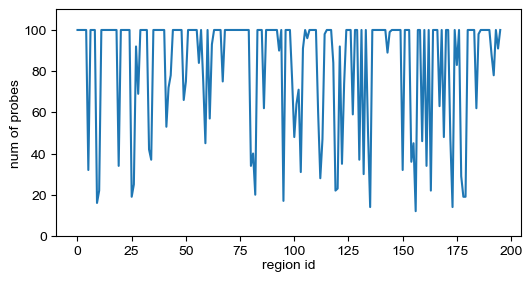

In [315]:
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dict.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_kept*1.1])
plt.show()

# 3. Load and asssemble probes

## 3.1 design readout mapping dict (region_to_readout)

idea for this library:

1. each gene has 3 on-bits from 50 total-bits

2. each gene has a unique readout

3. 

In [164]:
on_num = 3
total_num = 50

encoding_file = os.path.join(pool_folder, f'covering_v_{total_num}_k_{on_num}_t_2.txt')
loaded_bits = []

with open(encoding_file, 'r') as _handle:
    # start reading
    _lines = _handle.read().split('\n')
    for _line in _lines:
        _bits = [int(_i)-1 for _i in _line.split(' ') if len(_i) > 0]
        loaded_bits.append(_bits)

loaded_bits = np.array(loaded_bits, dtype=np.int)

In [165]:
def convert_bits_to_matrix(bits):
    _matrix = np.ones([len(bits), np.max(bits)+1], dtype=np.int) * -1
    for _i, _b in enumerate(bits):
        _matrix[_i, _b] = 1
    return _matrix

In [167]:
# remove redundant bits
kept_bits = loaded_bits.copy()
kept_inds = np.zeros(len(kept_bits))
while np.sum(kept_inds) != len(kept_inds):
    kept_inds = np.ones(len(kept_bits), dtype=np.bool)
    _kept_mat = convert_bits_to_matrix(kept_bits)
    _dists = (total_num - (_kept_mat @ _kept_mat.T)) / 2
    _x, _y = np.where((_dists > 0) * (_dists <= 3))
    if len(_x) > 0:
        kept_inds[_x[0]] = False
        kept_bits = kept_bits[kept_inds]
        print(np.sum(kept_inds), kept_inds[_x[0]])

416 False
415 False
414 False
413 False
412 False
411 False
410 False
409 False
408 False
407 False
406 False
405 False
404 False
403 False
402 False
401 False
400 False
399 False
398 False
397 False
396 False
395 False
394 False
393 False
392 False
391 False


In [170]:
encoding_bits = kept_bits.copy()
encoding_mat = convert_bits_to_matrix(encoding_bits)

In [172]:
encoding_folder = os.path.join(pool_folder, 'Encoding_design')
if not os.path.exists(encoding_folder):
    os.makedirs(encoding_folder)
    print(encoding_folder)

pickle.dump(encoding_bits, open(os.path.join(encoding_folder, f'encoding_bits_total-{total_num}_on-{on_num}'), 'wb'))

In [200]:
chr_2_region_num = pickle.load(open(os.path.join(library_folder,'chr_2_region_num.pkl'), 'rb'))

#encoding_mat = encoding_mat
#encoding_bits = convert_matrix_to_bits(encoding_mat)


# assign into different chromosomes
cand_bits = list(encoding_bits)
total_bit_usage = np.zeros(np.max(cand_bits)+1)
chr_bit_usage_dict = {}
chr_2_region_bits = {}
for _chr, _num in sorted(chr_2_region_num.items(), key=lambda v:-v[1]):
    print(_chr, _num)
    chr_2_region_bits[_chr] = []
    # try to assign as even as possible for this chr
    _chr_bit_usage = np.zeros(np.max(cand_bits)+1)
    
    while len(chr_2_region_bits[_chr]) < _num:
        # for each cand_bit, estimate overlap
        _chr_usage_list = [np.sum(_chr_bit_usage[_bits]**2) for _bits in cand_bits]
        _total_usage_list = [np.sum(total_bit_usage[_bits]**2) for _bits in cand_bits]
        # find the least overlapping candidate
        _least_overlap_ind = []
        _chr_usage_th = np.min(_chr_usage_list)
        _total_usage_th = np.min(_total_usage_list)
        while len(_least_overlap_ind) == 0:
            _least_overlap_ind = np.intersect1d(np.where(np.array(_chr_usage_list)<=_chr_usage_th)[0], 
                                                np.where(np.array(_total_usage_list)<=_total_usage_th)[0])
            _total_usage_th += 1
        _least_overlap_ind = _least_overlap_ind[np.random.randint(len(_least_overlap_ind))]
        
        _sel_cand = cand_bits.pop(_least_overlap_ind)
        print(_chr_bit_usage[cand_bits[_least_overlap_ind]], total_bit_usage[cand_bits[_least_overlap_ind]],  _sel_cand)
        # update overlap list and chr_2_region_bits
        chr_2_region_bits[_chr].append(_sel_cand)
        _chr_bit_usage[_sel_cand] += 1
        total_bit_usage[_sel_cand] += 1
    
    chr_bit_usage_dict[_chr] = _chr_bit_usage


11 30
[0. 0. 0.] [0. 0. 0.] [ 8 18 38]
[0. 0. 0.] [0. 0. 0.] [21 22 45]
[0. 0. 0.] [0. 0. 0.] [17 39 41]
[0. 0. 0.] [0. 0. 0.] [15 26 30]
[0. 0. 0.] [0. 0. 0.] [2 3 6]
[0. 0. 0.] [0. 0. 0.] [ 7 28 43]
[1. 1. 0.] [1. 1. 0.] [14 37 48]
[0. 0. 0.] [0. 0. 0.] [ 4 19 33]
[0. 1. 0.] [0. 1. 0.] [13 32 49]
[0. 1. 1.] [0. 1. 1.] [25 31 44]
[0. 1. 1.] [0. 1. 1.] [ 5 16 35]
[0. 0. 1.] [0. 0. 1.] [10 34 42]
[1. 0. 1.] [1. 0. 1.] [27 46 47]
[0. 1. 1.] [0. 1. 1.] [ 0 11 12]
[0. 0. 1.] [0. 0. 1.] [29 36 42]
[0. 1. 1.] [0. 1. 1.] [23 24 35]
[0. 1. 1.] [0. 1. 1.] [ 9 22 40]
[0. 1. 1.] [0. 1. 1.] [ 1  3 20]
[1. 1. 1.] [1. 1. 1.] [0 5 6]
[1. 1. 1.] [1. 1. 1.] [27 28 32]
[1. 1. 2.] [1. 1. 2.] [23 34 47]
[1. 1. 1.] [1. 1. 1.] [12 13 41]
[1. 1. 1.] [1. 1. 1.] [ 8 14 17]
[2. 1. 2.] [2. 1. 2.] [ 7 48 49]
[1. 2. 1.] [1. 2. 1.] [25 30 36]
[1. 2. 1.] [1. 2. 1.] [10 21 29]
[1. 2. 2.] [1. 2. 2.] [ 1 38 40]
[1. 2. 2.] [1. 2. 2.] [ 9 11 33]
[1. 1. 2.] [1. 1. 2.] [15 19 44]
[1. 2. 1.] [1. 2. 1.] [ 2  4 16]
7 21
[0. 0

In [201]:
def calculate_closest_overlap(code_list, code, _localtion):
    """Calculate the closest neighbor of certain code at certain location"""
    if _localtion > len(code_list) or _localtion < 0:
        raise ValueError(f"invalid _location")
    _code_list = np.array(code_list)
    if len(_code_list) == 0:
        return np.inf
    else:
        _min_dists = []
        for _c in code:
            if not (_code_list==_c).any():
                _min_dists.append(np.inf)
            else:
                _match_loc,_  = np.where(_code_list == _c)
                _dists = np.abs(_match_loc - _localtion)
                _dists[_match_loc >= _localtion] += 1
                _min_dists.append(np.min(_dists))

    return np.float(np.min(_min_dists))

In [211]:
sorted_chr_bits = {}
sorted_chr_dists = {}
for _chr, _chr_bits in chr_bit_usage_dict.items():
    print(_chr)
    _chr_bits = np.array(chr_2_region_bits[_chr])
    code_degrees = np.array([np.sum(chr_bit_usage_dict[_chr][_b])-3 for _b in _chr_bits])

    final_codes = []
    final_dist = 0

    # it seems the random doesnt help
    for _iter in range(100):
        ordered_codes = []
        #ordered_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==np.min(code_degrees))]]
        #random.shuffle(ordered_codes)
        #for _degree in np.unique(code_degrees)[1:]:
        for _degree in np.unique(code_degrees):
            _cand_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==_degree)]]
            #print(_cand_codes, len(_cand_codes))
            #random.shuffle(_cand_codes)
            #print(_cand_codes, len(_cand_codes))
            for _code in _cand_codes:
                _dists = []
                for _i in range(0, len(ordered_codes)+1):
                    _dists.append(calculate_closest_overlap(ordered_codes, _code, _i))
                ordered_codes.insert(np.argmax(_dists), _code)
                #print(_dists, np.argmax(_dists))

        # check order
        final_dists = []
        for _i, _code in enumerate(ordered_codes):
            _other_codes = [_c for _j, _c in enumerate(ordered_codes) if _i != _j]
            final_dists.append(calculate_closest_overlap(_other_codes, _code, _i))
        if min(final_dists) > final_dist:
            final_dist = min(final_dists)
            final_codes = [np.array(_c) for _c in ordered_codes]
            print(min(final_dists), 'change')
    
    sorted_chr_bits[_chr] = np.array(final_codes)
    sorted_chr_dists[_chr] = np.array(final_dists)

11
6.0 change
7
6.0 change
9
14.0 change
4
inf change
15
inf change
2
inf change
3
inf change
6
inf change
17
inf change
1
inf change
14
inf change
8
inf change
16
inf change
12
inf change
10
inf change
5
inf change
13
inf change
19
inf change
18
inf change
X
inf change


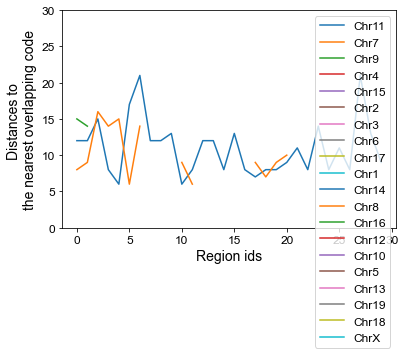

In [213]:
plt.figure()
for _chr, _dists in sorted_chr_dists.items():
    plt.plot( _dists, label=f'Chr{_chr}')
plt.xlabel('Region ids', fontsize=14)
plt.ylabel('Distances to \nthe nearest overlapping code', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.ylim([0,len(sel_bits)])
plt.show()

In [224]:
# save
chr_2_gene_names = pickle.load(open(os.path.join(library_folder,'chr_2_gene_names.pkl'), 'rb'))

In [226]:
# assemble to generate gene_to_encoding_bits
gene_2_bits = {}
for _chr in sorted_chr_bits:
    _chr_bits = sorted_chr_bits[_chr]
    _gene_names = chr_2_gene_names[_chr]
    print(_chr, len(_chr_bits), len(_gene_names))
    gene_2_bits.update({_g:_b for _g, _b in zip(_gene_names, _chr_bits)})

11 30 30
7 21 21
9 16 16
4 14 14
15 14 14
2 14 14
3 13 13
6 10 10
17 10 10
1 9 9
14 9 9
8 8 8
16 8 8
12 8 8
10 7 7
5 7 7
13 4 4
19 4 4
18 2 2
X 1 1


In [235]:
gene_list_folder = os.path.join(pool_folder, 'Gene_list')
gene_list_filename = os.path.join(gene_list_folder, 'uniqued_clustered_genes_for_yuan_2021-04-22.txt')

import pandas as pd
gene_df = pd.read_csv(gene_list_filename, delimiter = "\t", header=None)
gene_df.columns = ['Cluster', 'Gene']

gene_names = list(gene_df['Gene'])
for _igene, _gene in enumerate(gene_names):
    if _gene == 'Lect1': # there is one gene that actually has different name
        gene_names[_igene] = "Cnmd" 

In [247]:
gene_2_readout_dict = {}
for _igene, _gene in enumerate(gene_names):
    gene_2_readout_dict[_gene] = [f"u{_igene}"]
    gene_2_readout_dict[_gene].extend([f"c{_b}" for _b in gene_2_bits[_gene]])

# save
pickle.dump(gene_2_readout_dict, open(os.path.join(library_folder, 'gene_2_readout.pkl'), 'wb'))

In [246]:
gene_2_readout_dict

{'Ccl21a': ['u0', 'c7', 'c26', 'c35'],
 'Krt14': ['u1', 'c23', 'c34', 'c47'],
 'Krt5': ['u2', 'c13', 'c17', 'c34'],
 'Col6a1': ['u3', 'c2', 'c23', 'c43'],
 'Lifr': ['u4', 'c2', 'c26', 'c38'],
 'Itga6': ['u5', 'c16', 'c22', 'c49'],
 'Col4a1': ['u6', 'c9', 'c10', 'c41'],
 'Ascl1': ['u7', 'c26', 'c29', 'c41'],
 'Cald1': ['u8', 'c10', 'c23', 'c39'],
 'Krt17': ['u9', 'c7', 'c48', 'c49'],
 'C3': ['u10', 'c9', 'c20', 'c27'],
 'Trp63': ['u11', 'c17', 'c32', 'c40'],
 'Dclk1': ['u12', 'c1', 'c6', 'c13'],
 'Trpm5': ['u13', 'c6', 'c37', 'c43'],
 'Ly6g6f': ['u14', 'c3', 'c12', 'c31'],
 'Avil': ['u15', 'c11', 'c15', 'c49'],
 'Alox5ap': ['u16', 'c9', 'c38', 'c44'],
 'Hck': ['u17', 'c0', 'c17', 'c28'],
 'Plk2': ['u18', 'c5', 'c13', 'c22'],
 'Pik3r5': ['u19', 'c27', 'c46', 'c47'],
 'Agt': ['u20', 'c6', 'c29', 'c34'],
 'Nrgn': ['u21', 'c5', 'c25', 'c42'],
 'Plac8': ['u22', 'c7', 'c12', 'c20'],
 'Fxyd6': ['u23', 'c11', 'c34', 'c46'],
 'Pou2f3': ['u24', 'c33', 'c40', 'c47'],
 'Ccl20': ['u25', 'c3', 'c13',

## 3.2 loading components

### primers
pick primer set 2, 9 for 5kb (consistent with CTP-06)

In [316]:
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Primers'
primers = library_tools.assemble.load_primers([2,9], _primer_folder=primer_folder)

- Picked primer: ID: W1A03_primer_2
Name: W1A03_primer_2
Description: W1A03_primer_2
Number of features: 0
Seq('CCCGCAATGGCTGACAACCG')
- Picked primer: ID: W1A10_primer_9
Name: W1A10_primer_9
Description: W1A10_primer_9
Number of features: 0
Seq('TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG')


### readouts

1. unique readouts from DNA set

2. MERFISH bits for combinatorial

In [317]:
# summarize total readout usage
gene_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'gene_2_readout.pkl'), 'rb'))

In [318]:
# collect types
readout_usage_by_type = {}
for _gene, _infos in gene_2_readout_dict.items():
    for _info in _infos:
        if _info[0] not in readout_usage_by_type:
            readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in readout_usage_by_type[_info[0]]:
            readout_usage_by_type[_info[0]].append(int(_info[1:]))

### unique

In [319]:
readout_usage_dict = {_type:len(_v) for _type,_v in readout_usage_by_type.items()}
readout_dict ={}

In [350]:
reload(library_tools.assemble)
overwrite_readout_usage = True
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Libraries\Readouts'
readout_start = 0
num_color = 2
comb_readouts = library_tools.assemble.load_readouts(readout_usage_dict['c'], 
                                                       _type='designed_readouts', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=2, # 750, 647
                                                       _start_id=readout_start,
                                                       )
readout_dict['c'] = comb_readouts

unique_readouts = library_tools.assemble.load_readouts(readout_usage_dict['u'], 
                                                       _type='designed_readouts', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=2, # 750, 647
                                                       _start_id=readout_start+int(len(comb_readouts)/2),
                                                       )

readout_dict['u'] = unique_readouts

# save
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
if not os.path.isfile(readout_usage_file) or overwrite_readout_usage:
    print('save')
    pickle.dump(readout_dict, open(readout_usage_file, 'wb'))

save


## 3.3 assemble probes

In [351]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dict, 
                                               gene_2_readout_dict, readout_dict, primers, 
                                               primer_len=20, 
                                               num_readout_per_probe=4, 
                                               unique_readout_per_probe=True,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['u', 'c']
--- assemblying 100 probes in region: Acpp
--- assemblying 100 probes in region: Agt
--- assemblying 100 probes in region: Aldh3a1
--- assemblying 100 probes in region: Aldob
--- assemblying 100 probes in region: Alox5ap
--- assemblying 32 probes in region: Alpi
--- assemblying 100 probes in region: Alpl
--- assemblying 100 probes in region: Ang4
--- assemblying 100 probes in region: Anxa8
--- assemblying 16 probes in region: Apoa1
--- assemblying 22 probes in region: Apoa2
--- assemblying 100 probes in region: Apoc2
--- assemblying 100 probes in region: Apod
--- assemblying 100 probes in region: Avil
--- assemblying 100 probes in region: Bgn
--- assemblying 100 probes in region: C1qb
--- assemblying 100 probes in region: C3
--- assemblying 100 probes in region: Calb2
--- assemblying 100 probes in region: Cald1
--- assemblying 34 probes in region: Camp
--- assemblying 100 probes in 

--- assemblying 78 probes in region: Ttc36
--- assemblying 100 probes in region: Vpreb3
--- assemblying 91 probes in region: Xcl1
--- assemblying 100 probes in region: Zg16
-- 16309 probes assembled in total.
-- saving 16309 probes into file:\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\candidate_probes.fasta
-- saving readout_summary into file:\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\readout_summary.pkl


# 4.Check quality

## 4.1 Load probes

Checking procedures could restart from here

In [352]:
# folder for this library
# candidate full-length probe filename
candidate_basename = 'candidate_probes.fasta' # old version
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_basename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 16309


In [353]:
num_readout_per_probe = 4
primer_len=20
target_len=30
min_num_probes = 12

### 4.1.1 check primer usage

In [354]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 16309
True


### 4.1.2 check region probe number

In [355]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: Acpp -> 100
gene: Agt -> 100
gene: Aldh3a1 -> 100
gene: Aldob -> 100
gene: Alox5ap -> 100
gene: Alpi -> 32
gene: Alpl -> 100
gene: Ang4 -> 100
gene: Anxa8 -> 100
gene: Apoa1 -> 16
gene: Apoa2 -> 22
gene: Apoc2 -> 100
gene: Apod -> 100
gene: Avil -> 100
gene: Bgn -> 100
gene: C1qb -> 100
gene: C3 -> 100
gene: Calb2 -> 100
gene: Cald1 -> 100
gene: Camp -> 34
gene: Car4 -> 100
gene: Car8 -> 100
gene: Ccdc30 -> 100
gene: Cck -> 100
gene: Ccl1 -> 100
gene: Ccl2 -> 19
gene: Ccl20 -> 25
gene: Ccl6 -> 92
gene: Ccl9 -> 69
gene: Celf3 -> 100
gene: Cga -> 100
gene: Cilp -> 100
gene: Ckm -> 100
gene: Clps -> 42
gene: Cnfn -> 37
gene: Cnmd -> 100
gene: Col1a1 -> 100
gene: Col4a1 -> 100
gene: Col6a1 -> 100
gene: Cpn1 -> 100
gene: Crabp1 -> 100
gene: Cryaa -> 53
gene: Ctrb1 -> 72
gene: Cxcl13 -> 78
gene: Cyp1a2 -> 100
gene: Cyp2f2 -> 100
gene: Dbn1 -> 100
gene: Dclk1 -> 100
gene: Dlk1 -> 100
gene: Dppa3 -> 66
gene: Ecm1 -> 75
gene: Efna3 -> 100
gene: Elovl4 -> 100
gene: Fabp1 -> 100
gene: Fabp6

### 4.1.3 check readout usage for each gene

In [356]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_readout_per_probe)
print(reg2readout_check)

Acpp -> ['Stv_59', 'Stv_61', 'Stv_87', 'NDB_86']
Agt -> ['Stv_6', 'Stv_23', 'Stv_54', 'NDB_31']
Aldh3a1 -> ['Stv_16', 'Stv_48', 'Stv_61', 'NDB_293']
Aldob -> ['Stv_14', 'Stv_39', 'Stv_86', 'NDB_61']
Alox5ap -> ['Stv_26', 'Stv_29', 'Stv_37', 'NDB_25']
Alpi -> ['Stv_5', 'Stv_14', 'Stv_61', 'NDB_280']
Alpl -> ['Stv_25', 'Stv_33', 'Stv_37', 'NDB_269']
Ang4 -> ['Stv_23', 'Stv_27', 'Stv_61', 'NDB_274']
Anxa8 -> ['Stv_20', 'Stv_46', 'Stv_63', 'NDB_104']
Apoa1 -> ['Stv_37', 'Stv_45', 'Stv_54', 'NDB_67']
Apoa2 -> ['Stv_10', 'Stv_30', 'Stv_54', 'NDB_251']
Apoc2 -> ['Stv_5', 'Stv_12', 'Stv_40', 'NDB_208']
Apod -> ['Stv_14', 'Stv_54', 'Stv_64', 'NDB_182']
Avil -> ['Stv_39', 'Stv_42', 'Stv_90', 'NDB_23']
Bgn -> ['Stv_3', 'Stv_37', 'Stv_63', 'NDB_257']
C1qb -> ['Stv_4', 'Stv_53', 'Stv_65', 'NDB_266']
C3 -> ['Stv_13', 'Stv_37', 'Stv_53', 'NDB_16']
Calb2 -> ['Stv_7', 'Stv_11', 'Stv_50', 'NDB_290']
Cald1 -> ['Stv_8', 'Stv_48', 'Stv_64', 'NDB_13']
Camp -> ['Stv_26', 'Stv_63', 'Stv_90', 'NDB_197']
Car4 -

In [368]:
for _i, _rd in enumerate(comb_readouts):
    if _rd.id == 'Stv_59':
        print(_i)

31


In [369]:
for _i, _rd in enumerate(comb_readouts):
    if _rd.id == 'Stv_61':
        print(_i)

35


In [370]:
for _i, _rd in enumerate(comb_readouts):
    if _rd.id == 'Stv_87':
        print(_i)

45


### 4.1.4 check readout usage in the library

In [357]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_readout_per_probe)

print(readout2reg_check)

-- extracting probes from >region:Acpp, region:Agt, region:Aldh3a1, region:Aldob, region:Alox5ap, region:Alpi, region:Alpl, region:Ang4, region:Anxa8, region:Apoa1, region:Apoa2, region:Apoc2, region:Apod, region:Avil, region:Bgn, region:C1qb, region:C3, region:Calb2, region:Cald1, region:Camp, region:Car4, region:Car8, region:Ccdc30, region:Cck, region:Ccl1, region:Ccl2, region:Ccl20, region:Ccl6, region:Ccl9, region:Celf3, region:Cga, region:Cilp, region:Ckm, region:Clps, region:Cnfn, region:Cnmd, region:Col1a1, region:Col4a1, region:Col6a1, region:Cpn1, region:Crabp1, region:Cryaa, region:Ctrb1, region:Cxcl13, region:Cyp1a2, region:Cyp2f2, region:Dbn1, region:Dclk1, region:Dlk1, region:Dppa3, region:Ecm1, region:Efna3, region:Elovl4, region:Fabp1, region:Fabp6, region:Fam183b, region:Fam25c, region:Fgg, region:Foxa1, region:Foxa2, region:Foxa3, region:Foxj1, region:Fxyd3, region:Fxyd6, region:Gabrp, region:Gal, region:Gatm, region:Ghrl, region:Gm13539, region:Gm2a, region:Gm94, regi

### 4.1.5 check bewteen probes

In [359]:
# construct internal map
int_map = check._construct_internal_map(full_records, library_folder) 

-- saving internal 17-mer map to file:\\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\probe_table_17.npz


In [360]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)
print(readout_count_check)

True


In [362]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, target_len=target_len)

-- total probes removed by internal screening: 0


### 4.1.6 finish checking, save

In [363]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

* This library is blasted against genome because this is an intronic RNA library

In [364]:
blast_database = os.path.join(reference_folder, 'blast_database', 'GRCm38_ensembl')

check.Blast_probes(kept_records, library_folder, num_threads=20, 
                   blast_db=blast_database)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Libraries\Genomes\mouse\GRCm38_ensembl\blast_database\GRCm38_ensembl
-- number of probes loaded: 16309
--- processing region: Acpp with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Acpp.fasta
-- *blasting region: Acpp
--- total time for blast Acpp: 26.21399974822998
--- processing region: Agt with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Agt.fasta
-- *blasting region: Agt
--- total time for blast Agt: 18.7400004863739
--- processing region: Aldh3a1 with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Aldh3a1.fasta
-- *blasting region: Aldh3a1
--- total time for blast Aldh3a1: 14.306565284729004
--- processing region: Aldob with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\

--- total time for blast Clps: 13.898998975753784
--- processing region: Cnfn with 37 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Cnfn.fasta
-- *blasting region: Cnfn
--- total time for blast Cnfn: 2.957000255584717
--- processing region: Cnmd with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Cnmd.fasta
-- *blasting region: Cnmd
--- total time for blast Cnmd: 9.165003538131714
--- processing region: Col1a1 with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Col1a1.fasta
-- *blasting region: Col1a1
--- total time for blast Col1a1: 7.305996894836426
--- processing region: Col4a1 with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Col4a1.fasta
-- *blasting region: Col4a1
--- total time for blast Col4a

--- total time for blast Ghrl: 5.937745571136475
--- processing region: Gm13539 with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Gm13539.fasta
-- *blasting region: Gm13539
--- total time for blast Gm13539: 9.09399962425232
--- processing region: Gm2a with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Gm2a.fasta
-- *blasting region: Gm2a
--- total time for blast Gm2a: 9.160000085830688
--- processing region: Gm94 with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Gm94.fasta
-- *blasting region: Gm94
--- total time for blast Gm94: 8.953001737594604
--- processing region: Gp2 with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Gp2.fasta
-- *blasting region: Gp2
--- total time for blast Gp2: 42.379

--- total time for blast Krt13: 5.342000484466553
--- processing region: Krt14 with 71 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Krt14.fasta
-- *blasting region: Krt14
--- total time for blast Krt14: 5.1230010986328125
--- processing region: Krt16 with 31 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Krt16.fasta
-- *blasting region: Krt16
--- total time for blast Krt16: 3.1629996299743652
--- processing region: Krt17 with 91 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Krt17.fasta
-- *blasting region: Krt17
--- total time for blast Krt17: 7.872998476028442
--- processing region: Krt19 with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Krt19.fasta
-- *blasting region: Krt19
--- total time for blast Krt1

--- total time for blast Npy: 21.11099600791931
--- processing region: Nrgn with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Nrgn.fasta
-- *blasting region: Nrgn
--- total time for blast Nrgn: 8.444000482559204
--- processing region: Nts with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Nts.fasta
-- *blasting region: Nts
--- total time for blast Nts: 14.129998207092285
--- processing region: Oas1d with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Oas1d.fasta
-- *blasting region: Oas1d
--- total time for blast Oas1d: 12.277000427246094
--- processing region: Oas1h with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Oas1h.fasta
-- *blasting region: Oas1h
--- total time for blast Oas1h: 40.64500

--- total time for blast Sftpd: 5.894999265670776
--- processing region: Slpi with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Slpi.fasta
-- *blasting region: Slpi
--- total time for blast Slpi: 13.192001819610596
--- processing region: Sox8 with 47 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Sox8.fasta
-- *blasting region: Sox8
--- total time for blast Sox8: 3.9499993324279785
--- processing region: Spag8 with 14 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Spag8.fasta
-- *blasting region: Spag8
--- total time for blast Spag8: 1.381178617477417
--- processing region: Sparc with 100 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Libraries\CTP-10_Aire\Genes_intronic_RNA\blast\probe_gene_Sparc.fasta
-- *blasting region: Sparc
--- total time for blast Sparc: 23.3

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [365]:
# screen
num_probes_per_region = 100
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             hard_thres=target_len,
                                                                                             soft_count_th=50,
                                                                                             )

- Number of probes loaded: 16309
- Number of regions in this library: 196
-- checking probes in region: Acpp
--- gene=Acpp, id=14 removed by soft count = 5518
--- gene=Acpp, id=15 removed by soft count = 23868
--- gene=Acpp, id=46 removed by soft count = 818
--- gene=Acpp, id=59 removed by soft count = 90
--- gene=Acpp, id=65 removed by soft count = 9292
--- number of probes: 100 , kept by blast: 95 , if remove dups: 95
--- remove duplicated probes
-- number of probes kept for this region: 95
-- checking probes in region: Agt
--- gene=Agt, id=19 removed by soft count = 76
--- gene=Agt, id=23 removed by soft count = 55
--- gene=Agt, id=24 removed by soft count = 4148
--- number of probes: 100 , kept by blast: 97 , if remove dups: 97
--- remove duplicated probes
-- number of probes kept for this region: 97
-- checking probes in region: Aldh3a1
--- gene=Aldh3a1, id=76 removed by soft count = 1084
--- gene=Aldh3a1, id=77 removed by soft count = 1070
--- gene=Aldh3a1, id=79 removed by soft 

--- gene=Car4, id=84 removed by soft count = 12477
--- gene=Car4, id=85 removed by hard count = 32
--- gene=Car4, id=87 removed by hard count = 0
--- gene=Car4, id=94 removed by soft count = 51
--- number of probes: 100 , kept by blast: 96 , if remove dups: 96
--- remove duplicated probes
-- number of probes kept for this region: 96
-- checking probes in region: Car8
--- gene=Car8, id=44 removed by hard count = 0
--- gene=Car8, id=45 removed by soft count = 2122
--- gene=Car8, id=46 removed by soft count = 3298
--- gene=Car8, id=56 removed by soft count = 218
--- gene=Car8, id=67 removed by hard count = 70
--- gene=Car8, id=68 removed by soft count = 13084
--- number of probes: 100 , kept by blast: 94 , if remove dups: 94
--- remove duplicated probes
-- number of probes kept for this region: 94
-- checking probes in region: Ccdc30
--- gene=Ccdc30, id=26 removed by soft count = 1159
--- gene=Ccdc30, id=27 removed by soft count = 1202
--- gene=Ccdc30, id=28 removed by soft count = 2485
-

--- gene=Cyp1a2, id=50 removed by soft count = 158
--- gene=Cyp1a2, id=52 removed by soft count = 60
--- gene=Cyp1a2, id=92 removed by soft count = 279
--- gene=Cyp1a2, id=95 removed by soft count = 89
--- number of probes: 100 , kept by blast: 96 , if remove dups: 96
--- remove duplicated probes
-- number of probes kept for this region: 96
-- checking probes in region: Cyp2f2
--- gene=Cyp2f2, id=24 removed by soft count = 1009
--- gene=Cyp2f2, id=52 removed by soft count = 63
--- gene=Cyp2f2, id=56 removed by soft count = 333
--- gene=Cyp2f2, id=71 removed by soft count = 2423
--- gene=Cyp2f2, id=74 removed by soft count = 175
--- gene=Cyp2f2, id=83 removed by soft count = 85
--- number of probes: 100 , kept by blast: 94 , if remove dups: 94
--- remove duplicated probes
-- number of probes kept for this region: 94
-- checking probes in region: Dbn1
--- gene=Dbn1, id=82 removed by soft count = 173
--- number of probes: 100 , kept by blast: 99 , if remove dups: 99
--- remove duplicated 

--- gene=Gp2, id=24 removed by soft count = 1723
--- gene=Gp2, id=25 removed by hard count = 5
--- gene=Gp2, id=26 removed by hard count = 5
--- gene=Gp2, id=27 removed by hard count = 61
--- gene=Gp2, id=28 removed by soft count = 10746
--- gene=Gp2, id=29 removed by hard count = 122
--- gene=Gp2, id=30 removed by hard count = 25
--- gene=Gp2, id=31 removed by soft count = 2056
--- gene=Gp2, id=32 removed by soft count = 20934
--- gene=Gp2, id=33 removed by hard count = 63
--- gene=Gp2, id=34 removed by soft count = 803
--- gene=Gp2, id=62 removed by soft count = 54
--- number of probes: 100 , kept by blast: 88 , if remove dups: 88
--- remove duplicated probes
-- number of probes kept for this region: 88
-- checking probes in region: Gpx3
--- gene=Gpx3, id=66 removed by soft count = 822
--- gene=Gpx3, id=80 removed by soft count = 172
--- number of probes: 100 , kept by blast: 98 , if remove dups: 98
--- remove duplicated probes
-- number of probes kept for this region: 98
-- checking

--- gene=Idi2, id=59 removed by soft count = 65
--- gene=Idi2, id=63 removed by soft count = 187
--- gene=Idi2, id=64 removed by hard count = 3
--- gene=Idi2, id=65 removed by hard count = 3
--- gene=Idi2, id=66 removed by hard count = 3
--- gene=Idi2, id=67 removed by hard count = 3
--- gene=Idi2, id=70 removed by hard count = 3
--- gene=Idi2, id=71 removed by hard count = 3
--- gene=Idi2, id=72 removed by hard count = 3
--- gene=Idi2, id=73 removed by hard count = 3
--- gene=Idi2, id=74 removed by hard count = 3
--- gene=Idi2, id=75 removed by soft count = 76
--- gene=Idi2, id=76 removed by hard count = 3
--- gene=Idi2, id=77 removed by hard count = 3
--- gene=Idi2, id=78 removed by hard count = 3
--- gene=Idi2, id=79 removed by hard count = 3
--- gene=Idi2, id=84 removed by soft count = 178
--- gene=Idi2, id=88 removed by hard count = 3
--- number of probes: 100 , kept by blast: 77 , if remove dups: 6
-- number of probes kept for this region: 77
-- checking probes in region: Ifi27l2

--- gene=Krt77, id=17 removed by soft count = 574
--- gene=Krt77, id=74 removed by soft count = 69
--- gene=Krt77, id=75 removed by soft count = 65
--- number of probes: 100 , kept by blast: 95 , if remove dups: 95
--- remove duplicated probes
-- number of probes kept for this region: 95
-- checking probes in region: Krt9
--- gene=Krt9, id=1 removed by soft count = 176
--- number of probes: 100 , kept by blast: 99 , if remove dups: 99
--- remove duplicated probes
-- number of probes kept for this region: 99
-- checking probes in region: Krtdap
--- gene=Krtdap, id=37 removed by hard count = 0
--- number of probes: 60 , kept by blast: 59 , if remove dups: 59
-- number of probes kept for this region: 59
-- checking probes in region: Lcn2
--- number of probes: 28 , kept by blast: 28 , if remove dups: 28
-- number of probes kept for this region: 28
-- checking probes in region: Lcn3
--- gene=Lcn3, id=26 removed by hard count = 13
--- gene=Lcn3, id=28 removed by hard count = 5
--- gene=Lcn3,

--- number of probes: 14 , kept by blast: 14 , if remove dups: 14
-- number of probes kept for this region: 14
-- checking probes in region: Npy
--- gene=Npy, id=58 removed by hard count = 358
--- gene=Npy, id=59 removed by soft count = 132
--- gene=Npy, id=60 removed by soft count = 73
--- number of probes: 100 , kept by blast: 97 , if remove dups: 97
--- remove duplicated probes
-- number of probes kept for this region: 97
-- checking probes in region: Nrgn
--- number of probes: 100 , kept by blast: 100 , if remove dups: 100
--- remove duplicated probes
-- number of probes kept for this region: 100
-- checking probes in region: Nts
--- gene=Nts, id=3 removed by soft count = 1311
--- gene=Nts, id=4 removed by soft count = 172
--- number of probes: 100 , kept by blast: 98 , if remove dups: 98
--- remove duplicated probes
-- number of probes kept for this region: 98
-- checking probes in region: Oas1d
--- gene=Oas1d, id=1 removed by hard count = 4
--- gene=Oas1d, id=10 removed by soft c

--- number of probes: 100 , kept by blast: 99 , if remove dups: 99
--- remove duplicated probes
-- number of probes kept for this region: 99
-- checking probes in region: Reg3b
--- number of probes: 46 , kept by blast: 46 , if remove dups: 46
-- number of probes kept for this region: 46
-- checking probes in region: Reg4
--- gene=Reg4, id=7 removed by soft count = 108
--- number of probes: 100 , kept by blast: 99 , if remove dups: 99
--- remove duplicated probes
-- number of probes kept for this region: 99
-- checking probes in region: Retnla
--- gene=Retnla, id=14 removed by hard count = 27
--- number of probes: 34 , kept by blast: 33 , if remove dups: 32
-- number of probes kept for this region: 33
-- checking probes in region: Riiad1
--- gene=Riiad1, id=56 removed by soft count = 92
--- gene=Riiad1, id=63 removed by soft count = 277
--- number of probes: 100 , kept by blast: 98 , if remove dups: 98
--- remove duplicated probes
-- number of probes kept for this region: 98
-- checking

--- gene=Trp63, id=59 removed by soft count = 75
--- number of probes: 100 , kept by blast: 99 , if remove dups: 99
--- remove duplicated probes
-- number of probes kept for this region: 99
-- checking probes in region: Trpm5
--- gene=Trpm5, id=76 removed by soft count = 1079
--- gene=Trpm5, id=79 removed by soft count = 59
--- gene=Trpm5, id=98 removed by soft count = 127
--- number of probes: 100 , kept by blast: 97 , if remove dups: 97
--- remove duplicated probes
-- number of probes kept for this region: 97
-- checking probes in region: Tspan1
--- gene=Tspan1, id=77 removed by soft count = 4300
--- number of probes: 88 , kept by blast: 87 , if remove dups: 87
--- remove duplicated probes
-- number of probes kept for this region: 87
-- checking probes in region: Ttc36
--- number of probes: 78 , kept by blast: 78 , if remove dups: 78
--- remove duplicated probes
-- number of probes kept for this region: 78
-- checking probes in region: Vpreb3
--- gene=Vpreb3, id=15 removed by soft co

In [ ]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")